<a href="https://colab.research.google.com/github/BiancaSeolin/EstruturaDeDados-C./blob/main/Copy_of_Gr%C3%A1ficos_Jornada_de_Compra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seção 1 - Imports e pré-processamento

### Instalação de bibliotecas e download dos CSVs

In [ ]:
!wget -q https://github.com/justrajdeep/fonts/raw/master/Arial.ttf

import os
import re
import sys
import gdown
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/content/Arial.ttf'
fm.fontManager.addfont(font_path)
arial_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = arial_prop.get_name()

!mkdir dataframes
!gdown --id 1hJlwHMpP7Zzatwk9BJHl-ZK2iMHZWvR0 -O dataframes/jornada_de_compra_e_percepcao_dos_canais.csv
!gdown --id 1ajdrTXaUqVBvHgK1GWV-reVjkyApNSdW -O dataframes/jornada_de_compra_consultoras.csv

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hJlwHMpP7Zzatwk9BJHl-ZK2iMHZWvR0
To: /content/dataframes/jornada_de_compra_e_percepcao_dos_canais.csv
100% 29.8k/29.8k [00:00<00:00, 10.4MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ajdrTXaUqVBvHgK1GWV-reVjkyApNSdW
To: /content/dataframes/jornada_de_compra_consultoras.csv
100% 16.3k/16.3k [00:00<00:00, 3.42MB/s]


## Pré-processamento dos DataFrames: Jornada de Compra (Compradores e Consultoras)

In [ ]:
import pandas as pd
from typing import Dict, List

# ============================================================================
# PRIMEIRO DATAFRAME: JORNADA DE COMPRA
# ============================================================================

df_jornada_compra = pd.read_csv('dataframes/jornada_de_compra_e_percepcao_dos_canais.csv')

# Renomeação de colunas
df_jornada_compra.columns = [
    'timestamp',
    'faixa_etaria',
    'regiao',
    'canais_informacao',
    'canais_compra',
    'local_finalizacao',
    'transicao_canais',
    'canais_transicao',
    'atencao_check',
    'facilidade_compra',
    'satisfacao_geral',
    'melhorias_sugeridas',
    'comprou_com_consultor',
    'canal_preferencia_consultor',
    'info_online_suficiente',
    'info_faltou',
    'preferencia_futura'
]

print(f"Shape original: {df_jornada_compra.shape}")
print(f"Total de respostas: {df_jornada_compra.shape[0]}")
print(f"Total de colunas: {df_jornada_compra.shape[1]}")
print("\n")


def expandir_multiplas_respostas(df, coluna):
    """
    Transforma uma coluna com múltiplas respostas separadas por vírgula
    em múltiplas colunas binárias (one-hot encoding).

    Args:
        df (pd.DataFrame): DataFrame com os dados
        coluna (str): Nome da coluna a ser expandida

    Returns:
        pd.DataFrame: DataFrame com as novas colunas binárias adicionadas
        list: Lista com as opções únicas encontradas
    """
    todas_opcoes = set()
    for valor in df[coluna].dropna():
        # Separar por vírgula e remover espaços
        opcoes = [opt.strip() for opt in str(valor).split(',')]
        todas_opcoes.update(opcoes)

    # Ord alfabeticamente
    todas_opcoes = sorted(todas_opcoes)

    print(f"Opções únicas em '{coluna}': {len(todas_opcoes)}")
    for i, opt in enumerate(todas_opcoes, 1):
        print(f"  {i}. {opt}")

    # 1 se a opção foi marcada, 0 caso contrário
    for opcao in todas_opcoes:
        nome_coluna = f"{coluna}_{opcao}"
        df[nome_coluna] = df[coluna].apply(
            lambda x: 1 if pd.notna(x) and opcao in str(x) else 0
        )

    print(f"{len(todas_opcoes)} colunas binárias criadas para '{coluna}'\n")

    return df, todas_opcoes


df_jornada_compra, opcoes_info = expandir_multiplas_respostas(df_jornada_compra, 'canais_informacao')
df_jornada_compra, opcoes_compra = expandir_multiplas_respostas(df_jornada_compra, 'canais_compra')

print("="*80)
print("Expansão de múltiplas colunas feita!")
print("="*80)
print(f"Shape final: {df_jornada_compra.shape}")
print(f"Novas colunas criadas: {df_jornada_compra.shape[1] - 17}")
print(f"Total de colunas binárias: {len(opcoes_info) + len(opcoes_compra)}")
print("\n")

# Métricas agregadas, contando quantos canais cada respondente utilizou em cada etapa
canais_info_cols = [col for col in df_jornada_compra.columns if col.startswith('canais_informacao_') and col != 'canais_informacao']
canais_compra_cols = [col for col in df_jornada_compra.columns if col.startswith('canais_compra_') and col != 'canais_compra']

df_jornada_compra['qtd_canais_info'] = df_jornada_compra[canais_info_cols].sum(axis=1)
df_jornada_compra['qtd_canais_compra'] = df_jornada_compra[canais_compra_cols].sum(axis=1)

print("Métricas agregadas adicionadas:")
print(f"  - qtd_canais_info: quantidade de canais usados para informação")
print(f"  - qtd_canais_compra: quantidade de canais usados para compra")
print("\n")

df_jornada_compra.to_csv('dataframes/jornada_compra_preprocessado.csv', index=False, encoding='utf-8-sig')
print("Arquivo salvo: 'jornada_compra_preprocessado.csv'")
print("\n")

print("="*80)
print("Primeiras linhas do DF apos pre-processamento: ")
print("="*80)
print(df_jornada_compra.head(3))
print("\n")

print(f"Média de canais utilizados para informação: {df_jornada_compra['qtd_canais_info'].mean():.2f}")
print(f"Mediana de canais para informação: {df_jornada_compra['qtd_canais_info'].median():.1f}")
print(f"Média de canais utilizados para compra: {df_jornada_compra['qtd_canais_compra'].mean():.2f}")
print(f"Mediana de canais para compra: {df_jornada_compra['qtd_canais_compra'].median():.1f}")
print("\n")

print("Distribuição - Quantidade de canais para informação:")
print(df_jornada_compra['qtd_canais_info'].value_counts().sort_index())
print("\n")

print("Distribuição - Quantidade de canais para compra:")
print(df_jornada_compra['qtd_canais_compra'].value_counts().sort_index())

# ============================================================================
# SEGUNDO DATAFRAME: CONSULTORAS
# ============================================================================

print("="*80)
print("Agora, pre-processando o segundo DF, das consultoras!")
print("="*80)

# Dicionário de respostas válidas para normalização
RESPOSTAS_VALIDAS_ETAPA = {
    "acompanhar": "Acompanhar o cliente até ele decidir fechar a compra.",
    "apresentar": "Apresentar o produto e tirar as primeiras dúvidas.",
    "negociar": "Negociar preços e condições de pagamento.",
    "finalizar": "O processo de finalização do pagamento e entrega.",
    "pos_venda": "O pós-venda (suporte, novas ofertas, etc.)."
}


def normalizar_resposta_etapa(texto: str, dicionario: Dict[str, str]) -> List[str]:
    """
    Normaliza texto de resposta usando dicionário de respostas válidas.

    Args:
        texto: string com uma ou múltiplas respostas separadas por vírgula
        dicionario: dict com {chave_busca: resposta_completa_válida}

    Returns:
        Lista de respostas válidas identificadas no texto

    Exemplo:
        >>> normalizar_resposta_etapa("Negociar preços, O pós-venda (suporte, novas ofertas, etc.).",
        ...                           RESPOSTAS_VALIDAS_ETAPA)
        ['Negociar preços e condições de pagamento.',
         'O pós-venda (suporte, novas ofertas, etc.).']
    """
    if pd.isna(texto):
        return []

    texto_lower = texto.lower()
    respostas_encontradas = []

    # Tenta identificar cada resposta válida no texto
    for chave, resposta_completa in dicionario.items():
        # Match por palavra-chave OU por início da resposta completa
        if chave in texto_lower or resposta_completa[:30].lower() in texto_lower:
            respostas_encontradas.append(resposta_completa)

    return respostas_encontradas


def expandir_multiplas_respostas_normalizada(df, coluna, dicionario_valido):
    """
    Expande coluna com múltiplas respostas usando dicionário de normalização.
    Específico para colunas que possuem vírgulas DENTRO das respostas válidas.

    Args:
        df (pd.DataFrame): DataFrame com os dados
        coluna (str): Nome da coluna a ser expandida
        dicionario_valido (dict): Dicionário {chave: resposta_completa}

    Returns:
        pd.DataFrame: DataFrame com as novas colunas binárias adicionadas
        list: Lista com as opções únicas (respostas válidas do dicionário)
    """
    # Cria coluna auxiliar com lista de respostas normalizadas
    df[f'{coluna}_list'] = df[coluna].apply(
        lambda x: normalizar_resposta_etapa(x, dicionario_valido)
    )

    # Opções vêm do dicionário (ordem garantida)
    opcoes = list(dicionario_valido.values())

    print(f"\nOpções únicas em '{coluna}': {len(opcoes)}")
    for i, opcao in enumerate(opcoes, 1):
        opcao_display = opcao if len(opcao) <= 60 else opcao[:57] + "..."
        print(f"  {i}. {opcao_display}")

    # Cria colunas binárias usando list comprehension (melhor performance)
    for opcao in opcoes:
        # Limita nome da coluna para compatibilidade
        col_name = f"{coluna}_{opcao[:50]}"
        df[col_name] = [int(opcao in respostas) for respostas in df[f'{coluna}_list']]

    print(f"{len(opcoes)} colunas binárias criadas para '{coluna}'\n")

    return df, opcoes


df_consultoras = pd.read_csv('dataframes/jornada_de_compra_consultoras.csv')

df_consultoras.columns = [
    'timestamp',
    'faixa_etaria',
    'regiao',
    'tempo_atuacao',
    'horas_semanais',
    'canal_principal',
    'etapa_desafiadora',
    'frequencia_transicao',
    'motivacao_cliente_site',
    'info_cliente_importantes',
    'sentimento_vendas_diretas',
    'ferramentas_digitais',
    'canais_integrados',
    'mudanca_desejada'
]

print(f"Shape original: {df_consultoras.shape}")
print(f"Total de respostas: {df_consultoras.shape[0]}")
print(f"Total de colunas: {df_consultoras.shape[1]}")
print("\n")

# Processamento da coluna 'etapa_desafiadora' com NORMALIZAÇÃO
df_consultoras, opcoes_etapa = expandir_multiplas_respostas_normalizada(
    df_consultoras,
    'etapa_desafiadora',
    RESPOSTAS_VALIDAS_ETAPA
)

# Processamento da coluna 'info_cliente_importantes' com função ORIGINAL
df_consultoras, opcoes_info = expandir_multiplas_respostas(
    df_consultoras,
    'info_cliente_importantes'
)

print(f"Shape final: {df_consultoras.shape}")
print(f"Novas colunas criadas: {df_consultoras.shape[1] - 14}")
print(f"Total de colunas binárias: {len(opcoes_etapa) + len(opcoes_info)}")
print("\n")

# Contagem de quantas etapas desafiadoras cada consultora marcou
etapa_cols = [col for col in df_consultoras.columns
              if col.startswith('etapa_desafiadora_')
              and col != 'etapa_desafiadora'
              and col != 'etapa_desafiadora_list']
df_consultoras['qtd_etapas_desafiadoras'] = df_consultoras[etapa_cols].sum(axis=1)

# Contagem de quantas informações de cliente são consideradas importantes
info_cols = [col for col in df_consultoras.columns
             if col.startswith('info_cliente_importantes_')
             and col != 'info_cliente_importantes']
df_consultoras['qtd_info_importantes'] = df_consultoras[info_cols].sum(axis=1)

print("Métricas agregadas adicionadas:")
print(f"  - qtd_etapas_desafiadoras: quantidade de etapas marcadas como desafiadoras")
print(f"  - qtd_info_importantes: quantidade de informações consideradas importantes")
print("\n")

# ============================================================================
# VALIDAÇÃO DE QUALIDADE
# ============================================================================

print("="*80)
print("VALIDAÇÃO DE QUALIDADE")
print("="*80)

# 1. Verifica se não há colunas duplicadas
duplicatas = df_consultoras.columns[df_consultoras.columns.duplicated()].tolist()
if duplicatas:
    print(f"⚠️  ERRO: Colunas duplicadas detectadas: {duplicatas}")
else:
    print("✓ Nenhuma coluna duplicada")

# 2. Verifica se opções foram corretamente expandidas
print(f"\n✓ Etapa desafiadora: {len(opcoes_etapa)} opções únicas (esperado: 5)")
print(f"✓ Info importantes: {len(opcoes_info)} opções únicas")

# 3. Verifica consistência das contagens
inconsistencia_etapa = (df_consultoras[etapa_cols].sum(axis=1) !=
                        df_consultoras['qtd_etapas_desafiadoras']).sum()
if inconsistencia_etapa > 0:
    print(f"⚠️  ERRO: {inconsistencia_etapa} linhas com contagem inconsistente (etapas)")
else:
    print("✓ Contagens de etapas desafiadoras consistentes")

inconsistencia_info = (df_consultoras[info_cols].sum(axis=1) !=
                       df_consultoras['qtd_info_importantes']).sum()
if inconsistencia_info > 0:
    print(f"⚠️  ERRO: {inconsistencia_info} linhas com contagem inconsistente (info)")
else:
    print("✓ Contagens de informações importantes consistentes")

# 4. Verifica se há opções suspeitas (fragmentos)
opcoes_etapa_curtas = [o for o in opcoes_etapa if len(o) < 15]
if opcoes_etapa_curtas:
    print(f"⚠️  ALERTA: Opções de etapa muito curtas (possível fragmento): {opcoes_etapa_curtas}")
else:
    print("✓ Todas as opções de etapa têm comprimento razoável")

print("="*80)
print("\n")

# ============================================================================
# SALVAMENTO
# ============================================================================

df_consultoras.to_csv('dataframes/jornada_consultoras_preprocessado.csv', index=False, encoding='utf-8-sig')
print("Arquivo salvo: 'jornada_consultoras_preprocessado.csv'")
print("\n")

# ============================================================================
# ANÁLISE ESTATÍSTICA
# ============================================================================

print("="*80)
print("Primeiras linhas do df apos o pre-processamento:")
print("="*80)
print(df_consultoras.head(3))
print("\n")

print("="*80)
print("Estatisticas")
print("="*80)
print("\n")

print("Perfil demografico:")
print("-" * 80)
print(f"Total de consultoras: {len(df_consultoras)}")
print(f"\nFaixa etária:")
print(df_consultoras['faixa_etaria'].value_counts().sort_index())
print(f"\nRegião:")
print(df_consultoras['regiao'].value_counts().sort_index())
print("\n")

print("perfil profissional")
print("-" * 80)
print("Tempo de atuação:")
print(df_consultoras['tempo_atuacao'].value_counts())
print(f"\nHoras semanais dedicadas:")
print(df_consultoras['horas_semanais'].value_counts())
print("\n")

print("Canais e interacao:")
print("-" * 80)
print("Canal principal de comunicação:")
print(df_consultoras['canal_principal'].value_counts())
print(f"\nFrequência de transição de canal (cliente inicia com consultora e finaliza no site):")
print(df_consultoras['frequencia_transicao'].value_counts())
print("\n")

print("Percepcao sobre vendas diretas:")
print("-" * 80)
print("Sentimento sobre crescimento das vendas pelo site/app:")
print(df_consultoras['sentimento_vendas_diretas'].value_counts())
print(f"\nCanais integrados:")
print(df_consultoras['canais_integrados'].value_counts())
print("\n")

print("Metricas agregadas:")
print("-" * 80)
print(f"Média de etapas consideradas desafiadoras: {df_consultoras['qtd_etapas_desafiadoras'].mean():.2f}")
print(f"Mediana: {df_consultoras['qtd_etapas_desafiadoras'].median():.1f}")
print(f"\nDistribuição - Quantidade de etapas desafiadoras:")
print(df_consultoras['qtd_etapas_desafiadoras'].value_counts().sort_index())
print("\n")

print(f"Média de informações consideradas importantes: {df_consultoras['qtd_info_importantes'].mean():.2f}")
print(f"Mediana: {df_consultoras['qtd_info_importantes'].median():.1f}")
print(f"\nDistribuição - Quantidade de informações importantes:")
print(df_consultoras['qtd_info_importantes'].value_counts().sort_index())
print("\n")

print("="*80)
print("Analise cruzada: Sentimento vs Tempo de atuacao")
print("="*80)
print("\n")

tabela_cruzada = pd.crosstab(
    df_consultoras['tempo_atuacao'],
    df_consultoras['sentimento_vendas_diretas'],
    margins=True
)
print(tabela_cruzada)
print("\n")

print("="*80)
print("Analise de valores ausentes")
print("="*80)
print("\n")

colunas_relevantes = [
    'motivacao_cliente_site',
    'ferramentas_digitais',
    'mudanca_desejada'
]

for col in colunas_relevantes:
    nan_count = df_consultoras[col].isna().sum()
    nan_pct = (nan_count / len(df_consultoras)) * 100
    print(f"{col}:")
    print(f"  Valores ausentes: {nan_count} ({nan_pct:.1f}%)")

    if nan_count < len(df_consultoras):
        print(f"  Exemplos de respostas:")
        amostras = df_consultoras[col].dropna().head(3)
        for i, valor in enumerate(amostras, 1):
            print(f"    {i}. {str(valor)[:60]}...")
    print()

print("="*80)
print("Insights")
print("="*80)
print("\n")

canal_dominante = df_consultoras['canal_principal'].mode()[0]
canal_pct = (df_consultoras['canal_principal'].value_counts().iloc[0] / len(df_consultoras)) * 100
print(f"Canal principal dominante: {canal_dominante} ({canal_pct:.1f}%)")

sentimento_dom = df_consultoras['sentimento_vendas_diretas'].mode()[0]
sentimento_pct = (df_consultoras['sentimento_vendas_diretas'].value_counts().iloc[0] / len(df_consultoras)) * 100
print(f"Sentimento predominante: {sentimento_dom} ({sentimento_pct:.1f}%)")

transicao_dom = df_consultoras['frequencia_transicao'].mode()[0]
transicao_pct = (df_consultoras['frequencia_transicao'].value_counts().iloc[0] / len(df_consultoras)) * 100
print(f"Frequência de transição mais comum: {transicao_dom} ({transicao_pct:.1f}%)")

integrados_sim = df_consultoras[df_consultoras['canais_integrados'] == 'Sim'].shape[0]
integrados_pct = (integrados_sim / len(df_consultoras)) * 100
print(f"Consultoras com canais integrados: {integrados_sim} ({integrados_pct:.1f}%)")

print("\n")
print("="*80)
print("pre-processamento finalizado :)) <3")
print("="*80)


Shape original: (92, 17)
Total de respostas: 92
Total de colunas: 17


Opções únicas em 'canais_informacao': 8
  1. Aplicativo da marca
  2. Facebook
  3. Indicação de consultora
  4. Instagram
  5. Loja física
  6. Outros
  7. Site da marca
  8. WhatsApp
8 colunas binárias criadas para 'canais_informacao'

Opções únicas em 'canais_compra': 7
  1. Aplicativo da marca
  2. Indicação de consultora (e a compra foi finalizada por ela)
  3. Instagram
  4. Loja física
  5. Outros
  6. Site da marca
  7. WhatsApp
7 colunas binárias criadas para 'canais_compra'

Expansão de múltiplas colunas feita!
Shape final: (92, 32)
Novas colunas criadas: 15
Total de colunas binárias: 15


Métricas agregadas adicionadas:
  - qtd_canais_info: quantidade de canais usados para informação
  - qtd_canais_compra: quantidade de canais usados para compra


Arquivo salvo: 'jornada_compra_preprocessado.csv'


Primeiras linhas do DF apos pre-processamento: 
             timestamp  faixa_etaria   regiao  \
0  03/07/20

# Seção 2. Primeira pesquisa: Jornada de Compra e Percepção dos Canais

## Gráfico 1 - Distribuição por região

Opção 1: Gráfico de barras verticais
Figura 1. Distribuição de respondentes por região do Brasil
Fonte: Resultados originais da pesquisa (N=92)


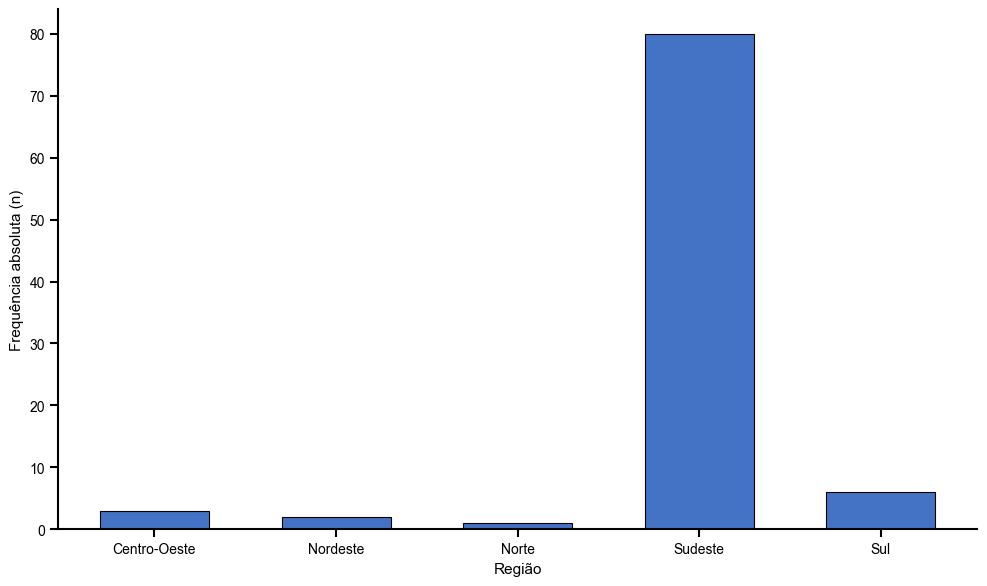

Opção 2: Gráfico de barras horizontais
Figura 2. Distribuição de respondentes por região do Brasil
Fonte: Resultados originais da pesquisa (N=92)


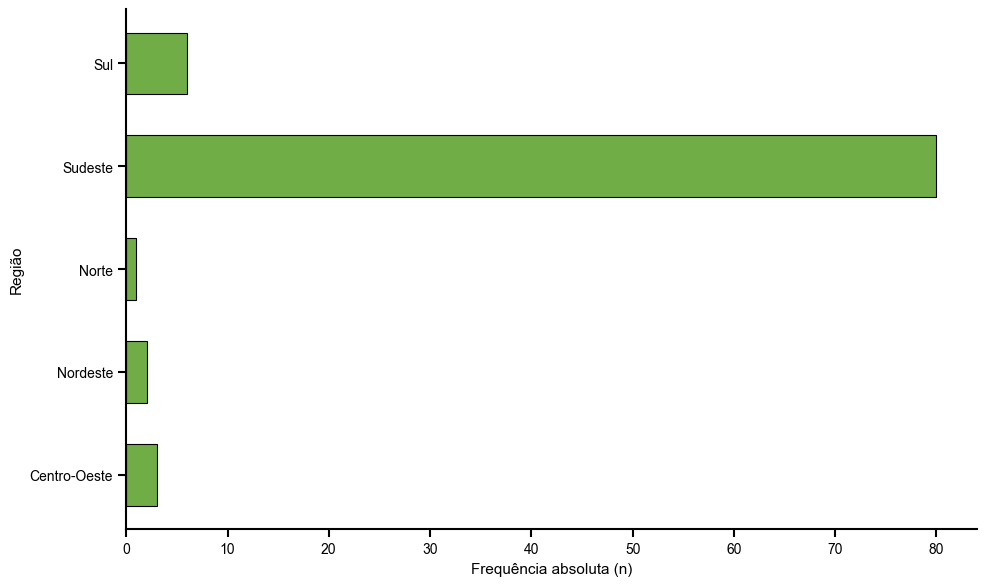

Opção 3: Gráfico de barras com percentual
Figura 3. Distribuição de respondentes por região do Brasil (frequência e percentual)
Fonte: Resultados originais da pesquisa (N=92)
Nota: Percentuais calculados sobre o total de respondentes válidos.


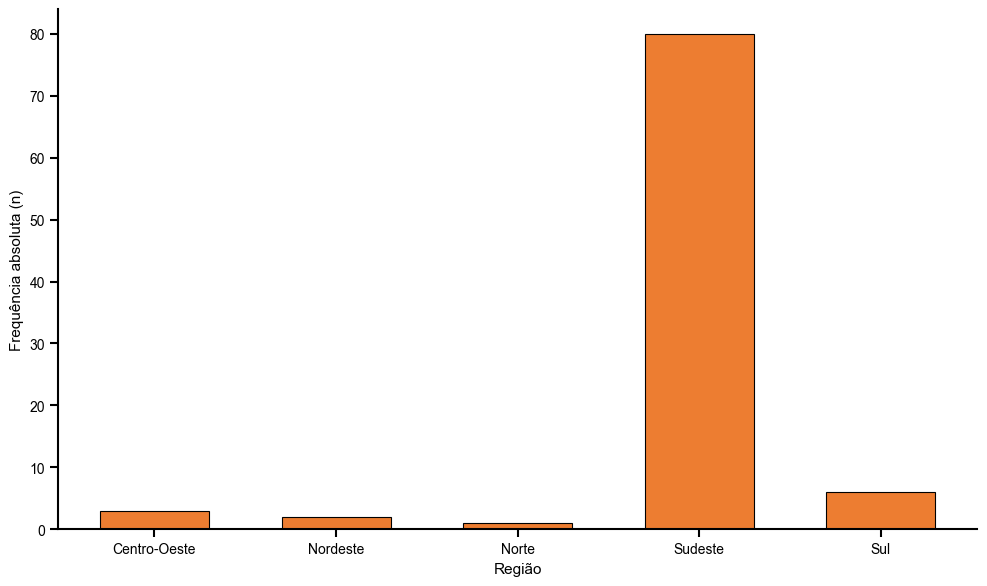

In [ ]:
# Regras para os gráficos:
# - Sem linhas de grade, bordas ou preenchimento
# - Eixos com linha sólida preta 1,5pt
# - Fonte Arial tamanho 11 ou menor
# - Legenda, fonte e nota conforme ABNT
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# Configuração do estilo global conforme normas
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

# Preparar dados
distribuicao_regiao = df_jornada_compra['regiao'].value_counts().sort_index()
regioes = distribuicao_regiao.index.tolist()
contagens = distribuicao_regiao.values.tolist()
n_total = len(df_jornada_compra)

print("="*80)
print("Opção 1: Gráfico de barras verticais")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(regioes, contagens, color='#4472C4', width=0.6,
               edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Região', fontsize=11, color='black', fontname='Arial')
ax1.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black', fontname='Arial')

ax1.grid(False)  # Sem linhas de grade
ax1.spines['top'].set_visible(False)  # Sem borda superior
ax1.spines['right'].set_visible(False)  # Sem borda direita

# Configurar bordas principais (inferior e esquerda)
for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

# Adicionando os valores nas barras
# for bar in bars:
#     height = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}',
#              ha='center', va='bottom', fontsize=10, fontname='Arial')

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Adicionando legenda da figura (fora do gráfico)
print('Figura 1. Distribuição de respondentes por região do Brasil')
print(f'Fonte: Resultados originais da pesquisa (N={n_total})')
# plt.figtext(0.5, -0.05, 'Figura 1. Distribuição de respondentes por região do Brasil',
#             ha='center', fontsize=11, fontname='Arial', weight='bold')
# # Aqui vai uma dúvida, normalmente pode só colocar "Fonte: Elaboração própria.", mas também tem essa opção abaixo:
# plt.figtext(0.5, -0.10, f'Fonte: Resultados originais da pesquisa (N={n_total})',
#             ha='center', fontsize=10, fontname='Arial', style='italic')

plt.savefig('figura1_distribuicao_regiao_vertical.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 2: Gráfico de barras horizontais")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 6))

bars = ax2.barh(regioes, contagens, color='#70AD47', height=0.6,
                edgecolor='black', linewidth=0.8)

ax2.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black', fontname='Arial')
ax2.set_ylabel('Região', fontsize=11, color='black', fontname='Arial')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

# for bar in bars:
#     width = bar.get_width()
#     ax2.text(width, bar.get_y() + bar.get_height()/2.,
#              f' {int(width)}',
#              ha='left', va='center', fontsize=10, fontname='Arial')

ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 2. Distribuição de respondentes por região do Brasil')
print(f'Fonte: Resultados originais da pesquisa (N={n_total})')
# plt.figtext(0.5, -0.05, 'Figura 2. Distribuição de respondentes por região do Brasil',
#             ha='center', fontsize=11, fontname='Arial', weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Resultados originais da pesquisa (N={n_total})',
#             ha='center', fontsize=10, fontname='Arial', style='italic')

plt.savefig('figura2_distribuicao_regiao_horizontal.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 3: Gráfico de barras com percentual")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(10, 6))

# Calcular percentuais
percentuais = (distribuicao_regiao / n_total * 100).values.tolist()

bars = ax3.bar(regioes, contagens, color='#ED7D31', width=0.6,
               edgecolor='black', linewidth=0.8)

ax3.set_xlabel('Região', fontsize=11, color='black', fontname='Arial')
ax3.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black', fontname='Arial')

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

# # Adicionando valores nas barras (frequência + percentual)
# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     ax3.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}\n({percentuais[i]:.1f}%)',
#              ha='center', va='bottom', fontsize=9, fontname='Arial')

ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 3. Distribuição de respondentes por região do Brasil (frequência e percentual)')
print(f'Fonte: Resultados originais da pesquisa (N={n_total})')
print('Nota: Percentuais calculados sobre o total de respondentes válidos.')

# plt.figtext(0.5, -0.05, 'Figura 3. Distribuição de respondentes por região do Brasil (frequência e percentual)',
#             ha='center', fontsize=11, fontname='Arial', weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Resultados originais da pesquisa (N={n_total})',
#             ha='center', fontsize=10, fontname='Arial', style='italic')
# plt.figtext(0.5, -0.13, 'Nota: Percentuais calculados sobre o total de respondentes válidos.',
#             ha='center', fontsize=9, fontname='Arial', style='italic')

plt.savefig('figura3_distribuicao_regiao_percentual.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


## Gráfico 1 - Distribuição por região com normalização
### Como houve uma discrepância nos resultados, resolvi normalizar um pouco para não ficar com o gráfico muito estourado

Opção 1: Gráfico de barras verticais
Figura 1. Distribuição de respondentes por região do Brasil
Fonte: Resultados originais da pesquisa (N=92)


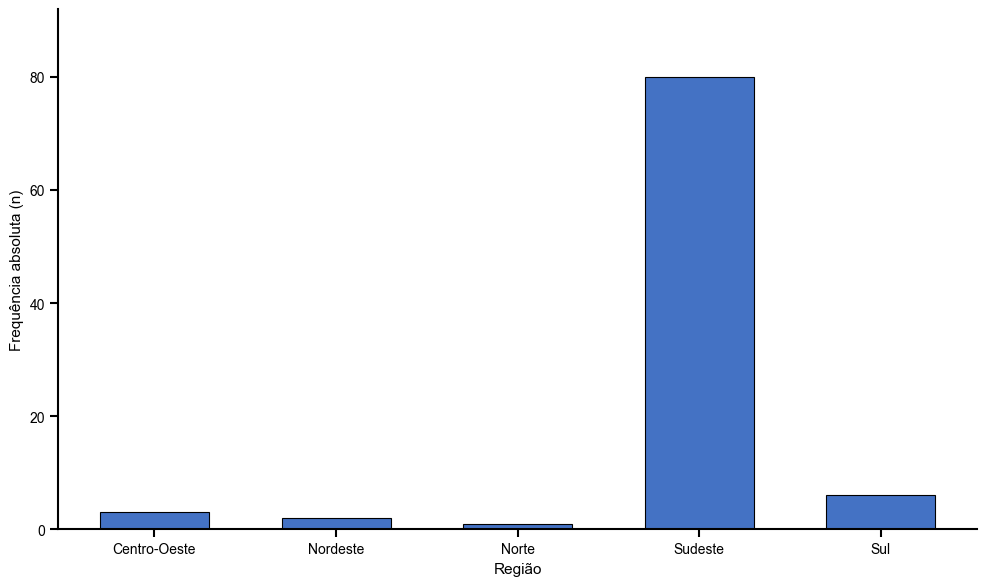

Opção 2: Gráfico de barras horizontais
Figura 2. Distribuição de respondentes por região do Brasil
Fonte: Resultados originais da pesquisa (N=92)


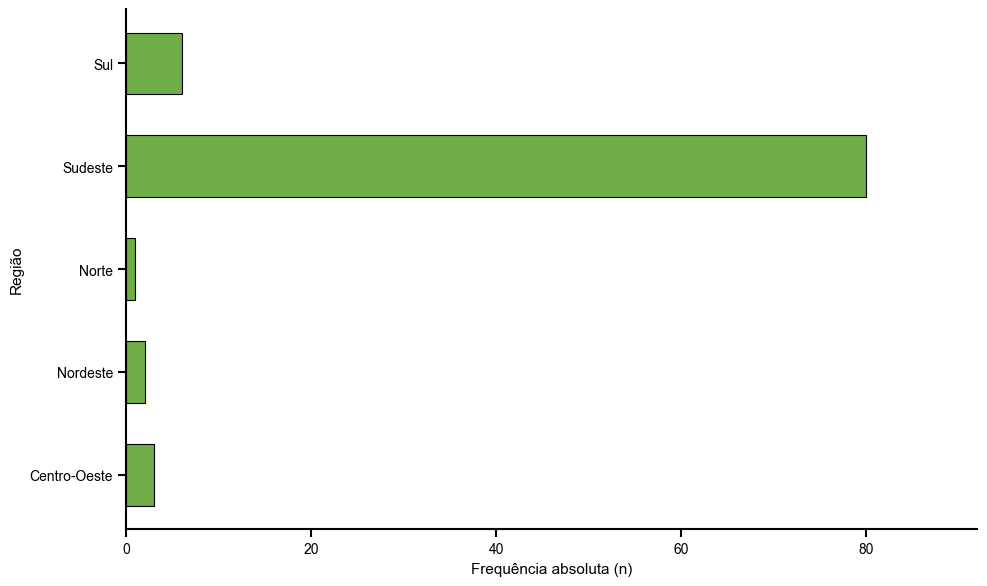

Opção 3: Gráfico de barras com percentual
Figura 3. Distribuição de respondentes por região do Brasil (frequência e percentual)
Fonte: Resultados originais da pesquisa (N=92)
Nota: Percentuais calculados sobre o total de respondentes válidos.


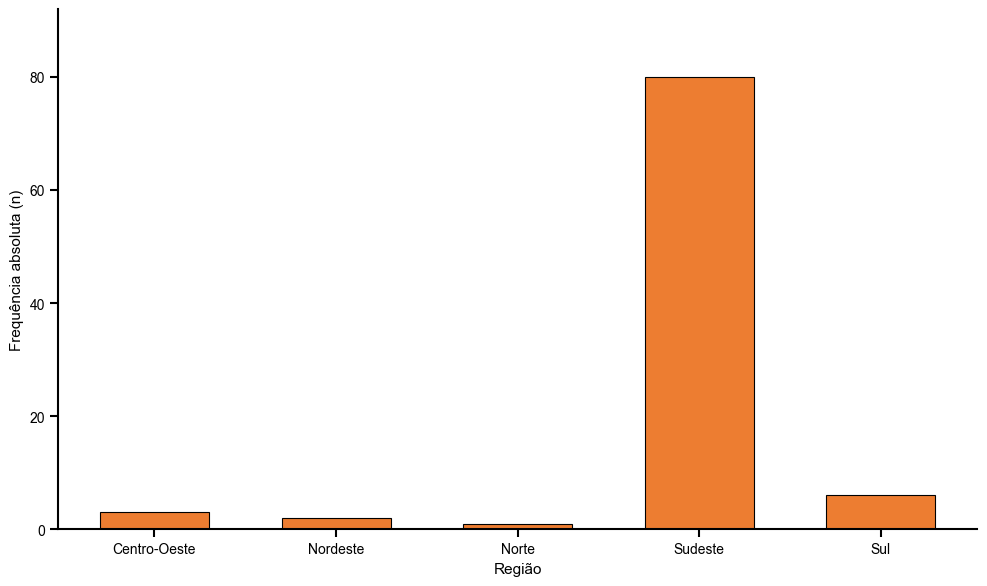

In [ ]:
# Regras para os gráficos:
# - Sem linhas de grade, bordas ou preenchimento
# - Eixos com linha sólida preta 1,5pt
# - Fonte Arial tamanho 11 ou menor
# - Legenda, fonte e nota conforme ABNT
# ============================================================================


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Configuração do estilo global conforme normas
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'


# Preparar dados
distribuicao_regiao = df_jornada_compra['regiao'].value_counts().sort_index()
regioes = distribuicao_regiao.index.tolist()
contagens = distribuicao_regiao.values.tolist()
n_total = len(df_jornada_compra)


print("="*80)
print("Opção 1: Gráfico de barras verticais")
print("="*80)


fig1, ax1 = plt.subplots(figsize=(10, 6))


bars = ax1.bar(regioes, contagens, color='#4472C4', width=0.6,
               edgecolor='black', linewidth=0.8)


ax1.set_xlabel('Região', fontsize=11, color='black', fontname='Arial')
ax1.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black', fontname='Arial')


ax1.grid(False)  # Sem linhas de grade
ax1.spines['top'].set_visible(False)  # Sem borda superior
ax1.spines['right'].set_visible(False)  # Sem borda direita


# Configurar bordas principais (inferior e esquerda)
for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)


# Ajustar escala do eixo Y para reduzir "estouro visual"
ax1.set_ylim(0, max(contagens) * 1.15)  # 15% de margem superior
ax1.set_yticks([0, 20, 40, 60, 80])  # Ticks personalizados


# # Adicionando os valores nas barras
# for bar in bars:
#     height = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}',
#              ha='center', va='bottom', fontsize=10, fontname='Arial')


ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')


plt.tight_layout()


# Adicionando legenda da figura (fora do gráfico)
print('Figura 1. Distribuição de respondentes por região do Brasil')
print(f'Fonte: Resultados originais da pesquisa (N={n_total})')
# plt.figtext(0.5, -0.05, 'Figura 1. Distribuição de respondentes por região do Brasil',
#             ha='center', fontsize=11, fontname='Arial', weight='bold')
# # Aqui vai uma dúvida, normalmente pode só colocar "Fonte: Elaboração própria.", mas também tem essa opção abaixo:
# plt.figtext(0.5, -0.10, f'Fonte: Resultados originais da pesquisa (N={n_total})',
#             ha='center', fontsize=10, fontname='Arial', style='italic')


plt.savefig('figura1_distribuicao_regiao_vertical.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()



print("="*80)
print("Opção 2: Gráfico de barras horizontais")
print("="*80)


fig2, ax2 = plt.subplots(figsize=(10, 6))


bars = ax2.barh(regioes, contagens, color='#70AD47', height=0.6,
                edgecolor='black', linewidth=0.8)


ax2.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black', fontname='Arial')
ax2.set_ylabel('Região', fontsize=11, color='black', fontname='Arial')


ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)


# Ajustar escala do eixo X para barras horizontais
ax2.set_xlim(0, max(contagens) * 1.15)  # 15% de margem
ax2.set_xticks([0, 20, 40, 60, 80])  # Ticks personalizados


# for bar in bars:
#     width = bar.get_width()
#     ax2.text(width, bar.get_y() + bar.get_height()/2.,
#              f' {int(width)}',
#              ha='left', va='center', fontsize=10, fontname='Arial')


ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')


plt.tight_layout()

print('Figura 2. Distribuição de respondentes por região do Brasil')
print(f'Fonte: Resultados originais da pesquisa (N={n_total})')

# plt.figtext(0.5, -0.05, 'Figura 2. Distribuição de respondentes por região do Brasil',
#             ha='center', fontsize=11, fontname='Arial', weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Resultados originais da pesquisa (N={n_total})',
#             ha='center', fontsize=10, fontname='Arial', style='italic')


plt.savefig('figura2_distribuicao_regiao_horizontal.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 3: Gráfico de barras com percentual")
print("="*80)


fig3, ax3 = plt.subplots(figsize=(10, 6))


# Calcular percentuais
percentuais = (distribuicao_regiao / n_total * 100).values.tolist()


bars = ax3.bar(regioes, contagens, color='#ED7D31', width=0.6,
               edgecolor='black', linewidth=0.8)


ax3.set_xlabel('Região', fontsize=11, color='black', fontname='Arial')
ax3.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black', fontname='Arial')


ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


for spine in ['bottom', 'left']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)


# Ajustar escala do eixo Y
ax3.set_ylim(0, max(contagens) * 1.15)  # 15% de margem superior
ax3.set_yticks([0, 20, 40, 60, 80])  # Ticks personalizados


# Adicionando valores nas barras (frequência + percentual)
# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     ax3.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}\n({percentuais[i]:.1f}%)',
#              ha='center', va='bottom', fontsize=9, fontname='Arial')


ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')


plt.tight_layout()


print('Figura 3. Distribuição de respondentes por região do Brasil (frequência e percentual)')
print(f'Fonte: Resultados originais da pesquisa (N={n_total})')
print('Nota: Percentuais calculados sobre o total de respondentes válidos.')

# plt.figtext(0.5, -0.05, 'Figura 3. Distribuição de respondentes por região do Brasil (frequência e percentual)',
#             ha='center', fontsize=11, fontname='Arial', weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Resultados originais da pesquisa (N={n_total})',
#             ha='center', fontsize=10, fontname='Arial', style='italic')
# plt.figtext(0.5, -0.13, 'Nota: Percentuais calculados sobre o total de respondentes válidos.',
#             ha='center', fontsize=9, fontname='Arial', style='italic')


plt.savefig('figura3_distribuicao_regiao_percentual.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


## Gráfico 2 - Distribuição por faixa etária

In [ ]:
# Analise dos dados de faixa etaria

print("Valores únicos na coluna 'faixa_etaria':")
faixas_unicas = df_jornada_compra['faixa_etaria'].unique()
print(faixas_unicas)
print(f"Total de categorias: {len(faixas_unicas)}")
print("\n")

print("Distribuição absoluta por faixa etária:")
distribuicao_faixa = df_jornada_compra['faixa_etaria'].value_counts().sort_index()
print(distribuicao_faixa)
print("\n")

print("Distribuição percentual por faixa etária:")
distribuicao_faixa_pct = df_jornada_compra['faixa_etaria'].value_counts(normalize=True).sort_index() * 100
for faixa, pct in distribuicao_faixa_pct.items():
    count = df_jornada_compra['faixa_etaria'].value_counts().sort_index()[faixa]
    print(f"  {faixa}: {count} respondentes ({pct:.2f}%)")
print("\n")

print("Valores ausentes (NaN):")
print(f"  Total de NaN: {df_jornada_compra['faixa_etaria'].isna().sum()}")
print("\n")

print("="*80)
print("Resumo estatistico")
print("="*80)
print(f"\nTotal de respondentes: {len(df_jornada_compra)}")
print(f"Faixas etárias presentes: {df_jornada_compra['faixa_etaria'].nunique()}")
print(f"Faixa mais frequente: {df_jornada_compra['faixa_etaria'].mode()[0]} (n={df_jornada_compra['faixa_etaria'].value_counts().iloc[0]})")
print(f"Faixa menos frequente: {df_jornada_compra['faixa_etaria'].value_counts().index[-1]} (n={df_jornada_compra['faixa_etaria'].value_counts().iloc[-1]})")

faixas_jovens = df_jornada_compra[df_jornada_compra['faixa_etaria'].isin(['18 a 24 anos', '25 a 34 anos'])].shape[0]
pct_jovens = (faixas_jovens / len(df_jornada_compra)) * 100
print(f"\nRespondentes com ≤34 anos: {faixas_jovens} ({pct_jovens:.1f}%)")
print(f"Respondentes com >34 anos: {len(df_jornada_compra) - faixas_jovens} ({100-pct_jovens:.1f}%)")


Valores únicos na coluna 'faixa_etaria':
['18 a 24 anos' '25 a 34 anos' '35 a 44 anos' '45 a 54 anos'
 '55 anos ou mais']
Total de categorias: 5


Distribuição absoluta por faixa etária:
faixa_etaria
18 a 24 anos       26
25 a 34 anos       42
35 a 44 anos       12
45 a 54 anos        7
55 anos ou mais     5
Name: count, dtype: int64


Distribuição percentual por faixa etária:
  18 a 24 anos: 26 respondentes (28.26%)
  25 a 34 anos: 42 respondentes (45.65%)
  35 a 44 anos: 12 respondentes (13.04%)
  45 a 54 anos: 7 respondentes (7.61%)
  55 anos ou mais: 5 respondentes (5.43%)


Valores ausentes (NaN):
  Total de NaN: 0


Resumo estatistico

Total de respondentes: 92
Faixas etárias presentes: 5
Faixa mais frequente: 25 a 34 anos (n=42)
Faixa menos frequente: 55 anos ou mais (n=5)

Respondentes com ≤34 anos: 68 (73.9%)
Respondentes com >34 anos: 24 (26.1%)


Opção 1: Gráfico de colunas verticais
Figura 4. Distribuição de respondentes por faixa etária
Fonte: Elaboração própria (N=92)


/tmp/ipython-input-3919847402.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(faixas, rotation=45, ha='right')


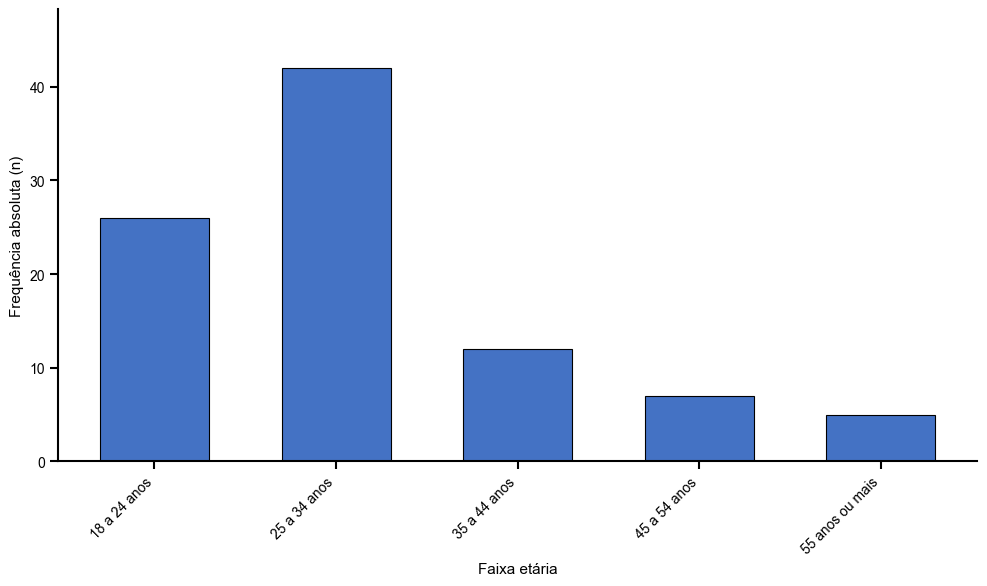

Opção 2: Gráfico de colunas com gradiente de cor
Figura 5. Distribuição de respondentes por faixa etária (gradiente de cor)
Fonte: Elaboração própria (N=92)
Nota: Cores mais escuras indicam faixas etárias maiores.


/tmp/ipython-input-3919847402.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(faixas, rotation=45, ha='right')


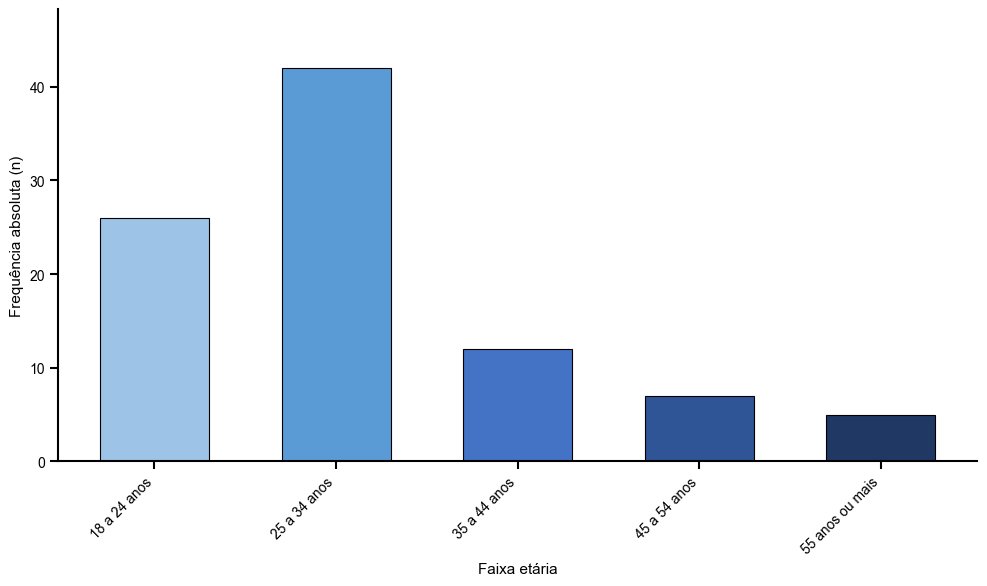

Opção 3: Gráfico de barras horizontais
Figura 6. Distribuição de respondentes por faixa etária
Fonte: Elaboração própria (N=92)


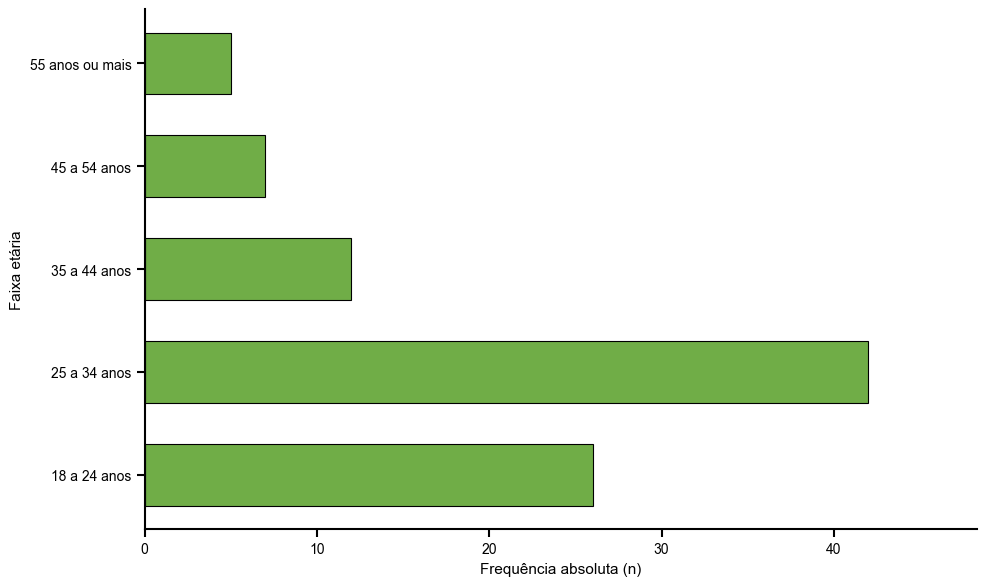

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

distribuicao_faixa = df_jornada_compra['faixa_etaria'].value_counts().sort_index()
faixas = distribuicao_faixa.index.tolist()
contagens = distribuicao_faixa.values.tolist()
n_total = len(df_jornada_compra)

print("="*80)
print("Opção 1: Gráfico de colunas verticais")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(faixas, contagens, color='#4472C4', width=0.6,
               edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Faixa etária', fontsize=11, color='black')
ax1.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax1.grid(False)  # Sem linhas de grade
ax1.spines['top'].set_visible(False)  # Sem borda superior
ax1.spines['right'].set_visible(False)  # Sem borda direita

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

# Ajustar escala do eixo Y (15% margem superior)
ax1.set_ylim(0, max(contagens) * 1.15)  # 0 a 48
ax1.set_yticks([0, 10, 20, 30, 40])  # Ticks personalizados

# for bar in bars:
#     height = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}',
#              ha='center', va='bottom', fontsize=10)

ax1.set_xticklabels(faixas, rotation=45, ha='right')

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 4. Distribuição de respondentes por faixa etária')
print(f'Fonte: Elaboração própria (N={n_total})')

# plt.figtext(0.5, -0.05, 'Figura 4. Distribuição de respondentes por faixa etária',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura4_distribuicao_faixa_etaria_colunas.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 2: Gráfico de colunas com gradiente de cor")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 6))

# Paleta de cores sequencial (azul claro -> azul escuro)
# Representa progressão de idade: jovens (claro) -> idosos (escuro)
cores_gradiente = ['#9DC3E6', '#5B9BD5', '#4472C4', '#2F5597', '#1F3864']

bars = ax2.bar(faixas, contagens, color=cores_gradiente, width=0.6,
               edgecolor='black', linewidth=0.8)

ax2.set_xlabel('Faixa etária', fontsize=11, color='black')
ax2.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

ax2.set_ylim(0, max(contagens) * 1.15)
ax2.set_yticks([0, 10, 20, 30, 40])

# for bar in bars:
#     height = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}',
#              ha='center', va='bottom', fontsize=10)

ax2.set_xticklabels(faixas, rotation=45, ha='right')

ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 5. Distribuição de respondentes por faixa etária (gradiente de cor)')
print(f'Fonte: Elaboração própria (N={n_total})')
print('Nota: Cores mais escuras indicam faixas etárias maiores.')

# plt.figtext(0.5, -0.05, 'Figura 5. Distribuição de respondentes por faixa etária (gradiente de cor)',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.13, 'Nota: Cores mais escuras indicam faixas etárias maiores.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura5_distribuicao_faixa_etaria_gradiente.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 3: Gráfico de barras horizontais")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(10, 6))

bars = ax3.barh(faixas, contagens, color='#70AD47', height=0.6,
                edgecolor='black', linewidth=0.8)

ax3.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax3.set_ylabel('Faixa etária', fontsize=11, color='black')

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

ax3.set_xlim(0, max(contagens) * 1.15)
ax3.set_xticks([0, 10, 20, 30, 40])

# for bar in bars:
#     width = bar.get_width()
#     ax3.text(width, bar.get_y() + bar.get_height()/2.,
#              f' {int(width)}',
#              ha='left', va='center', fontsize=10)

ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 6. Distribuição de respondentes por faixa etária')
print(f'Fonte: Elaboração própria (N={n_total})')

# plt.figtext(0.5, -0.05, 'Figura 6. Distribuição de respondentes por faixa etária',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura6_distribuicao_faixa_etaria_horizontal.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

## Gráfico 3 - Distribuição das respostas de 0 a 5.

Opção 1: Gráfico de colunas verticais

Figura 7. Distribuição de notas de facilidade no processo de compra
Fonte: Elaboração própria (N=92)
Nota: Cores indicam nível de satisfação (vermelho = baixo, verde = alto).



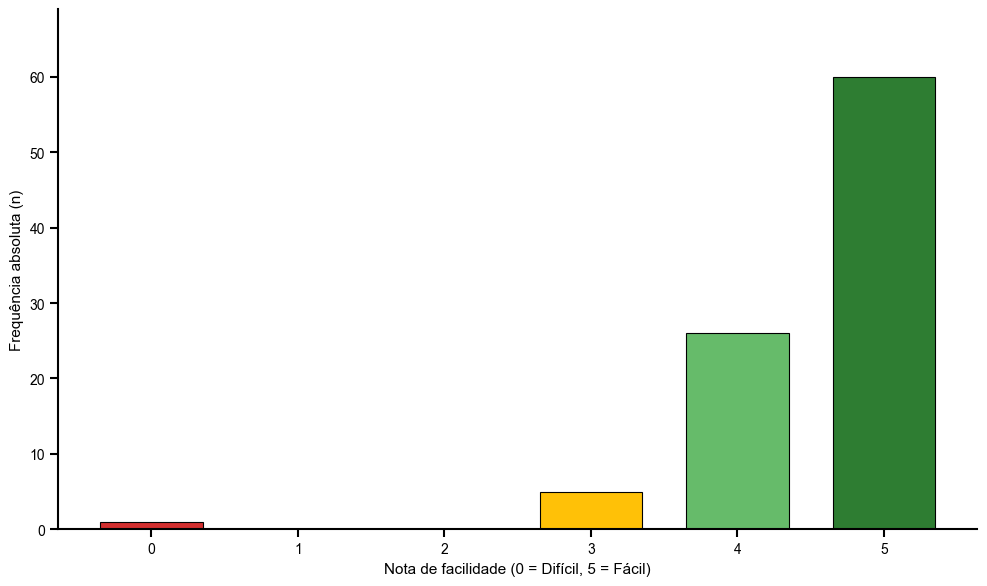

Opção 2: Gráfico de barras horizontais com percentual

Figura 8. Distribuição de notas de facilidade no processo de compra
Fonte: Elaboração própria (N=92)



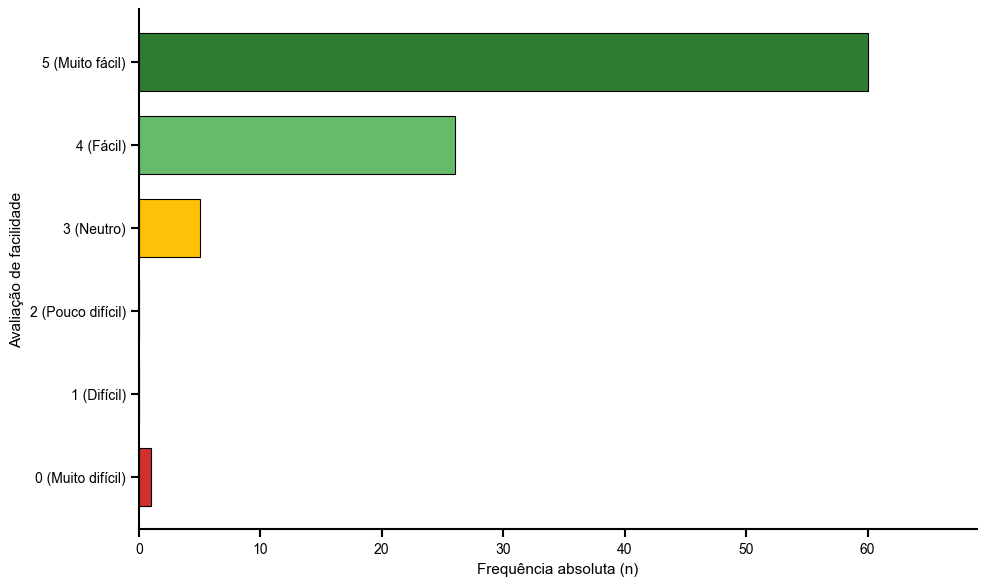

Opção 3: Gráfico de barra empilhada 100% (agregado)

Figura 9. Distribuição agregada de satisfação com a facilidade do processo de compra
Fonte: Elaboração própria (N=92)



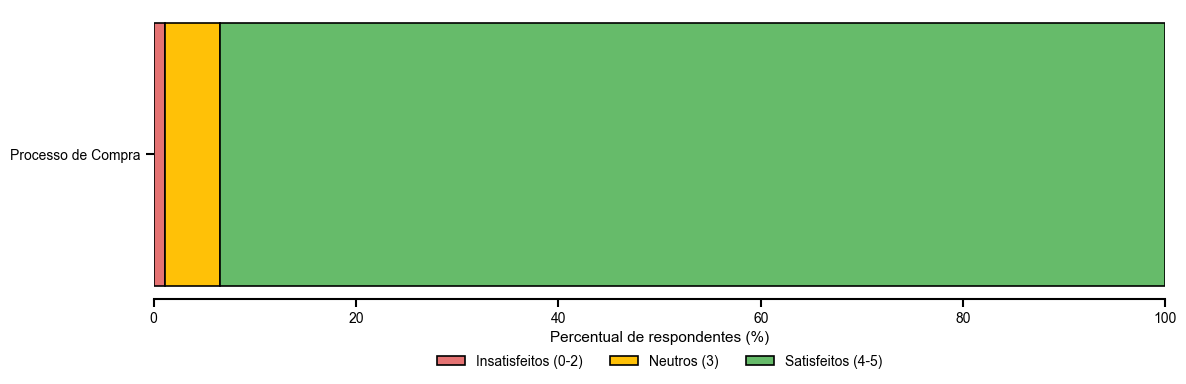

Opção 4: Gráfico de colunas com linha de média

Figura 10. Distribuição de notas de facilidade com indicador de média
Fonte: Elaboração própria (N=92)
Nota: Linha tracejada indica a média das avaliações.



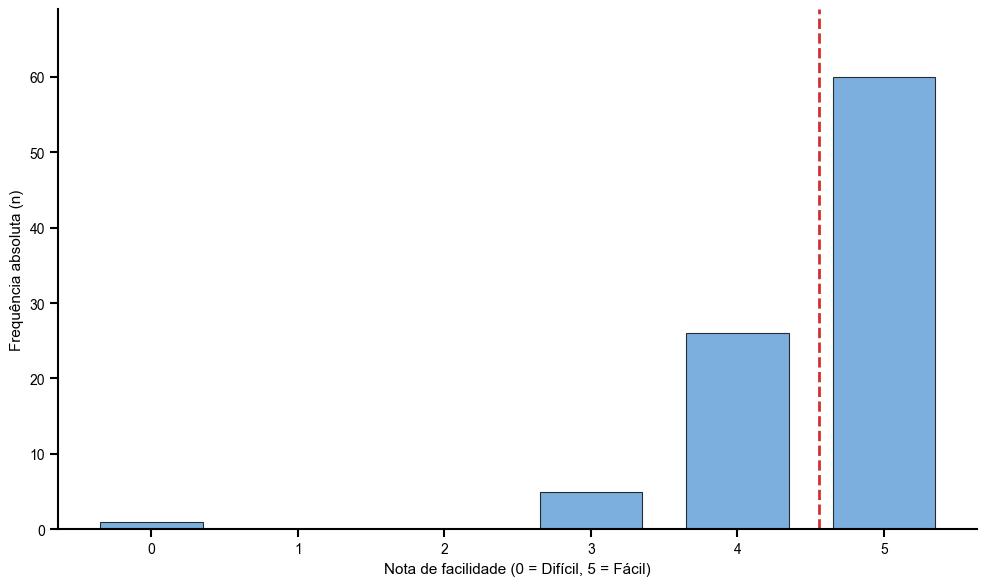


Resumo estatistico - Facilidade do processo de compra

Média: 4.55
Mediana: 5.0
Moda: 5
Desvio padrão: 0.76

Satisfação geral:
  - Insatisfeitos (0-2): 1 (1.1%)
  - Neutros (3): 5 (5.4%)
  - Satisfeitos (4-5): 86 (93.5%)

Conclusão: 93.5% dos respondentes avaliaram o processo como fácil ou muito fácil


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

distribuicao_facilidade = df_jornada_compra['facilidade_compra'].value_counts().sort_index()
n_total = len(df_jornada_compra)

notas_completas = pd.Series([0]*6, index=range(6))
for nota, count in distribuicao_facilidade.items():
    notas_completas[nota] = count

notas = notas_completas.index.tolist()
contagens = notas_completas.values.tolist()

print("="*80)
print("Opção 1: Gráfico de colunas verticais")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(10, 6))

# Paleta de cores divergente: vermelho (baixo)-> amarelo (neutro) -> verde (alto)
cores_divergentes = ['#D32F2F', '#E57373', '#FFC107', '#FFC107', '#66BB6A', '#2E7D32']

bars = ax1.bar(notas, contagens, color=cores_divergentes, width=0.7,
               edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Nota de facilidade (0 = Difícil, 5 = Fácil)', fontsize=11, color='black')
ax1.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

# Ajuste o Ylim dinamicamente ou mantenha o seu valor fixo se preferir
max_y = max(contagens) * 1.15
ax1.set_ylim(0, max_y)
# ax1.set_yticks([0, 10, 20, 30, 40, 50, 60]) # Deixe o Matplotlib decidir ou ajuste os ticks

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:  # Só mostrar se houver valor
        pass # Linha de valor comentada
        # ax1.text(bar.get_x() + bar.get_width()/2., height,
        #          f'{int(height)}',
        #          ha='center', va='bottom', fontsize=10)

ax1.set_xticks(notas)
ax1.set_xticklabels(notas)

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.05, 'Figura 7. Distribuição de notas de facilidade no processo de compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.13, 'Nota: Cores indicam nível de satisfação (vermelho = baixo, verde = alto).',
#             ha='center', fontsize=9, style='italic')

print("\nFigura 7. Distribuição de notas de facilidade no processo de compra")
print(f'Fonte: Elaboração própria (N={n_total})')
print('Nota: Cores indicam nível de satisfação (vermelho = baixo, verde = alto).\n')


plt.savefig('figura7_facilidade_compra_colunas.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 2: Gráfico de barras horizontais com percentual")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 6))

percentuais = [(c / n_total * 100) for c in contagens]

labels_notas = [
    '0 (Muito difícil)',
    '1 (Difícil)',
    '2 (Pouco difícil)',
    '3 (Neutro)',
    '4 (Fácil)',
    '5 (Muito fácil)'
]

bars = ax2.barh(labels_notas, contagens, color=cores_divergentes, height=0.7,
                edgecolor='black', linewidth=0.8)

ax2.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax2.set_ylabel('Avaliação de facilidade', fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

max_x = max(contagens) * 1.15
ax2.set_xlim(0, max_x)
# ax2.set_xticks([0, 10, 20, 30, 40, 50, 60]) # Deixe o Matplotlib decidir ou ajuste os ticks

# valores nas barras (frequência + percentual)
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width > 0:
        pass # Linha de valor comentada
        # ax2.text(width, bar.get_y() + bar.get_height()/2.,
        #          f' {int(width)} ({percentuais[i]:.1f}%)',
        #          ha='left', va='center', fontsize=10)

ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.05, 'Figura 8. Distribuição de notas de facilidade no processo de compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

print("\nFigura 8. Distribuição de notas de facilidade no processo de compra")
print(f'Fonte: Elaboração própria (N={n_total})\n')


plt.savefig('figura8_facilidade_compra_barras_horizontais.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 3: Gráfico de barra empilhada 100% (agregado)")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(12, 4))

# 3 grupos: Insatisfeitos (0-2), Neutros (3), Satisfeitos (4-5)
insatisfeitos = sum(contagens[0:3])
neutros = contagens[3]
satisfeitos = sum(contagens[4:6])

categorias = ['Processo de Compra']
valores_insatisfeitos = [(insatisfeitos / n_total) * 100]
valores_neutros = [(neutros / n_total) * 100]
valores_satisfeitos = [(satisfeitos / n_total) * 100]

# Barras empilhadas
p1 = ax3.barh(categorias, valores_insatisfeitos, color='#E57373',
              edgecolor='black', linewidth=1.2, label='Insatisfeitos (0-2)')
p2 = ax3.barh(categorias, valores_neutros, left=valores_insatisfeitos,
              color='#FFC107', edgecolor='black', linewidth=1.2, label='Neutros (3)')
p3 = ax3.barh(categorias, valores_satisfeitos,
              left=[valores_insatisfeitos[0] + valores_neutros[0]],
              color='#66BB6A', edgecolor='black', linewidth=1.2, label='Satisfeitos (4-5)')

ax3.set_xlabel('Percentual de respondentes (%)', fontsize=11, color='black')
ax3.set_xlim(0, 100)
ax3.set_xticks([0, 20, 40, 60, 80, 100])

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

for spine in ['bottom']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

# Linhas de valor comentadas
# if valores_insatisfeitos[0] > 3:
#     ax3.text(valores_insatisfeitos[0]/2, 0, f'{valores_insatisfeitos[0]:.1f}%',
#              ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# if valores_neutros[0] > 3:
#     ax3.text(valores_insatisfeitos[0] + valores_neutros[0]/2, 0, f'{valores_neutros[0]:.1f}%',
#              ha='center', va='center', fontsize=10, fontweight='bold')

# ax3.text(valores_insatisfeitos[0] + valores_neutros[0] + valores_satisfeitos[0]/2, 0,
#          f'{valores_satisfeitos[0]:.1f}%',
#          ha='center', va='center', fontsize=10, fontweight='bold', color='white')

ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,
           frameon=False, fontsize=10)

ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.20, 'Figura 9. Distribuição agregada de satisfação com a facilidade do processo de compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.25, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

print("\nFigura 9. Distribuição agregada de satisfação com a facilidade do processo de compra")
print(f'Fonte: Elaboração própria (N={n_total})\n')


plt.savefig('figura9_facilidade_compra_stacked.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 4: Gráfico de colunas com linha de média")
print("="*80)

fig4, ax4 = plt.subplots(figsize=(10, 6))

bars = ax4.bar(notas, contagens, color='#5B9BD5', width=0.7,
               edgecolor='black', linewidth=0.8, alpha=0.8)

ax4.set_xlabel('Nota de facilidade (0 = Difícil, 5 = Fácil)', fontsize=11, color='black')
ax4.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax4.grid(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax4.spines[spine].set_edgecolor('black')
    ax4.spines[spine].set_linewidth(1.5)

ax4.set_ylim(0, max(contagens) * 1.15)
# ax4.set_yticks([0, 10, 20, 30, 40, 50, 60]) # Deixe o Matplotlib decidir ou ajuste os ticks

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        pass # Linha de valor comentada
        # ax4.text(bar.get_x() + bar.get_width()/2., height,
        #          f'{int(height)}',
        #          ha='center', va='bottom', fontsize=10)

# Linha vertical indicando a média
media = df_jornada_compra['facilidade_compra'].mean()
ax4.axvline(x=media, color='#D32F2F', linestyle='--', linewidth=2,
            label=f'Média: {media:.2f}')

# Linha de valor (média) comentada
# ax4.text(media + 0.15, max(contagens) * 1.05, f'Média = {media:.2f}',
#          fontsize=10, color='#D32F2F', fontweight='bold',
#          bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#D32F2F', linewidth=1.5))

ax4.set_xticks(notas)
ax4.set_xticklabels(notas)

ax4.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.05, 'Figura 10. Distribuição de notas de facilidade com indicador de média',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.13, 'Nota: Linha tracejada indica a média das avaliações.',
#             ha='center', fontsize=9, style='italic')

print("\nFigura 10. Distribuição de notas de facilidade com indicador de média")
print(f'Fonte: Elaboração própria (N={n_total})')
print('Nota: Linha tracejada indica a média das avaliações.\n')


plt.savefig('figura10_facilidade_compra_com_media.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*80)
print("Resumo estatistico - Facilidade do processo de compra")
print("="*80)
print(f"\nMédia: {df_jornada_compra['facilidade_compra'].mean():.2f}")
print(f"Mediana: {df_jornada_compra['facilidade_compra'].median():.1f}")
print(f"Moda: {df_jornada_compra['facilidade_compra'].mode()[0]}")
print(f"Desvio padrão: {df_jornada_compra['facilidade_compra'].std():.2f}")
print(f"\nSatisfação geral:")
print(f"  - Insatisfeitos (0-2): {insatisfeitos} ({insatisfeitos/n_total*100:.1f}%)")
print(f"  - Neutros (3): {neutros} ({neutros/n_total*100:.1f}%)")
print(f"  - Satisfeitos (4-5): {satisfeitos} ({satisfeitos/n_total*100:.1f}%)")
print(f"\nConclusão: {satisfeitos/n_total*100:.1f}% dos respondentes avaliaram o processo como fácil ou muito fácil")

## Gráfico 4 - Distribuição das respostas de 0 a 5.
### Pergunta: Em uma escala de 0 a 5, qual o seu nível de satisfação geral com a experiência de compra que você teve?
### 0 = muito insatisfeito, 5 = totalmente satisfeito

Opção 1: Gráfico de colunas verticais

Figura 11. Distribuição de notas de satisfação com a experiência de compra
Fonte: Elaboração própria (N=92)
Nota: Cores indicam nível de satisfação (roxo escuro = baixo, verde = alto).



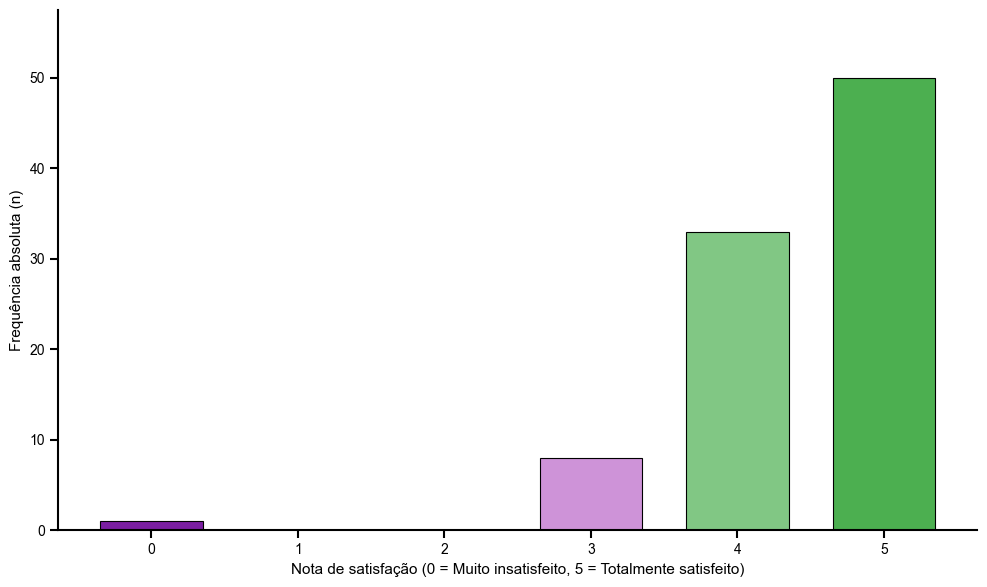

Opção 2: Gráfico de barras horizontais com percentual

Figura 12. Distribuição de notas de satisfação com a experiência de compra
Fonte: Elaboração própria (N=92)



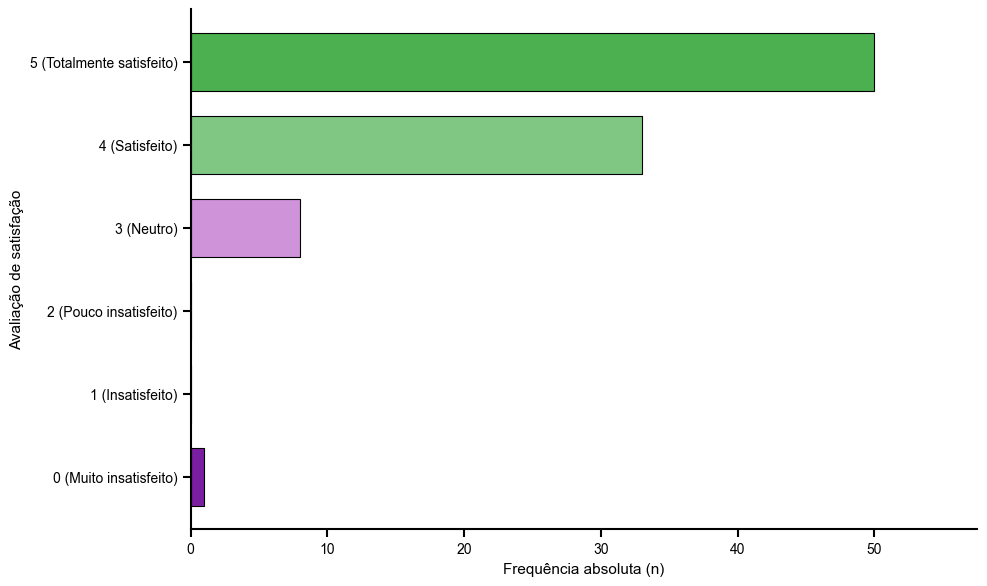

Opção 3: Gráfico de barra empilhada 100% (agregado)

Figura 13. Distribuição agregada de satisfação com a experiência de compra
Fonte: Elaboração própria (N=92)



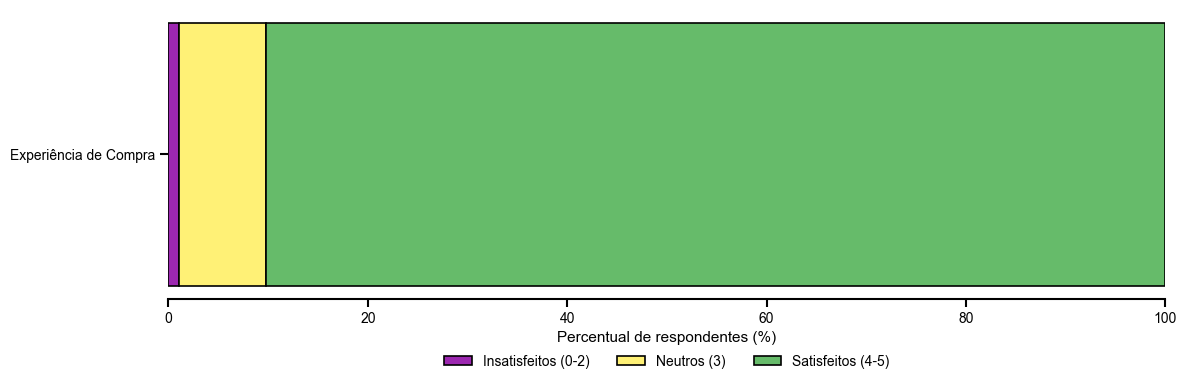

Opção 4: Gráfico comparativo entre satisfação e facilidade

Figura 14. Comparação entre satisfação geral e facilidade do processo de compra
Fonte: Elaboração própria (N=92)
Nota: Ambas as métricas apresentam distribuição concentrada nas notas altas.



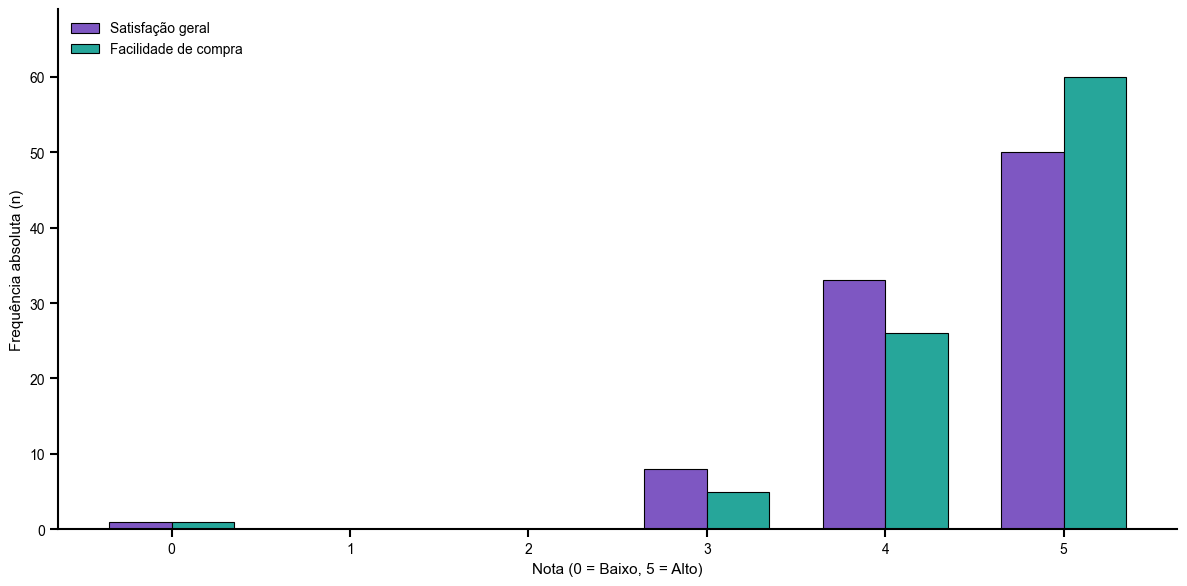


Resumo estatistico


Sastisfacao geral:
  Média: 4.41
  Mediana: 5.0
  Moda: 5
  Satisfeitos (4-5): 83 (90.2%)


Facilidade de compra:
  Média: 4.55
  Mediana: 5.0
  Moda: 5
  Satisfeitos (4-5): 86 (93.5%)


  Diferença de médias: 0.14 pontos
  Facilidade é 0.14 pontos maior que satisfação


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

distribuicao_satisfacao = df_jornada_compra['satisfacao_geral'].value_counts().sort_index()
n_total = len(df_jornada_compra)

notas_completas = pd.Series([0]*6, index=range(6))
for nota, count in distribuicao_satisfacao.items():
    notas_completas[nota] = count

notas = notas_completas.index.tolist()
contagens = notas_completas.values.tolist()

print("="*80)
print("Opção 1: Gráfico de colunas verticais")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(10, 6))

# Paleta de cores divergente: roxo escuro (baixo) -> roxo claro -> verde (alto)
cores_divergentes = ['#7B1FA2', '#9C27B0', '#BA68C8', '#CE93D8', '#81C784', '#4CAF50']

bars = ax1.bar(notas, contagens, color=cores_divergentes, width=0.7,
               edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Nota de satisfação (0 = Muito insatisfeito, 5 = Totalmente satisfeito)',
               fontsize=11, color='black')
ax1.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

# escala do eixo Y
ax1.set_ylim(0, max(contagens) * 1.15)  # 0 a 57
# ax1.set_yticks([0, 10, 20, 30, 40, 50]) # Deixe o Matplotlib decidir ou ajuste

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        pass # Linha de valor comentada
        # ax1.text(bar.get_x() + bar.get_width()/2., height,
        #          f'{int(height)}',
        #          ha='center', va='bottom', fontsize=10)

ax1.set_xticks(notas)
ax1.set_xticklabels(notas)

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.05, 'Figura 11. Distribuição de notas de satisfação com a experiência de compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.13, 'Nota: Cores indicam nível de satisfação (roxo escuro = baixo, verde = alto).',
#             ha='center', fontsize=9, style='italic')

print("\nFigura 11. Distribuição de notas de satisfação com a experiência de compra")
print(f'Fonte: Elaboração própria (N={n_total})')
print('Nota: Cores indicam nível de satisfação (roxo escuro = baixo, verde = alto).\n')


plt.savefig('figura11_satisfacao_geral_colunas.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 2: Gráfico de barras horizontais com percentual")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 6))

percentuais = [(c / n_total * 100) for c in contagens]

labels_notas = [
    '0 (Muito insatisfeito)',
    '1 (Insatisfeito)',
    '2 (Pouco insatisfeito)',
    '3 (Neutro)',
    '4 (Satisfeito)',
    '5 (Totalmente satisfeito)'
]

bars = ax2.barh(labels_notas, contagens, color=cores_divergentes, height=0.7,
                edgecolor='black', linewidth=0.8)

ax2.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax2.set_ylabel('Avaliação de satisfação', fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

ax2.set_xlim(0, max(contagens) * 1.15)
# ax2.set_xticks([0, 10, 20, 30, 40, 50]) # Deixe o Matplotlib decidir ou ajuste

for i, bar in enumerate(bars):
    width = bar.get_width()
    if width > 0:
        pass # Linha de valor comentada
        # ax2.text(width, bar.get_y() + bar.get_height()/2.,
        #          f' {int(width)} ({percentuais[i]:.1f}%)',
        #          ha='left', va='center', fontsize=10)

ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.05, 'Figura 12. Distribuição de notas de satisfação com a experiência de compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

print("\nFigura 12. Distribuição de notas de satisfação com a experiência de compra")
print(f'Fonte: Elaboração própria (N={n_total})\n')


plt.savefig('figura12_satisfacao_geral_barras_horizontais.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 3: Gráfico de barra empilhada 100% (agregado)")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(12, 4))

insatisfeitos = sum(contagens[0:3])
neutros = contagens[3]
satisfeitos = sum(contagens[4:6])

categorias = ['Experiência de Compra']
valores_insatisfeitos = [(insatisfeitos / n_total) * 100]
valores_neutros = [(neutros / n_total) * 100]
valores_satisfeitos = [(satisfeitos / n_total) * 100]

# Cores roxo-amarelo-verde
p1 = ax3.barh(categorias, valores_insatisfeitos, color='#9C27B0',
              edgecolor='black', linewidth=1.2, label='Insatisfeitos (0-2)')
p2 = ax3.barh(categorias, valores_neutros, left=valores_insatisfeitos,
              color='#FFF176', edgecolor='black', linewidth=1.2, label='Neutros (3)')
p3 = ax3.barh(categorias, valores_satisfeitos,
              left=[valores_insatisfeitos[0] + valores_neutros[0]],
              color='#66BB6A', edgecolor='black', linewidth=1.2, label='Satisfeitos (4-5)')

ax3.set_xlabel('Percentual de respondentes (%)', fontsize=11, color='black')
ax3.set_xlim(0, 100)
ax3.set_xticks([0, 20, 40, 60, 80, 100])

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

for spine in ['bottom']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

# Linhas de valor comentadas
# if valores_insatisfeitos[0] > 3:
#     ax3.text(valores_insatisfeitos[0]/2, 0, f'{valores_insatisfeitos[0]:.1f}%',
#              ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# if valores_neutros[0] > 3:
#     ax3.text(valores_insatisfeitos[0] + valores_neutros[0]/2, 0, f'{valores_neutros[0]:.1f}%',
#              ha='center', va='center', fontsize=10, fontweight='bold')

# ax3.text(valores_insatisfeitos[0] + valores_neutros[0] + valores_satisfeitos[0]/2, 0,
#          f'{valores_satisfeitos[0]:.1f}%',
#          ha='center', va='center', fontsize=10, fontweight='bold', color='white')

ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,
           frameon=False, fontsize=10)

ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.20, 'Figura 13. Distribuição agregada de satisfação com a experiência de compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.25, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

print("\nFigura 13. Distribuição agregada de satisfação com a experiência de compra")
print(f'Fonte: Elaboração própria (N={n_total})\n')


plt.savefig('figura13_satisfacao_geral_stacked.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 4: Gráfico comparativo entre satisfação e facilidade")
print("="*80)

fig4, ax4 = plt.subplots(figsize=(12, 6))

distribuicao_facilidade = df_jornada_compra['facilidade_compra'].value_counts().sort_index()
notas_facilidade = pd.Series([0]*6, index=range(6))
for nota, count in distribuicao_facilidade.items():
    notas_facilidade[nota] = count

x = np.arange(len(notas))
width = 0.35

bars1 = ax4.bar(x - width/2, notas_completas.values, width,
                label='Satisfação geral', color='#7E57C2',
                edgecolor='black', linewidth=0.8)
bars2 = ax4.bar(x + width/2, notas_facilidade.values, width,
                label='Facilidade de compra', color='#26A69A',
                edgecolor='black', linewidth=0.8)

ax4.set_xlabel('Nota (0 = Baixo, 5 = Alto)', fontsize=11, color='black')
ax4.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax4.grid(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax4.spines[spine].set_edgecolor('black')
    ax4.spines[spine].set_linewidth(1.5)

# ax4.set_ylim(0, 65) # Deixe o Matplotlib decidir ou ajuste
max_y_comp = max(max(notas_completas.values), max(notas_facilidade.values)) * 1.15
ax4.set_ylim(0, max_y_comp)
# ax4.set_yticks([0, 10, 20, 30, 40, 50, 60]) # Deixe o Matplotlib decidir ou ajuste

for bar in bars1:
    height = bar.get_height()
    if height > 0:
        pass # Linha de valor comentada
        # ax4.text(bar.get_x() + bar.get_width()/2., height,
        #          f'{int(height)}',
        #          ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        pass # Linha de valor comentada
        # ax4.text(bar.get_x() + bar.get_width()/2., height,
        #          f'{int(height)}',
        #          ha='center', va='bottom', fontsize=9)

ax4.set_xticks(x)
ax4.set_xticklabels(notas)

ax4.legend(loc='upper left', frameon=False, fontsize=10)

ax4.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# Linhas de Figura/Fonte comentadas
# plt.figtext(0.5, -0.05, 'Figura 14. Comparação entre satisfação geral e facilidade do processo de compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.13, 'Nota: Ambas as métricas apresentam distribuição concentrada nas notas altas.',
#             ha='center', fontsize=9, style='italic')

print("\nFigura 14. Comparação entre satisfação geral e facilidade do processo de compra")
print(f'Fonte: Elaboração própria (N={n_total})')
print('Nota: Ambas as métricas apresentam distribuição concentrada nas notas altas.\n')


plt.savefig('figura14_comparativo_satisfacao_facilidade.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("Resumo estatistico")
print("="*80)
print("\n")
print("Sastisfacao geral:")
print(f"  Média: {df_jornada_compra['satisfacao_geral'].mean():.2f}")
print(f"  Mediana: {df_jornada_compra['satisfacao_geral'].median():.1f}")
print(f"  Moda: {df_jornada_compra['satisfacao_geral'].mode()[0]}")
print(f"  Satisfeitos (4-5): {satisfeitos} ({satisfeitos/n_total*100:.1f}%)")
print("\n")
print("Facilidade de compra:")
print(f"  Média: {df_jornada_compra['facilidade_compra'].mean():.2f}")
print(f"  Mediana: {df_jornada_compra['facilidade_compra'].median():.1f}")
print(f"  Moda: {df_jornada_compra['facilidade_compra'].mode()[0]}")
insatisfeitos_fac = df_jornada_compra[df_jornada_compra['facilidade_compra'] <= 2].shape[0]
neutros_fac = df_jornada_compra[df_jornada_compra['facilidade_compra'] == 3].shape[0]
satisfeitos_fac = df_jornada_compra[df_jornada_compra['facilidade_compra'] >= 4].shape[0]
print(f"  Satisfeitos (4-5): {satisfeitos_fac} ({satisfeitos_fac/n_total*100:.1f}%)")
print("\n")
diff_media = df_jornada_compra['facilidade_compra'].mean() - df_jornada_compra['satisfacao_geral'].mean()
print(f"  Diferença de médias: {diff_media:.2f} pontos")
print(f"  Facilidade é {diff_media:.2f} pontos {'maior' if diff_media > 0 else 'menor'} que satisfação")

## Gráfico 5

Opção 1: Gráfico de pizza
Figura 15. Proporção de clientes que compraram com auxílio de consultor
Fonte: Elaboração própria (N=92)
Nota: Fatia "Sim" destacada para evidenciar o segmento que utiliza consultores.


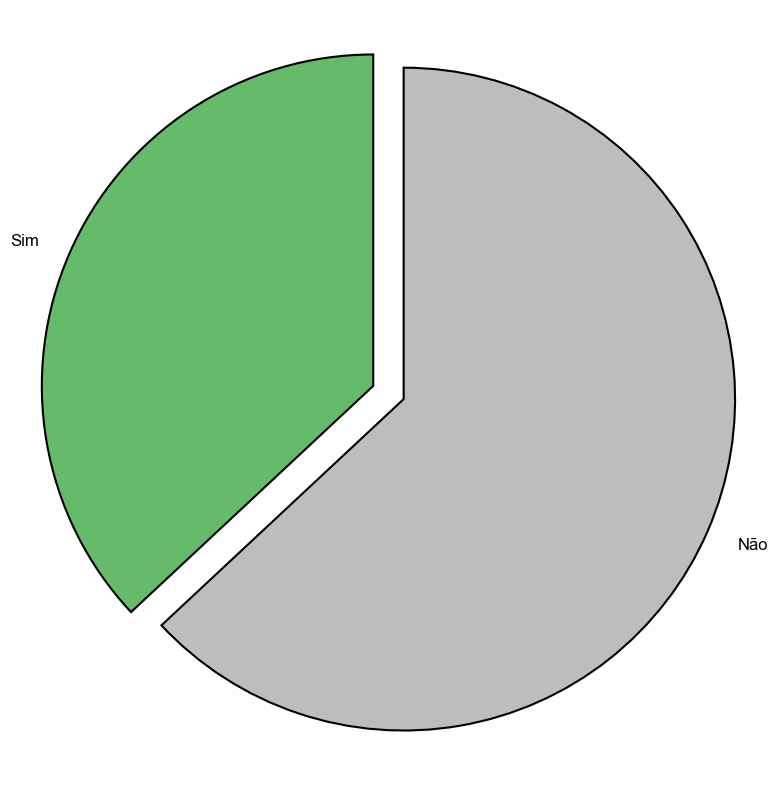

Opção 2: Gráfico de colunas verticais

Figura 16. Distribuição de clientes por uso de consultor
Fonte: Elaboração própria (N=92)


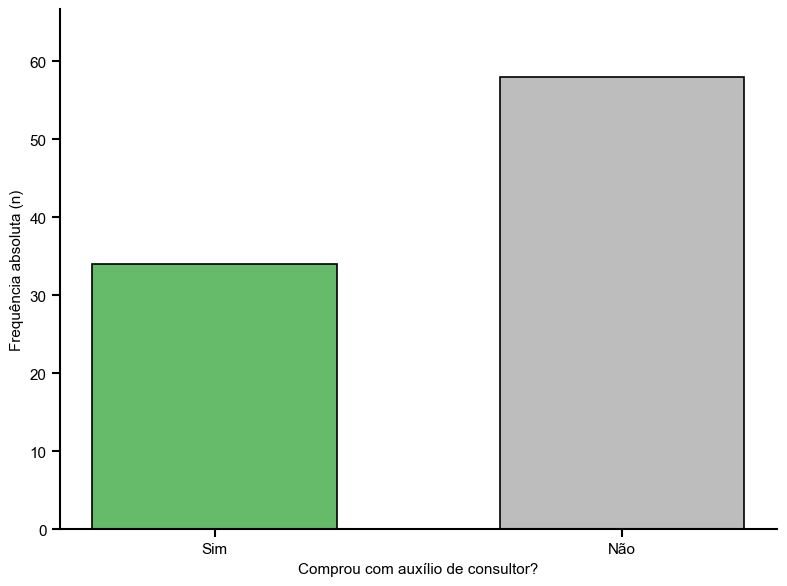

Opção 3: Gráfico de barra horizontal 100%
Figura 17. Proporção de clientes que utilizam auxílio de consultor
Fonte: Elaboração própria (N=92)


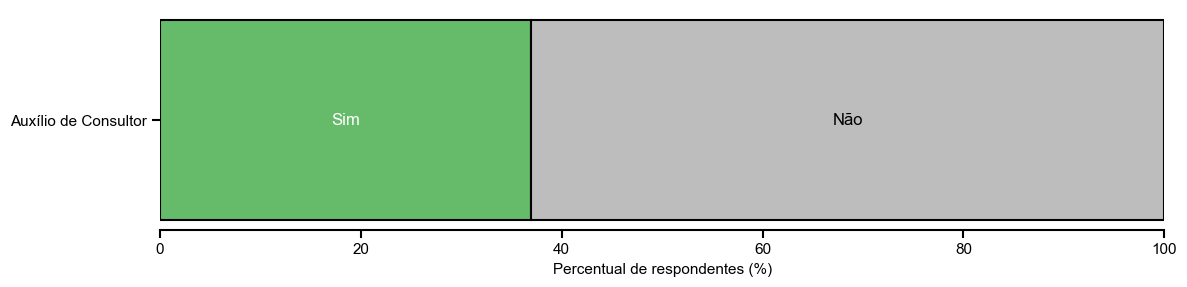

Opção 4: Gráfico de waffle (100 quadrados = 100%)

Figura 18. Representação proporcional de clientes por uso de consultor (waffle chart)
Fonte: Elaboração própria (N=92)
Nota: Cada quadrado representa 1% dos respondentes.


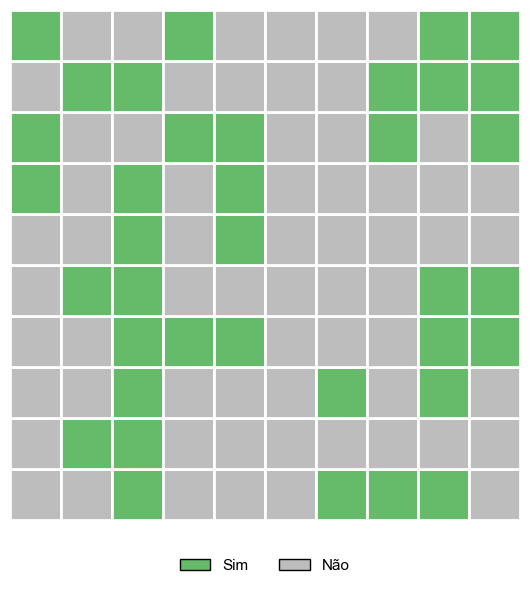


Resumo estatistico  de compra com consultor

Sim (com consultor): 34 (36.96%)
Não (sem consultor): 58 (63.04%)

Total de respondentes: 92
Razão Não/Sim: 1.71x

Conclusão: 63.0% dos clientes fazem compras sem auxílio de consultor (autoatendimento)
Oportunidade: 37.0% ainda utilizam consultores, indicando demanda por atendimento personalizado


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

distribuicao_consultor = df_jornada_compra['comprou_com_consultor'].value_counts()
n_total = len(df_jornada_compra)

respostas = ['Sim', 'Não']
contagens = [
    distribuicao_consultor.get('Sim', 0),
    distribuicao_consultor.get('Não', 0)
]
percentuais = [(c / n_total * 100) for c in contagens]

print("="*80)
print("Opção 1: Gráfico de pizza")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(8, 8))

# Cores: Verde (Sim) e Cinza (Não)
cores = ['#66BB6A', '#BDBDBD']

# fatia "Sim" para destaque
explode = (0.1, 0)

wedges, texts = ax1.pie(
    contagens,
    explode=explode,
    labels=respostas,
    colors=cores,
    autopct=None,
    startangle=90,
    textprops={'fontsize': 12, 'fontname': 'Arial', 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# for autotext in autotexts:
#     autotext.set_color('white')
#     autotext.set_fontsize(14)
#     autotext.set_weight('bold')

ax1.axis('equal')

plt.tight_layout()

print('Figura 15. Proporção de clientes que compraram com auxílio de consultor')
print('Fonte: Elaboração própria (N={})'.format(n_total))
print('Nota: Fatia "Sim" destacada para evidenciar o segmento que utiliza consultores.')

# plt.figtext(0.5, -0.02, 'Figura 15. Proporção de clientes que compraram com auxílio de consultor',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.07, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.10, 'Nota: Fatia "Sim" destacada para evidenciar o segmento que utiliza consultores.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura15_consultor_pizza.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 2: Gráfico de colunas verticais")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(8, 6))

bars = ax2.bar(respostas, contagens, color=cores, width=0.6,
               edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Comprou com auxílio de consultor?', fontsize=11, color='black')
ax2.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

ax2.set_ylim(0, max(contagens) * 1.15)
ax2.set_yticks([0, 10, 20, 30, 40, 50, 60])

# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}\n({percentuais[i]:.1f}%)',
#              ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.tick_params(axis='both', which='major', labelsize=11,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('\nFigura 16. Distribuição de clientes por uso de consultor')
print('Fonte: Elaboração própria (N={})'.format(n_total))

# plt.figtext(0.5, -0.05, 'Figura 16. Distribuição de clientes por uso de consultor',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura16_consultor_colunas.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 3: Gráfico de barra horizontal 100%")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(12, 3))

categorias = ['Auxílio de Consultor']

p1 = ax3.barh(categorias, percentuais[0], color=cores[0],
              edgecolor='black', linewidth=1.5, label='Sim')
p2 = ax3.barh(categorias, percentuais[1], left=percentuais[0],
              color=cores[1], edgecolor='black', linewidth=1.5, label='Não')

ax3.set_xlabel('Percentual de respondentes (%)', fontsize=11, color='black')
ax3.set_xlim(0, 100)
ax3.set_xticks([0, 20, 40, 60, 80, 100])

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

for spine in ['bottom']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

ax3.text(percentuais[0]/2, 0,
         f'Sim',
         ha='center', va='center', fontsize=12, fontweight='bold', color='white')

ax3.text(percentuais[0] + percentuais[1]/2, 0,
         f'Não',
         ha='center', va='center', fontsize=12, fontweight='bold', color='black')

# ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2,
#            frameon=False, fontsize=11)

ax3.tick_params(axis='both', which='major', labelsize=11,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 17. Proporção de clientes que utilizam auxílio de consultor')
print('Fonte: Elaboração própria (N={})'.format(n_total))

# plt.figtext(0.5, -0.25, 'Figura 17. Proporção de clientes que utilizam auxílio de consultor',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.30, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura17_consultor_stacked.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 4: Gráfico de waffle (100 quadrados = 100%)")
print("="*80)

fig4 = plt.figure(figsize=(10, 6))
ax4 = fig4.add_subplot(111)

total_quadrados = 100
quadrados_sim = int(round(percentuais[0]))
quadrados_nao = total_quadrados - quadrados_sim

rows = 10
cols = 10
waffle_data = np.array(['Não'] * quadrados_nao + ['Sim'] * quadrados_sim)
np.random.shuffle(waffle_data)  # Misturar para distribuição visual
waffle_matrix = waffle_data.reshape(rows, cols)

color_map = {'Sim': cores[0], 'Não': cores[1]}

# waffle
for i in range(rows):
    for j in range(cols):
        cor = color_map[waffle_matrix[i, j]]
        ax4.add_patch(plt.Rectangle((j, i), 1, 1,
                                    facecolor=cor,
                                    edgecolor='white',
                                    linewidth=2))

ax4.set_xlim(0, cols)
ax4.set_ylim(0, rows)
ax4.set_aspect('equal')
ax4.axis('off')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cores[0], edgecolor='black', label=f'Sim'),
    Patch(facecolor=cores[1], edgecolor='black', label=f'Não')
]
ax4.legend(handles=legend_elements, loc='upper center',
           bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False, fontsize=11)

plt.tight_layout()

print('\nFigura 18. Representação proporcional de clientes por uso de consultor (waffle chart)')
print('Fonte: Elaboração própria (N={})'.format(n_total))
print('Nota: Cada quadrado representa 1% dos respondentes.')


# plt.figtext(0.5, 0.02, 'Figura 18. Representação proporcional de clientes por uso de consultor (waffle chart)',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.03, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.06, 'Nota: Cada quadrado representa 1% dos respondentes.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura18_consultor_waffle.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*80)
print("Resumo estatistico  de compra com consultor")
print("="*80)
print(f"\nSim (com consultor): {contagens[0]} ({percentuais[0]:.2f}%)")
print(f"Não (sem consultor): {contagens[1]} ({percentuais[1]:.2f}%)")
print(f"\nTotal de respondentes: {n_total}")
print(f"Razão Não/Sim: {contagens[1]/contagens[0]:.2f}x")
print("\nConclusão: {:.1f}% dos clientes fazem compras sem auxílio de consultor (autoatendimento)".format(percentuais[1]))
print("Oportunidade: {:.1f}% ainda utilizam consultores, indicando demanda por atendimento personalizado".format(percentuais[0]))


## Extra - Gráficos que não foram mapeados

Gráfico 1: Local de Finalização da Compra


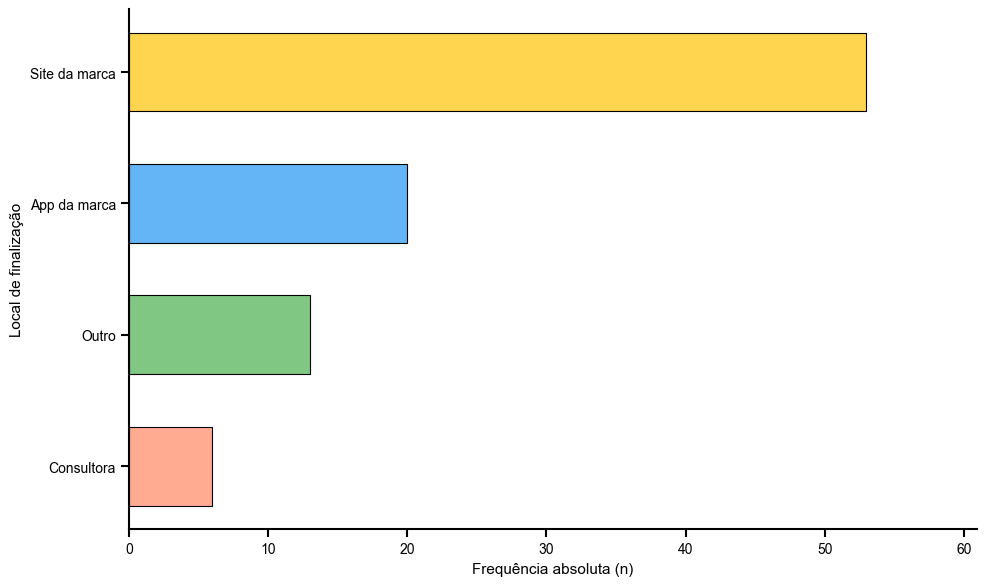

Gráfico 2: Transição entre canais (Sim/Não)


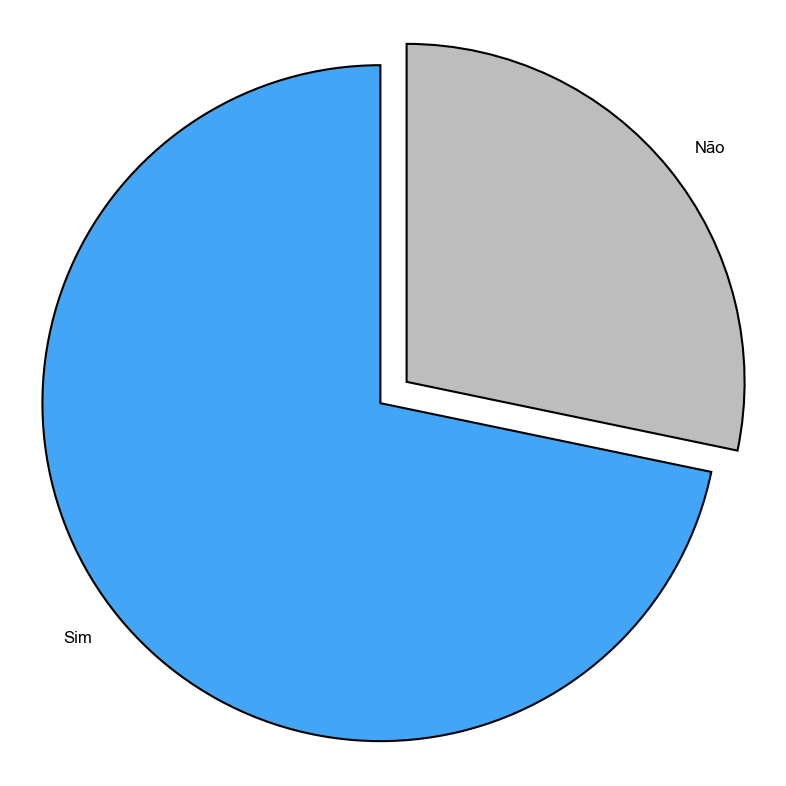

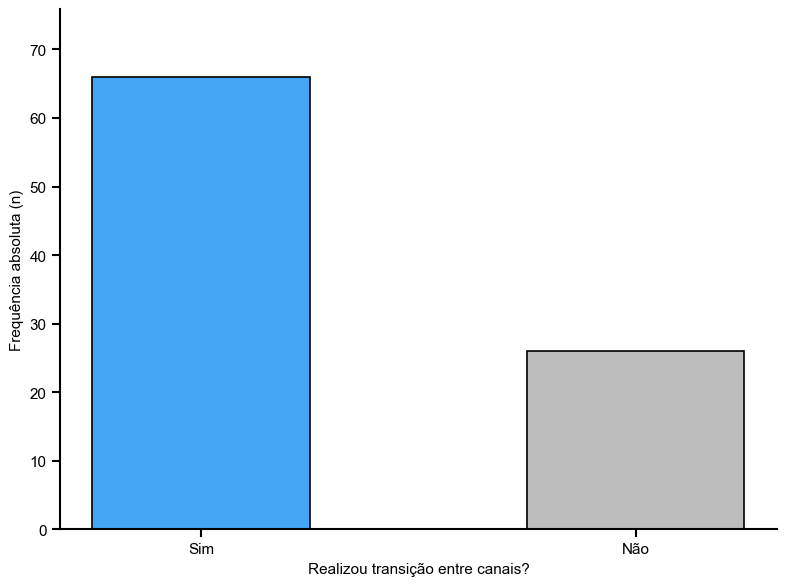

Gráfico 3: Tipos de transição entre canais (condicional)


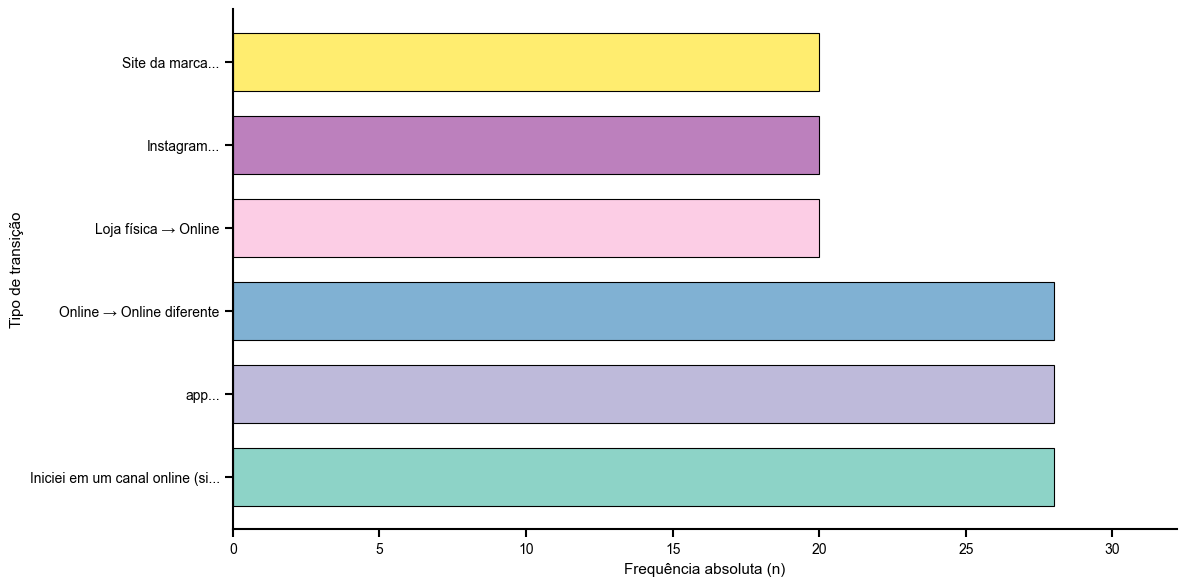

Gráfico 4: Canal preferido para contato com consultor (condicional)


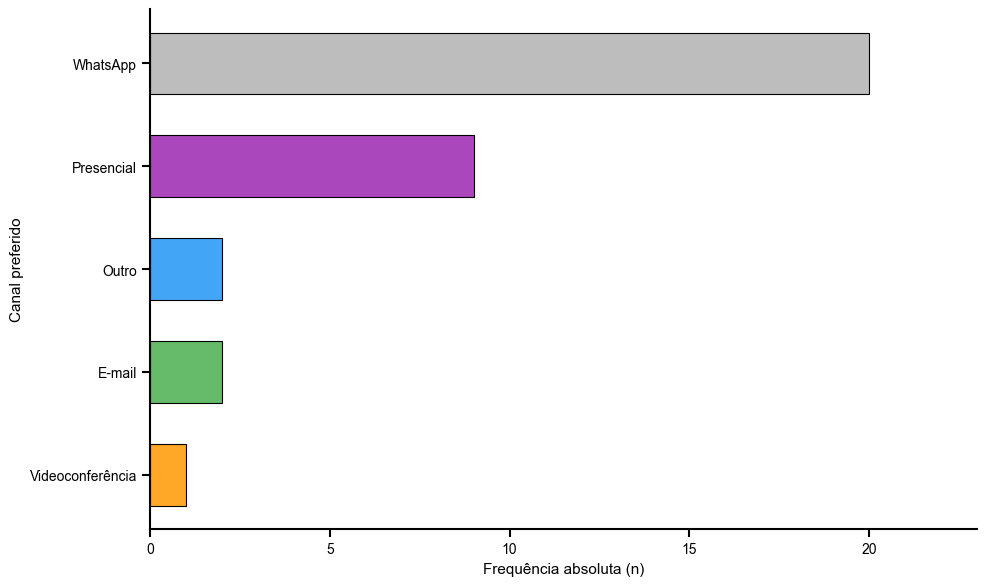

Gráfico 5: Suficiência de informações no canal online (condicional)


/tmp/ipython-input-2556072935.py:374: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(respostas_info, rotation=20, ha='right')


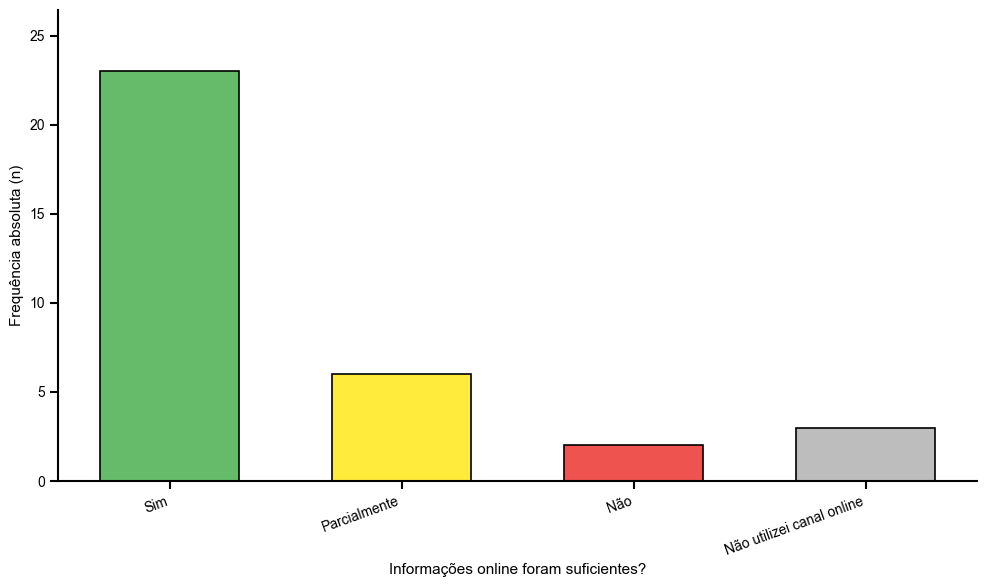

Gráfico 6: Preferência para compras futuras (condicional)


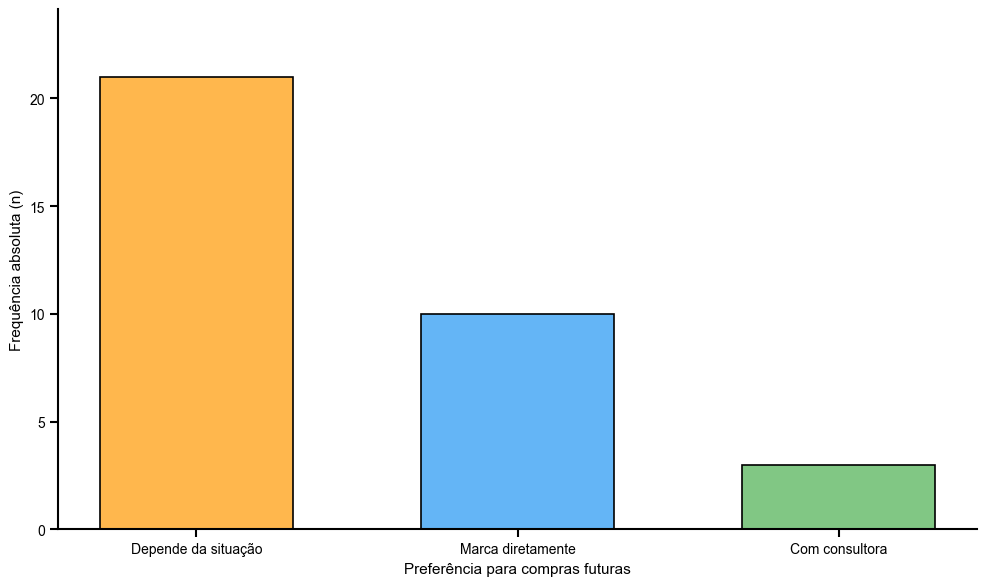


Resumo estatistico - Colunas q nao foram mapeadas

Local de finalização:
  - Site da marca: 53 (maioria)
  - App da marca: 20

Transição entre canais:
  - Realizaram transição: 66 (71.7%)

Canal preferido (consultores):
  - WhatsApp: 20 (canal dominante)

Preferência futura:
  - Depende da situação: 21 (resposta mais comum)


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

n_total = len(df_jornada_compra)

print("="*80)
print("Gráfico 1: Local de Finalização da Compra")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(10, 6))

dist_local = df_jornada_compra['local_finalizacao'].value_counts().sort_values(ascending=True)
locais = dist_local.index.tolist()
contagens_local = dist_local.values.tolist()

# abreviacao de rotulos longos
locais_curtos = []
for local in locais:
    if 'consultora' in local.lower():
        locais_curtos.append('Consultora')
    elif 'site' in local.lower():
        locais_curtos.append('Site da marca')
    elif 'aplicativo' in local.lower() or 'app' in local.lower():
        locais_curtos.append('App da marca')
    else:
        locais_curtos.append('Outro')

cores_local = ['#FFAB91', '#81C784', '#64B5F6', '#FFD54F']

bars = ax1.barh(locais_curtos, contagens_local, color=cores_local, height=0.6,
                edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax1.set_ylabel('Local de finalização', fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

ax1.set_xlim(0, max(contagens_local) * 1.15)

for i, bar in enumerate(bars):
    width = bar.get_width()
    pct = (width / n_total) * 100
    # ax1.text(width, bar.get_y() + bar.get_height()/2.,
    #          f' {int(width)} ({pct:.1f}%)',
    #          ha='left', va='center', fontsize=10)
    # print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# plt.figtext(0.5, -0.05, 'Figura 19. Distribuição do local de finalização da compra',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura19_local_finalizacao.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Gráfico 2: Transição entre canais (Sim/Não)")
print("="*80)

fig2a, ax2a = plt.subplots(figsize=(8, 8))

dist_transicao = df_jornada_compra['transicao_canais'].value_counts()
respostas_trans = dist_transicao.index.tolist()
contagens_trans = dist_transicao.values.tolist()

if 'Sim' in respostas_trans:
    idx_sim = respostas_trans.index('Sim')
    idx_nao = respostas_trans.index('Não')
    respostas_trans = ['Sim', 'Não']
    contagens_trans = [contagens_trans[idx_sim], contagens_trans[idx_nao]]

cores_trans = ['#42A5F5', '#BDBDBD']
explode = (0.1, 0)

wedges, texts = ax2a.pie(
    contagens_trans,
    explode=explode,
    labels=respostas_trans,
    colors=cores_trans,
    # autopct='%1.1f%%',
    # print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# for autotext in autotexts:
#     autotext.set_color('white')
#     autotext.set_fontsize(14)
#     autotext.set_weight('bold')
# print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")

ax2a.axis('equal')

plt.tight_layout()

# plt.figtext(0.5, -0.02, 'Figura 20. Proporção de clientes que realizaram transição entre canais',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.07, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.10, 'Nota: Transição = Iniciar compra em um canal e finalizar em outro.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura20_transicao_canais_pizza.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


fig2b, ax2b = plt.subplots(figsize=(8, 6))

bars = ax2b.bar(respostas_trans, contagens_trans, color=cores_trans, width=0.5,
                edgecolor='black', linewidth=1.2)

ax2b.set_xlabel('Realizou transição entre canais?', fontsize=11, color='black')
ax2b.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax2b.grid(False)
ax2b.spines['top'].set_visible(False)
ax2b.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2b.spines[spine].set_edgecolor('black')
    ax2b.spines[spine].set_linewidth(1.5)

ax2b.set_ylim(0, max(contagens_trans) * 1.15)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height / n_total) * 100
    # ax2b.text(bar.get_x() + bar.get_width()/2., height,
    #           f'{int(height)}\n({pct:.1f}%)',
    #           ha='center', va='bottom', fontsize=11, fontweight='bold')
    # print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")

ax2b.tick_params(axis='both', which='major', labelsize=11,
                 width=1.5, length=6, color='black')

plt.tight_layout()

# plt.figtext(0.5, -0.05, 'Figura 21. Distribuição de clientes por transição entre canais',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total})',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura21_transicao_canais_colunas.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Gráfico 3: Tipos de transição entre canais (condicional)")
print("="*80)

# filtrando aq apenas quem respondeu Sim
df_com_transicao = df_jornada_compra[df_jornada_compra['transicao_canais'] == 'Sim']

todas_transicoes = []
for valor in df_com_transicao['canais_transicao'].dropna():
    opcoes = [opt.strip() for opt in str(valor).split(',')]
    todas_transicoes.extend(opcoes)

contagem_transicoes = Counter(todas_transicoes)

# simplificacao de nomes longos (pode renomear se quiser)
transicoes_simplificadas = {}
for trans, count in contagem_transicoes.most_common(6):  # Top 6
    if 'online' in trans.lower() and 'finalizei com outro' in trans.lower():
        transicoes_simplificadas['Online → Online diferente'] = count
    elif 'loja física' in trans.lower() and 'finalizei online' in trans.lower():
        transicoes_simplificadas['Loja física → Online'] = count
    elif 'rede social' in trans.lower() and 'whatsapp' in trans.lower():
        transicoes_simplificadas['Rede social → WhatsApp'] = count
    elif 'marca' in trans.lower() and 'consultora' in trans.lower():
        transicoes_simplificadas['Marca → Consultora'] = count
    elif 'consultora' in trans.lower() and 'marca' in trans.lower():
        transicoes_simplificadas['Consultora → Marca'] = count
    elif 'outra' in trans.lower():
        transicoes_simplificadas['Outra situação'] = count
    else:
        transicoes_simplificadas[trans[:30] + '...'] = count

fig3, ax3 = plt.subplots(figsize=(12, 6))

tipos_trans = list(transicoes_simplificadas.keys())
contagens_tipos = list(transicoes_simplificadas.values())

cores_tipos = plt.cm.Set3(np.linspace(0, 1, len(tipos_trans)))

bars = ax3.barh(tipos_trans, contagens_tipos, color=cores_tipos, height=0.7,
                edgecolor='black', linewidth=0.8)

ax3.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax3.set_ylabel('Tipo de transição', fontsize=11, color='black')

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

ax3.set_xlim(0, max(contagens_tipos) * 1.15)

for i, bar in enumerate(bars):
    width = bar.get_width()
    pct = (width / len(df_com_transicao)) * 100
    # ax3.text(width, bar.get_y() + bar.get_height()/2.,
    #          f' {int(width)} ({pct:.1f}%)',
    #          ha='left', va='center', fontsize=9)
    # print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")

ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# plt.figtext(0.5, -0.03, 'Figura 22. Tipos de transição entre canais mais frequentes',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.08, f'Fonte: Elaboração própria (N={len(df_com_transicao)} clientes que realizaram transição)',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura22_tipos_transicao.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Gráfico 4: Canal preferido para contato com consultor (condicional)")
print("="*80)

df_com_consultor = df_jornada_compra[df_jornada_compra['comprou_com_consultor'] == 'Sim']

dist_canal_pref = df_com_consultor['canal_preferencia_consultor'].value_counts().sort_values(ascending=True)

fig4, ax4 = plt.subplots(figsize=(10, 6))

canais_pref = dist_canal_pref.index.tolist()
contagens_pref = dist_canal_pref.values.tolist()

canais_pref_curtos = []
for canal in canais_pref:
    if 'whatsapp' in canal.lower():
        canais_pref_curtos.append('WhatsApp')
    elif 'presencial' in canal.lower():
        canais_pref_curtos.append('Presencial')
    elif 'videoconferência' in canal.lower() or 'video' in canal.lower():
        canais_pref_curtos.append('Videoconferência')
    elif 'e-mail' in canal.lower():
        canais_pref_curtos.append('E-mail')
    else:
        canais_pref_curtos.append('Outro')

cores_pref = ['#FFA726', '#66BB6A', '#42A5F5', '#AB47BC', '#BDBDBD'][:len(canais_pref)]

bars = ax4.barh(canais_pref_curtos, contagens_pref, color=cores_pref, height=0.6,
                edgecolor='black', linewidth=0.8)

ax4.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax4.set_ylabel('Canal preferido', fontsize=11, color='black')

ax4.grid(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax4.spines[spine].set_edgecolor('black')
    ax4.spines[spine].set_linewidth(1.5)

ax4.set_xlim(0, max(contagens_pref) * 1.15)

for i, bar in enumerate(bars):
    width = bar.get_width()
    pct = (width / len(df_com_consultor)) * 100
    # ax4.text(width, bar.get_y() + bar.get_height()/2.,
    #          f' {int(width)} ({pct:.1f}%)',
    #          ha='left', va='center', fontsize=10)
    # print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")

ax4.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# plt.figtext(0.5, -0.05, 'Figura 23. Canal preferido para interação com consultor',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={len(df_com_consultor)} clientes que compraram com consultor)',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura23_canal_preferencia_consultor.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Gráfico 5: Suficiência de informações no canal online (condicional)")
print("="*80)

dist_info = df_com_consultor['info_online_suficiente'].value_counts()

# ordenacao: Sim, Parcialmente, Não, Não utilizei
ordem_info = ['Sim', 'Parcialmente', 'Não', 'Não utilizei canal online']
respostas_info = []
contagens_info = []
for resposta in ordem_info:
    if resposta in dist_info.index:
        respostas_info.append(resposta)
        contagens_info.append(dist_info[resposta])

fig5, ax5 = plt.subplots(figsize=(10, 6))

# Verde (Sim), Amarelo (Parcial), Vermelho (Não), Cinza (Não utilizou)
cores_info = ['#66BB6A', '#FFEB3B', '#EF5350', '#BDBDBD'][:len(respostas_info)]

bars = ax5.bar(respostas_info, contagens_info, color=cores_info, width=0.6,
               edgecolor='black', linewidth=1.2)

ax5.set_xlabel('Informações online foram suficientes?', fontsize=11, color='black')
ax5.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax5.grid(False)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax5.spines[spine].set_edgecolor('black')
    ax5.spines[spine].set_linewidth(1.5)

ax5.set_ylim(0, max(contagens_info) * 1.15)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height / len(df_com_consultor)) * 100
    # ax5.text(bar.get_x() + bar.get_width()/2., height,
    #          f'{int(height)}\n({pct:.1f}%)',
    #          ha='center', va='bottom', fontsize=10, fontweight='bold')
    # print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")

ax5.set_xticklabels(respostas_info, rotation=20, ha='right')

ax5.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# plt.figtext(0.5, -0.10, 'Figura 24. Avaliação da suficiência de informações no canal online',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.15, f'Fonte: Elaboração própria (N={len(df_com_consultor)} clientes que compraram com consultor)',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura24_info_online_suficiente.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Gráfico 6: Preferência para compras futuras (condicional)")
print("="*80)

dist_pref_futura = df_com_consultor['preferencia_futura'].value_counts()

fig6, ax6 = plt.subplots(figsize=(10, 6))

prefs = dist_pref_futura.index.tolist()
contagens_pref_fut = dist_pref_futura.values.tolist()

prefs_curtos = []
for pref in prefs:
    if 'depende' in pref.lower():
        prefs_curtos.append('Depende da situação')
    elif 'diretamente' in pref.lower():
        prefs_curtos.append('Marca diretamente')
    else:
        prefs_curtos.append('Com consultora')

cores_pref_fut = ['#FFB74D', '#64B5F6', '#81C784'][:len(prefs)]

bars = ax6.bar(prefs_curtos, contagens_pref_fut, color=cores_pref_fut, width=0.6,
               edgecolor='black', linewidth=1.2)

ax6.set_xlabel('Preferência para compras futuras', fontsize=11, color='black')
ax6.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax6.grid(False)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax6.spines[spine].set_edgecolor('black')
    ax6.spines[spine].set_linewidth(1.5)

ax6.set_ylim(0, max(contagens_pref_fut) * 1.15)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height / len(df_com_consultor)) * 100
    # ax6.text(bar.get_x() + bar.get_width()/2., height,
    #          f'{int(height)}\n({pct:.1f}%)',
    #          ha='center', va='bottom', fontsize=11, fontweight='bold')
    # print("""plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 11
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['axes.edgecolor'] = 'black'""")

ax6.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

# plt.figtext(0.5, -0.05, 'Figura 25. Preferência de canal para compras futuras',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={len(df_com_consultor)} clientes que compraram com consultor)',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura25_preferencia_futura.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*80)
print("Resumo estatistico - Colunas q nao foram mapeadas")
print("="*80)
print("\nLocal de finalização:")
print(f"  - Site da marca: {dist_local.get('Diretamente pelo site da marca', 0)} (maioria)")
print(f"  - App da marca: {dist_local.get('Aplicativo da marca', 0)}")
print("\nTransição entre canais:")
print(f"  - Realizaram transição: {contagens_trans[0]} ({contagens_trans[0]/n_total*100:.1f}%)")
print("\nCanal preferido (consultores):")
print(f"  - WhatsApp: {dist_canal_pref.get('WhatsApp', 0)} (canal dominante)")
print("\nPreferência futura:")
print(f"  - Depende da situação: {dist_pref_futura.get('Depende da situação ou produto', 0)} (resposta mais comum)")


# Seção 3 - Gráficos da Jornada de Compra vista pelas Consultoras

## Gráfico 1 - Frequencia de cada canal principal.

Opção 1: Gráfico de barras horizontais
Figura 26. Canal principal de comunicação utilizado pelas consultoras
Fonte: Elaboração própria (N=42 consultoras)
Nota: WhatsApp representa 73,8% das interações principal-cliente.


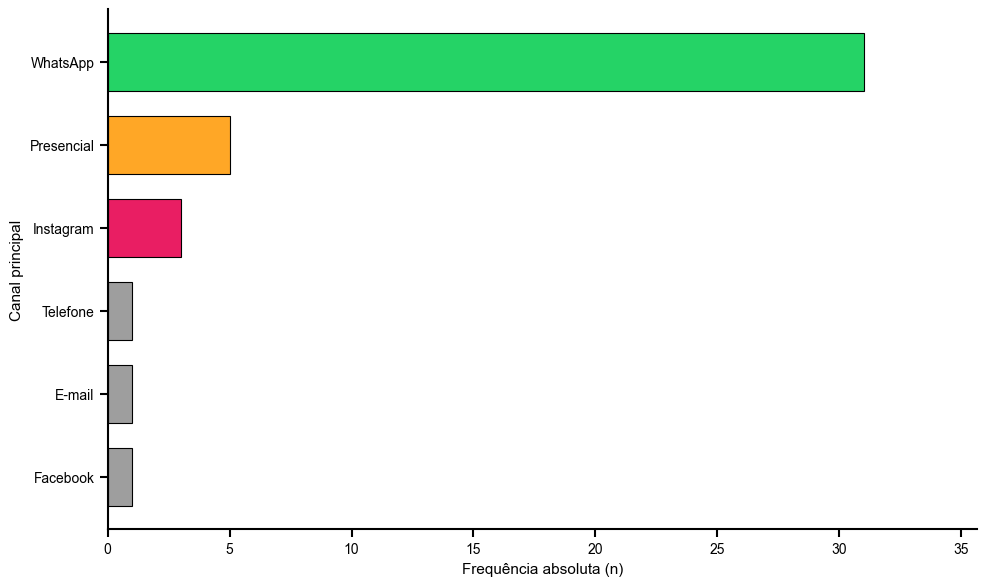

Opção 2: Gráfico de colunas verticais com destaque
Figura 27. Frequência de uso dos canais de comunicação pelas consultoras
Fonte: Elaboração própria (N=42 consultoras)


/tmp/ipython-input-1539895531.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(canais_ord, rotation=30, ha='right')


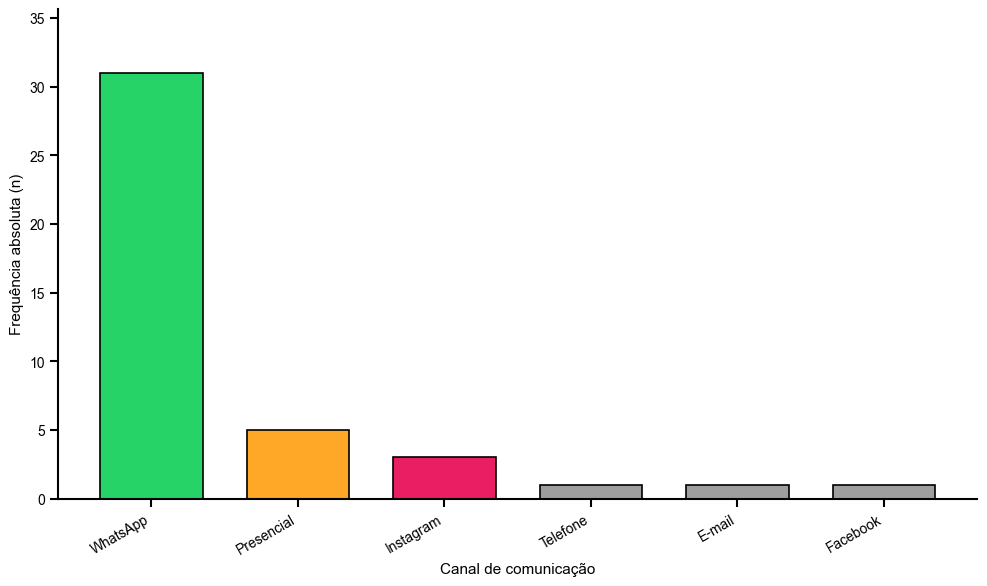

Opção 3: Gráfico de pizza
Figura 28. Proporção de canais principais utilizados pelas consultoras
Fonte: Elaboração própria (N=42 consultoras)
Nota: WhatsApp explodido para destacar sua dominância absoluta (73,8%).


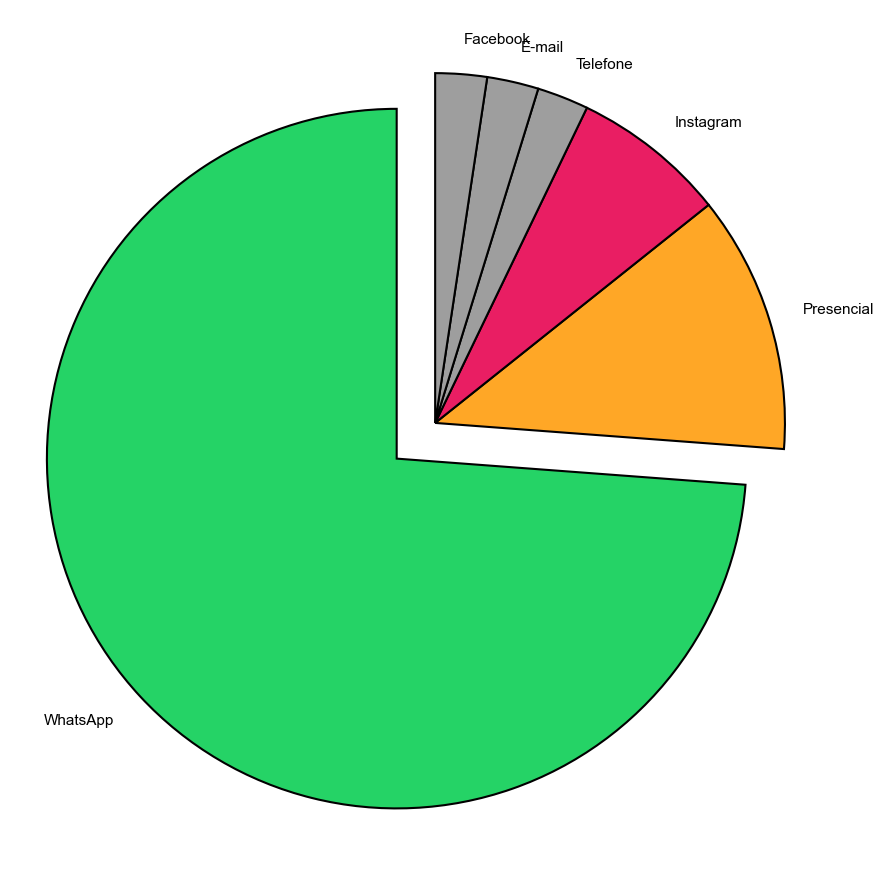

Opção 4: Gráfico híbrido (barras + linha acumulada)
Figura 29. Distribuição e concentração acumulada dos canais de comunicação
Fonte: Elaboração própria (N=42 consultoras)
Nota: Linha vermelha mostra que WhatsApp + Presencial representam 85,7% do total.


/tmp/ipython-input-1539895531.py:230: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(canais_ord, rotation=30, ha='right')


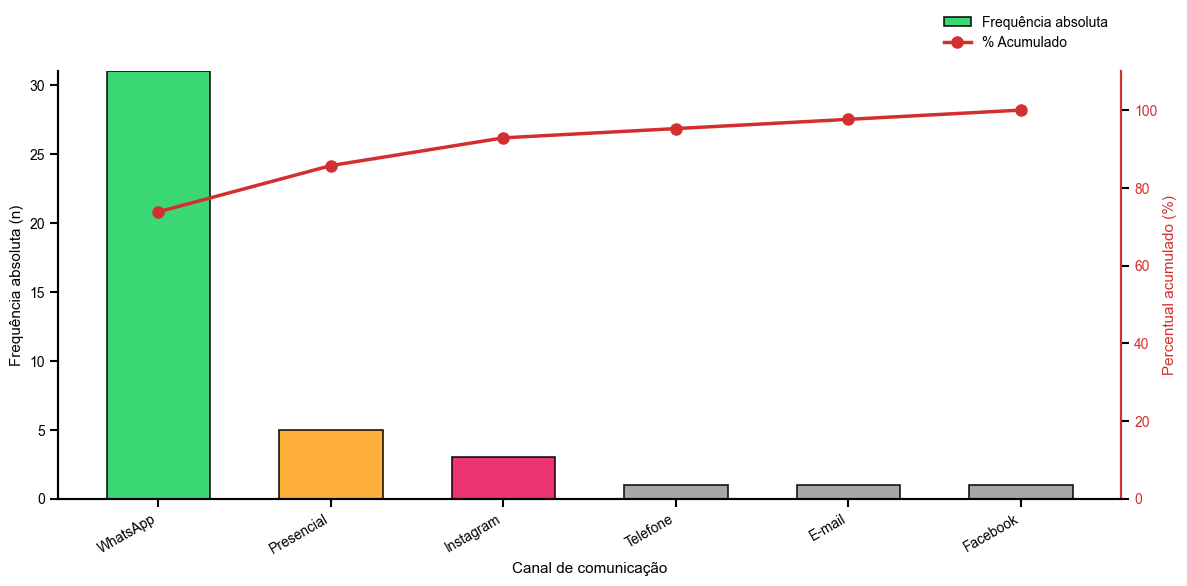


Resumo estatistico:

Canal dominante: WhatsApp (31 consultoras, 73.8%)
2º lugar: Presencial (5 consultoras, 11.9%)
Razão 1º/2º: 6.2x

Top 2 canais: 85.7% do total
Top 3 canais: 92.9% do total


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

dist_canal = df_consultoras['canal_principal'].value_counts().sort_values(ascending=True)
n_total = len(df_consultoras)

canais = dist_canal.index.tolist()
contagens = dist_canal.values.tolist()
percentuais = [(c / n_total * 100) for c in contagens]

canais_curtos = []
for canal in canais:
    if 'whatsapp' in canal.lower():
        canais_curtos.append('WhatsApp')
    elif 'presencial' in canal.lower():
        canais_curtos.append('Presencial')
    elif 'instagram' in canal.lower():
        canais_curtos.append('Instagram')
    elif 'facebook' in canal.lower():
        canais_curtos.append('Facebook')
    elif 'e-mail' in canal.lower() or 'email' in canal.lower():
        canais_curtos.append('E-mail')
    elif 'telefone' in canal.lower():
        canais_curtos.append('Telefone')
    else:
        canais_curtos.append(canal[:20])

print("="*80)
print("Opção 1: Gráfico de barras horizontais")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(10, 6))

# Verde (WhatsApp), Laranja (Presencial), Azul/Roxo (Redes sociais), Cinza (Outros)
cores_canal = ['#9E9E9E', '#9E9E9E', '#9E9E9E', '#E91E63', '#FFA726', '#25D366']

bars = ax1.barh(canais_curtos, contagens, color=cores_canal, height=0.7,
                edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax1.set_ylabel('Canal principal', fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

ax1.set_xlim(0, max(contagens) * 1.15)

# (frequência + percentual)
# for i, bar in enumerate(bars):
#     width = bar.get_width()
#     pct = percentuais[i]
#     ax1.text(width, bar.get_y() + bar.get_height()/2.,
#              f' {int(width)} ({pct:.1f}%)',
#              ha='left', va='center', fontsize=10, fontweight='bold')

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()


print('Figura 26. Canal principal de comunicação utilizado pelas consultoras')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: WhatsApp representa 73,8% das interações principal-cliente.')

# plt.figtext(0.5, -0.05, 'Figura 26. Canal principal de comunicação utilizado pelas consultoras',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.13, 'Nota: WhatsApp representa 73,8% das interações principal-cliente.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura26_canal_principal_barras.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 2: Gráfico de colunas verticais com destaque")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 6))

# ordem decrescente (zapzap primeiro)
indices_ordenados = np.argsort(contagens)[::-1]
canais_ord = [canais_curtos[i] for i in indices_ordenados]
contagens_ord = [contagens[i] for i in indices_ordenados]
cores_ord = [cores_canal[i] for i in indices_ordenados]
percentuais_ord = [percentuais[i] for i in indices_ordenados]

bars = ax2.bar(canais_ord, contagens_ord, color=cores_ord, width=0.7,
               edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Canal de comunicação', fontsize=11, color='black')
ax2.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

ax2.set_ylim(0, max(contagens_ord) * 1.15)

# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     pct = percentuais_ord[i]
#     ax2.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}\n({pct:.1f}%)',
#              ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xticklabels(canais_ord, rotation=30, ha='right')

ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 27. Frequência de uso dos canais de comunicação pelas consultoras')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')

# plt.figtext(0.5, -0.10, 'Figura 27. Frequência de uso dos canais de comunicação pelas consultoras',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.15, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura27_canal_principal_colunas.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 3: Gráfico de pizza")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(9, 9))

#WhatsApp para destaque
explode = [0.15 if 'WhatsApp' in canal else 0 for canal in canais_ord]

wedges, texts = ax3.pie(
    contagens_ord,
    explode=explode,
    labels=canais_ord,
    colors=cores_ord,
    autopct=None,
    startangle=90,
    textprops={'fontsize': 11, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# for i, autotext in enumerate(autotexts):
#     if i == 0:  # WhatsApp (primeiro após ordenação)
#         autotext.set_color('white')
#         autotext.set_fontsize(14)
#     else:
#         autotext.set_color('black')
#         autotext.set_fontsize(10)

ax3.axis('equal')

plt.tight_layout()

print('Figura 28. Proporção de canais principais utilizados pelas consultoras')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: WhatsApp explodido para destacar sua dominância absoluta (73,8%).')

# plt.figtext(0.5, -0.02, 'Figura 28. Proporção de canais principais utilizados pelas consultoras',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.07, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.10, 'Nota: WhatsApp explodido para destacar sua dominância absoluta (73,8%).',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura28_canal_principal_pizza.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 4: Gráfico híbrido (barras + linha acumulada)")
print("="*80)

fig4, ax4 = plt.subplots(figsize=(12, 6))

# percentual acumulado
percentuais_acum = np.cumsum(percentuais_ord)

bars = ax4.bar(canais_ord, contagens_ord, color=cores_ord, width=0.6,
               edgecolor='black', linewidth=1.2, alpha=0.9,
               label='Frequência absoluta')

ax4.set_xlabel('Canal de comunicação', fontsize=11, color='black')
ax4.set_ylabel('Frequência absoluta (n)', fontsize=11, color='black')

ax4.grid(False)
ax4.spines['top'].set_visible(False)

ax4.set_ylim(0, max(contagens_ord) * 1.0)

# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     ax4.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}',
#              ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4_2 = ax4.twinx()
ax4_2.plot(canais_ord, percentuais_acum, color='#D32F2F', marker='o',
           linewidth=2.5, markersize=8, label='% Acumulado')

ax4_2.set_ylabel('Percentual acumulado (%)', fontsize=11, color='#D32F2F')
ax4_2.tick_params(axis='y', labelcolor='#D32F2F', labelsize=10,
                  width=1.5, length=6)
ax4_2.set_ylim(0, 110)
ax4_2.spines['top'].set_visible(False)
ax4_2.spines['right'].set_edgecolor('#D32F2F')
ax4_2.spines['right'].set_linewidth(1.5)

# for i, (x, y) in enumerate(zip(canais_ord, percentuais_acum)):
#     ax4_2.text(x, y + 3, f'{y:.1f}%', ha='center', fontsize=9,
#                color='#D32F2F', fontweight='bold')

ax4.set_xticklabels(canais_ord, rotation=30, ha='right')

for spine in ['bottom', 'left']:
    ax4.spines[spine].set_edgecolor('black')
    ax4.spines[spine].set_linewidth(1.5)

ax4.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_2.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2,
           loc='lower right',
           bbox_to_anchor=(1.0, 1.02), # Posição: (x=100%, y=102%) do eixo
           frameon=False, fontsize=10)

plt.tight_layout()

print('Figura 29. Distribuição e concentração acumulada dos canais de comunicação')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Linha vermelha mostra que WhatsApp + Presencial representam 85,7% do total.')

# plt.figtext(0.5, -0.08, 'Figura 29. Distribuição e concentração acumulada dos canais de comunicação',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.13, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.16, 'Nota: Linha vermelha mostra que WhatsApp + Presencial representam 85,7% do total.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura29_canal_principal_hibrido.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*80)
print("Resumo estatistico:")
print("="*80)
print(f"\nCanal dominante: WhatsApp ({contagens_ord[0]} consultoras, {percentuais_ord[0]:.1f}%)")
print(f"2º lugar: {canais_ord[1]} ({contagens_ord[1]} consultoras, {percentuais_ord[1]:.1f}%)")
print(f"Razão 1º/2º: {contagens_ord[0]/contagens_ord[1]:.1f}x")
print(f"\nTop 2 canais: {percentuais_acum[1]:.1f}% do total")
print(f"Top 3 canais: {percentuais_acum[2]:.1f}% do total")


## Gráfico 2 - Comparação entre as etapas mais desafiadoras.

Opção 1: Gráfico de barras horizontais
Figura 30. Etapas da jornada de compra consideradas mais desafiadoras pelas consultoras
Fonte: Elaboração própria (N=42 consultoras)
Nota: Pergunta de múltipla escolha; consultoras podiam marcar mais de uma etapa.


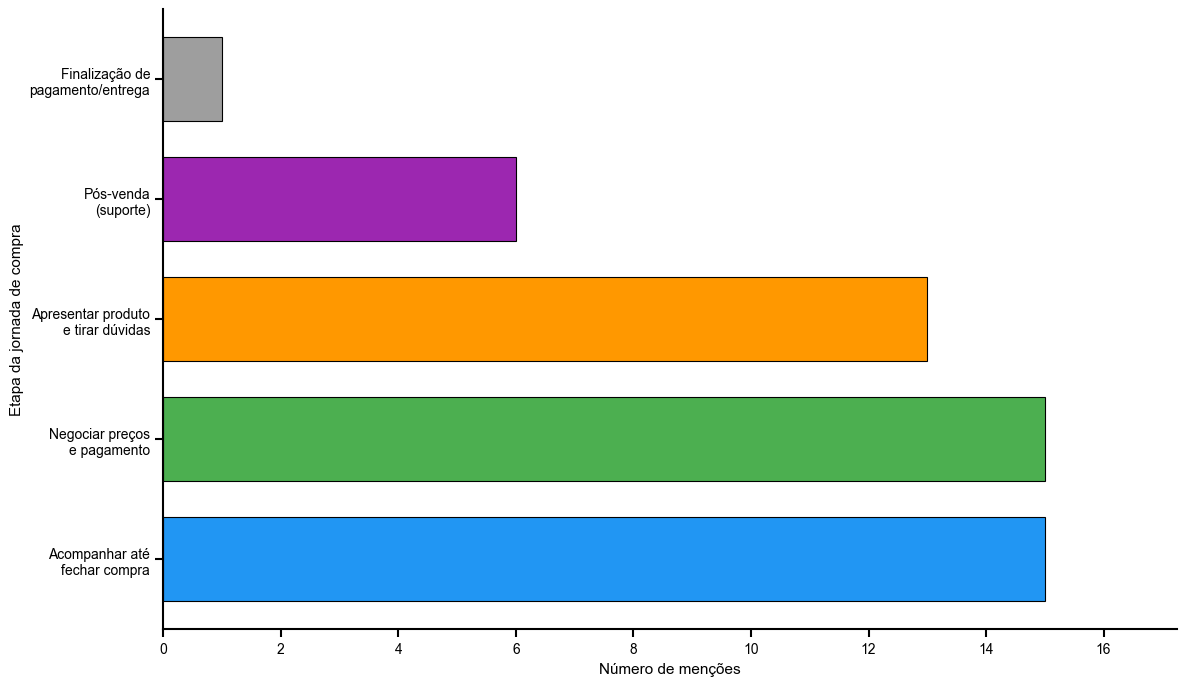

Opção 2: Gráfico de funil (etapas da jornada)
Figura 31. Funil de desafios na jornada de compra consultiva
Fonte: Elaboração própria (N=42 consultoras)
Nota: Largura das barras representa número de consultoras que consideram a etapa desafiadora.


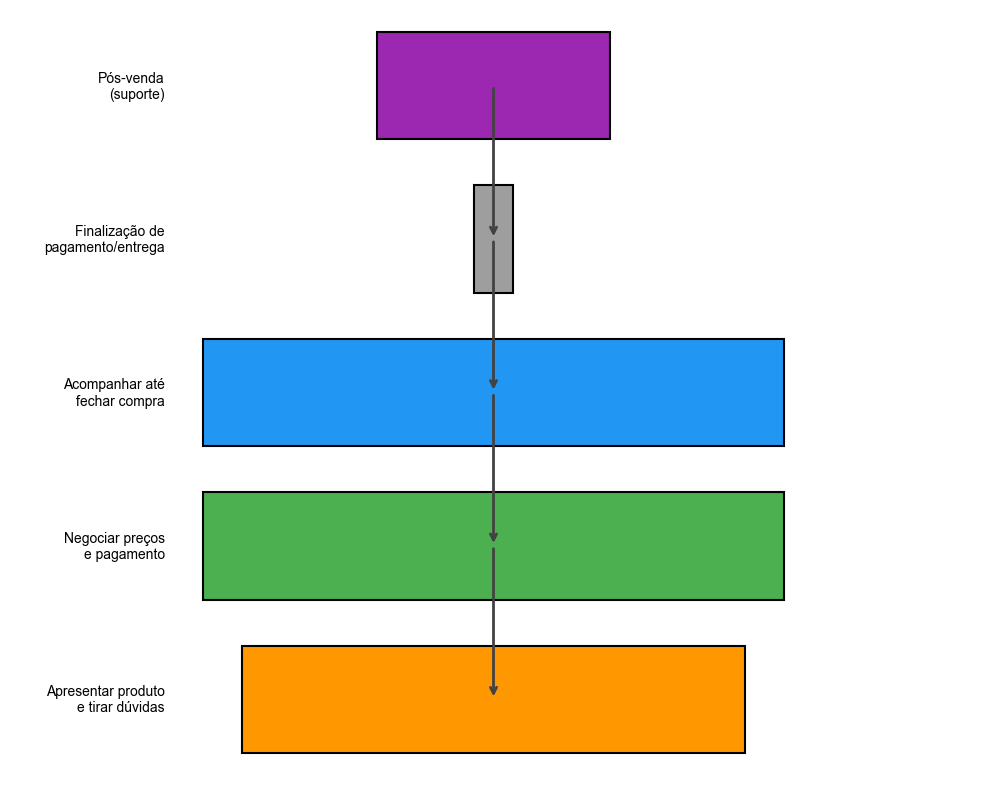

Opção 3: Gráfico de colunas agrupadas por categoria
Figura 32. Distribuição dos desafios por tipo de competência requerida
Fonte: Elaboração própria (N=42 consultoras)


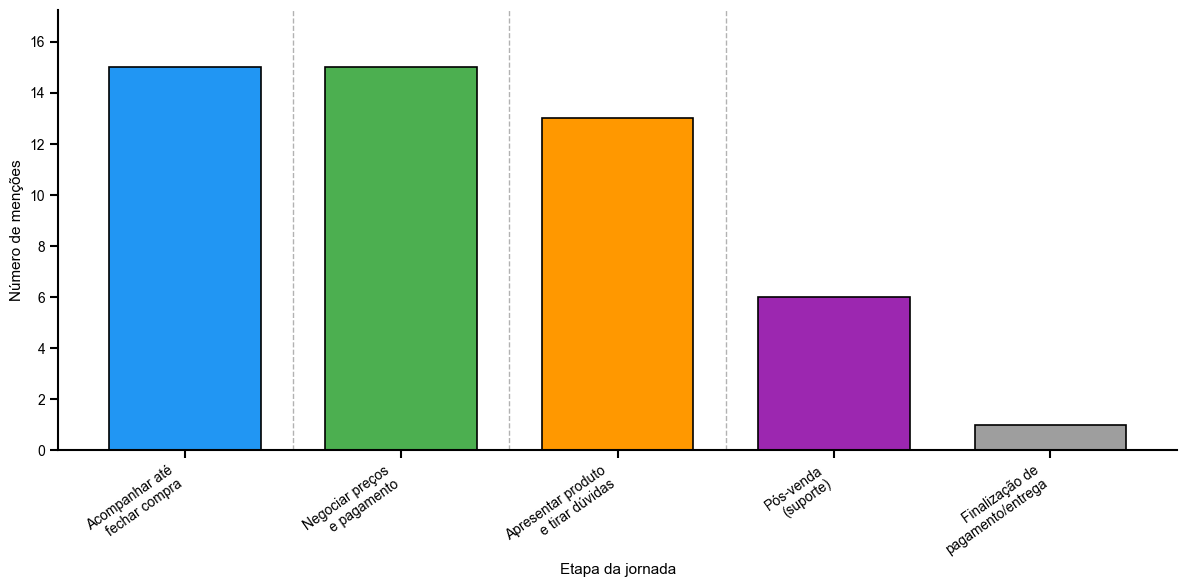

Opção 4: Gráfico de Pareto (análise 80/20)
Figura 33. Análise de Pareto dos desafios na jornada de compra consultiva
Fonte: Elaboração própria (N=42 consultoras)
Nota: Linha tracejada indica 80% acumulado (princípio 80/20). Top 2 etapas concentram 71,5% dos desafios.


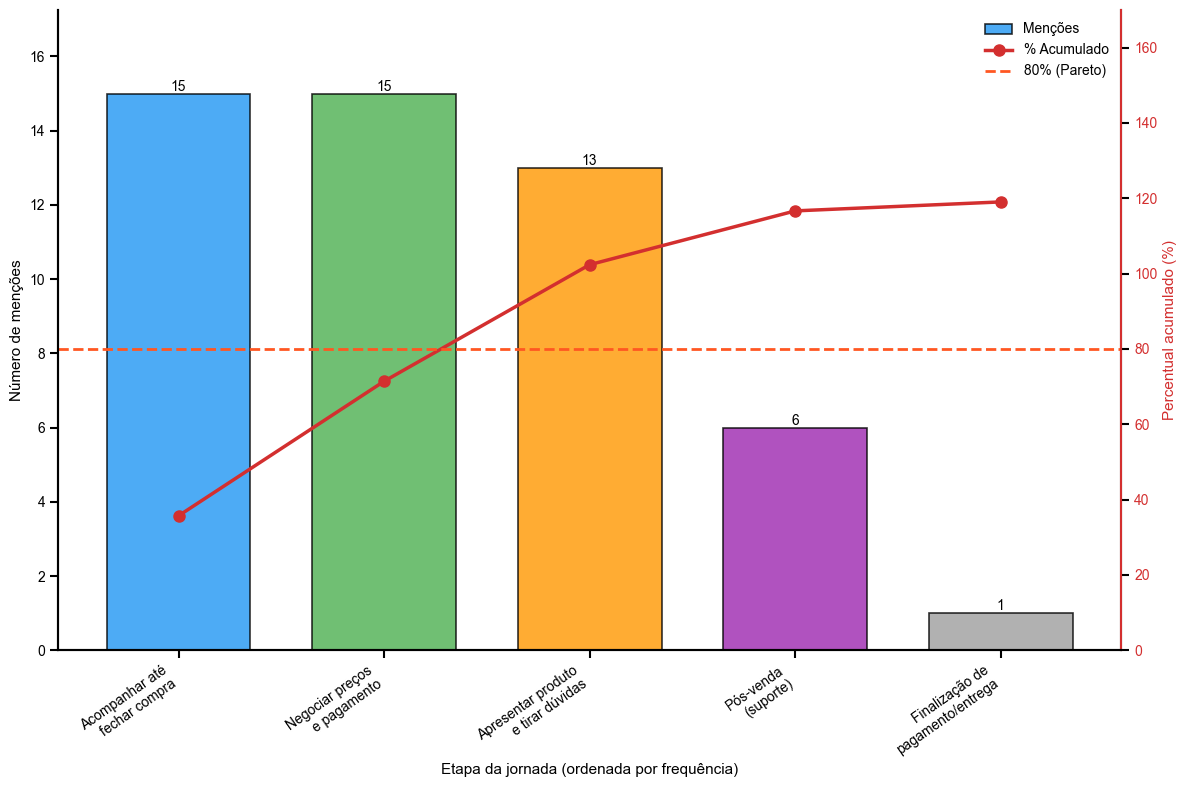


Resumo estatistico

Etapa mais desafiadora: Acompanhar até
fechar compra (15 menções, 35.7%)
2ª mais desafiadora: Negociar preços
e pagamento (15 menções, 35.7%)
Top 2 concentram: 71.4% das menções

Média de etapas marcadas: 1.19
Mediana: 1.0


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

etapa_cols = [col for col in df_consultoras.columns
              if col.startswith('etapa_desafiadora_')
              and col != 'etapa_desafiadora'
              and col != 'etapa_desafiadora_list']

frequencias_etapas = {}
for col in etapa_cols:
    freq = df_consultoras[col].sum()
    nome_etapa = col.replace('etapa_desafiadora_', '')
    frequencias_etapas[nome_etapa] = freq

etapas_ordenadas = sorted(frequencias_etapas.items(), key=lambda x: x[1], reverse=True)

etapas_simplificadas = []
frequencias = []
for etapa, freq in etapas_ordenadas:
    if freq > 0:  # Apenas etapas com pelo menos 1 menção
        # Simplificar rótulos
        if 'acompanhar' in etapa.lower():
            etapas_simplificadas.append('Acompanhar até\nfechar compra')
        elif 'negociar' in etapa.lower():
            etapas_simplificadas.append('Negociar preços\ne pagamento')
        elif 'apresentar' in etapa.lower():
            etapas_simplificadas.append('Apresentar produto\ne tirar dúvidas')
        elif 'finalização' in etapa.lower() or 'pagamento e entrega' in etapa.lower():
            etapas_simplificadas.append('Finalização de\npagamento/entrega')
        elif 'pós-venda' in etapa.lower():
            etapas_simplificadas.append('Pós-venda\n(suporte)')
        elif 'novas ofertas' in etapa.lower():
            etapas_simplificadas.append('Novas ofertas\n(recompra)')
        else:
            etapas_simplificadas.append(etapa[:30] + '...')

        frequencias.append(freq)

n_total = len(df_consultoras)
percentuais = [(f / n_total * 100) for f in frequencias]


print("="*80)
print("Opção 1: Gráfico de barras horizontais")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(12, 7))

cores_etapa = []
for etapa in etapas_simplificadas:
    if 'acompanhar' in etapa.lower():
        cores_etapa.append('#2196F3')  # Azul (relacional)
    elif 'negociar' in etapa.lower():
        cores_etapa.append('#4CAF50')  # Verde (transacional)
    elif 'apresentar' in etapa.lower():
        cores_etapa.append('#FF9800')  # Laranja (consultivo)
    elif 'finalização' in etapa.lower():
        cores_etapa.append('#9E9E9E')  # Cinza (técnico)
    elif 'pós-venda' in etapa.lower():
        cores_etapa.append('#9C27B0')  # Roxo (suporte)
    else:
        cores_etapa.append('#BDBDBD')  # Cinza claro (outros)

bars = ax1.barh(etapas_simplificadas, frequencias, color=cores_etapa, height=0.7,
                edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Número de menções', fontsize=11, color='black')
ax1.set_ylabel('Etapa da jornada de compra', fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

ax1.set_xlim(0, max(frequencias) * 1.15)

# Adicionar valores (menções + percentual)
# for i, bar in enumerate(bars):
#     width = bar.get_width()
#     pct = percentuais[i]
#     ax1.text(width, bar.get_y() + bar.get_height()/2.,
#              f' {int(width)} ({pct:.1f}%)',
#              ha='left', va='center', fontsize=10, fontweight='bold')

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 30. Etapas da jornada de compra consideradas mais desafiadoras pelas consultoras')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Pergunta de múltipla escolha; consultoras podiam marcar mais de uma etapa.')

# plt.figtext(0.5, -0.03, 'Figura 30. Etapas da jornada de compra consideradas mais desafiadoras pelas consultoras',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.08, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.11, 'Nota: Pergunta de múltipla escolha; consultoras podiam marcar mais de uma etapa.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura30_etapas_desafiadoras_barras.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()



print("="*80)
print("Opção 2: Gráfico de funil (etapas da jornada)")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 8))

# Reordenar etapas conforme sequência lógica da jornada (não por frequência)
ordem_jornada = [
    'Apresentar produto\ne tirar dúvidas',
    'Negociar preços\ne pagamento',
    'Acompanhar até\nfechar compra',
    'Finalização de\npagamento/entrega',
    'Pós-venda\n(suporte)'
]

# Mapear frequências para ordem da jornada
frequencias_jornada = []
cores_jornada = []
for etapa_ordem in ordem_jornada:
    if etapa_ordem in etapas_simplificadas:
        idx = etapas_simplificadas.index(etapa_ordem)
        frequencias_jornada.append(frequencias[idx])
        cores_jornada.append(cores_etapa[idx])
    else:
        frequencias_jornada.append(0)
        cores_jornada.append('#EEEEEE')

# Criar funil (barras horizontais com largura variável)
y_pos = np.arange(len(ordem_jornada))
larguras_funil = frequencias_jornada

for i, (y, largura, cor) in enumerate(zip(y_pos, larguras_funil, cores_jornada)):
    # Calcular posição centralizada
    left = (max(larguras_funil) - largura) / 2

    # Desenhar barra centrada
    ax2.barh(y, largura, left=left, height=0.7, color=cor,
             edgecolor='black', linewidth=1.5)

    # Adicionar rótulo da etapa (lado esquerdo)
    ax2.text(-1, y, ordem_jornada[i], ha='right', va='center',
             fontsize=10, fontweight='bold')

    # Adicionar valor (centro da barra)
    # if largura > 0:
    #     pct = (largura / n_total) * 100
    #     ax2.text(left + largura/2, y,
    #              f'{int(largura)} ({pct:.1f}%)',
    #              ha='center', va='center', fontsize=10,
    #              fontweight='bold', color='white')

ax2.set_xlim(-5, max(larguras_funil) + 5)
ax2.set_ylim(-0.5, len(ordem_jornada) - 0.5)

ax2.set_yticks([])
ax2.set_xticks([])

for i in range(len(ordem_jornada) - 1):
    ax2.annotate('', xy=(max(larguras_funil)/2, i),
                 xytext=(max(larguras_funil)/2, i+1),
                 arrowprops=dict(arrowstyle='->', lw=2, color='#424242'))

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()

print('Figura 31. Funil de desafios na jornada de compra consultiva')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Largura das barras representa número de consultoras que consideram a etapa desafiadora.')

# plt.figtext(0.5, -0.02, 'Figura 31. Funil de desafios na jornada de compra consultiva',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.07, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.10, 'Nota: Largura das barras representa número de consultoras que consideram a etapa desafiadora.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura31_etapas_desafiadoras_funil.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 3: Gráfico de colunas agrupadas por categoria")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(12, 6))

categorias = {
    'Relacional': [],
    'Transacional': [],
    'Consultivo': [],
    'Técnico/Operacional': []
}

for i, etapa in enumerate(etapas_simplificadas):
    if 'acompanhar' in etapa.lower():
        categorias['Relacional'].append((etapa, frequencias[i], cores_etapa[i]))
    elif 'negociar' in etapa.lower():
        categorias['Transacional'].append((etapa, frequencias[i], cores_etapa[i]))
    elif 'apresentar' in etapa.lower():
        categorias['Consultivo'].append((etapa, frequencias[i], cores_etapa[i]))
    else:
        categorias['Técnico/Operacional'].append((etapa, frequencias[i], cores_etapa[i]))

todas_etapas = []
todas_freqs = []
todas_cores = []
separadores_x = []

x_pos = 0
for cat, etapas_cat in categorias.items():
    if etapas_cat:
        for etapa, freq, cor in etapas_cat:
            todas_etapas.append(etapa)
            todas_freqs.append(freq)
            todas_cores.append(cor)
        separadores_x.append(x_pos + len(etapas_cat) - 0.5)
        x_pos += len(etapas_cat)

bars = ax3.bar(range(len(todas_etapas)), todas_freqs, color=todas_cores,
               width=0.7, edgecolor='black', linewidth=1.2)

ax3.set_xlabel('Etapa da jornada', fontsize=11, color='black')
ax3.set_ylabel('Número de menções', fontsize=11, color='black')

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

ax3.set_ylim(0, max(todas_freqs) * 1.15)

# Adicionar valores
# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     pct = (height / n_total) * 100
#     ax3.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}\n({pct:.1f}%)',
#              ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configurar rótulos do eixo X
ax3.set_xticks(range(len(todas_etapas)))
ax3.set_xticklabels(todas_etapas, rotation=35, ha='right', fontsize=9)

# Adicionar linhas separadoras entre categorias
for sep_x in separadores_x[:-1]:
    ax3.axvline(x=sep_x, color='black', linestyle='--', linewidth=1, alpha=0.3)

ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 32. Distribuição dos desafios por tipo de competência requerida')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')

# plt.figtext(0.5, -0.12, 'Figura 32. Distribuição dos desafios por tipo de competência requerida',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.17, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura32_etapas_desafiadoras_categorias.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 4: Gráfico de Pareto (análise 80/20)")
print("="*80)

fig4, ax4 = plt.subplots(figsize=(12, 8))

percentuais_acum = np.cumsum(percentuais)

bars = ax4.bar(range(len(etapas_simplificadas)), frequencias,
               color=cores_etapa, width=0.7, edgecolor='black', linewidth=1.2,
               alpha=0.8, label='Menções')

ax4.set_xlabel('Etapa da jornada (ordenada por frequência)', fontsize=11, color='black')
ax4.set_ylabel('Número de menções', fontsize=11, color='black')

ax4.grid(False)
ax4.spines['top'].set_visible(False)

ax4.set_ylim(0, max(frequencias) * 1.15)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Eixo secundário: linha acumulada
ax4_2 = ax4.twinx()
ax4_2.plot(range(len(percentuais_acum)), percentuais_acum,
           color='#D32F2F', marker='o', linewidth=2.5, markersize=8,
           label='% Acumulado')

# Linha de 80%
ax4_2.axhline(y=80, color='#FF5722', linestyle='--', linewidth=2,
              label='80% (Pareto)')

ax4_2.set_ylabel('Percentual acumulado (%)', fontsize=11, color='#D32F2F')
ax4_2.tick_params(axis='y', labelcolor='#D32F2F', labelsize=10,
                  width=1.5, length=6)
ax4_2.set_ylim(0, 170)
ax4_2.spines['top'].set_visible(False)
ax4_2.spines['right'].set_edgecolor('#D32F2F')
ax4_2.spines['right'].set_linewidth(1.5)

for i, (x, y) in enumerate(zip(range(len(percentuais_acum)), percentuais_acum)):
    # Se for o último ponto (100%), posicione o texto ABAIXO
    if i == len(percentuais_acum) - 1:
        offset = -4.5 # Deslocamento para baixo
        va = 'top'     # Alinhar pelo topo do texto
    # Para todos os outros pontos, posicione ACIMA
    else:
        offset = 3     # Deslocamento para cima
        va = 'bottom'  # Alinhar pela base do texto

    # ax4_2.text(x, y + offset, f'{y:.1f}%', ha='center', va=va, fontsize=9,
    #            color='#D32F2F', fontweight='bold')

ax4.set_xticks(range(len(etapas_simplificadas)))
ax4.set_xticklabels(etapas_simplificadas, rotation=35, ha='right', fontsize=9)

for spine in ['bottom', 'left']:
    ax4.spines[spine].set_edgecolor('black')
    ax4.spines[spine].set_linewidth(1.5)

ax4.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_2.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right',
           frameon=False, fontsize=10)

plt.tight_layout()

print('Figura 33. Análise de Pareto dos desafios na jornada de compra consultiva')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Linha tracejada indica 80% acumulado (princípio 80/20). Top 2 etapas concentram 71,5% dos desafios.')

# plt.figtext(0.5, -0.12, 'Figura 33. Análise de Pareto dos desafios na jornada de compra consultiva',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.17, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.20, 'Nota: Linha tracejada indica 80% acumulado (princípio 80/20). Top 2 etapas concentram 71,5% dos desafios.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura33_etapas_desafiadoras_pareto.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("Resumo estatistico")
print("="*80)
print(f"\nEtapa mais desafiadora: {etapas_simplificadas[0]} ({frequencias[0]} menções, {percentuais[0]:.1f}%)")
print(f"2ª mais desafiadora: {etapas_simplificadas[1]} ({frequencias[1]} menções, {percentuais[1]:.1f}%)")
print(f"Top 2 concentram: {sum(percentuais[:2]):.1f}% das menções")
print(f"\nMédia de etapas marcadas: {df_consultoras['qtd_etapas_desafiadoras'].mean():.2f}")
print(f"Mediana: {df_consultoras['qtd_etapas_desafiadoras'].median():.1f}")


## Gráfico 3 - Distribuição das respostas de frequência.

Opção 1: Gráfico de barras verticais (distribuição de frequência)
Figura 34. Frequência de transição de canais na jornada de compra consultiva
Fonte: Elaboração própria (N=42 consultoras)
Nota: Pergunta "Com que frequência um cliente inicia a compra com você por um canal e finaliza por outro?"


/tmp/ipython-input-3401606154.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(categorias, rotation=15, ha='right', fontsize=10)


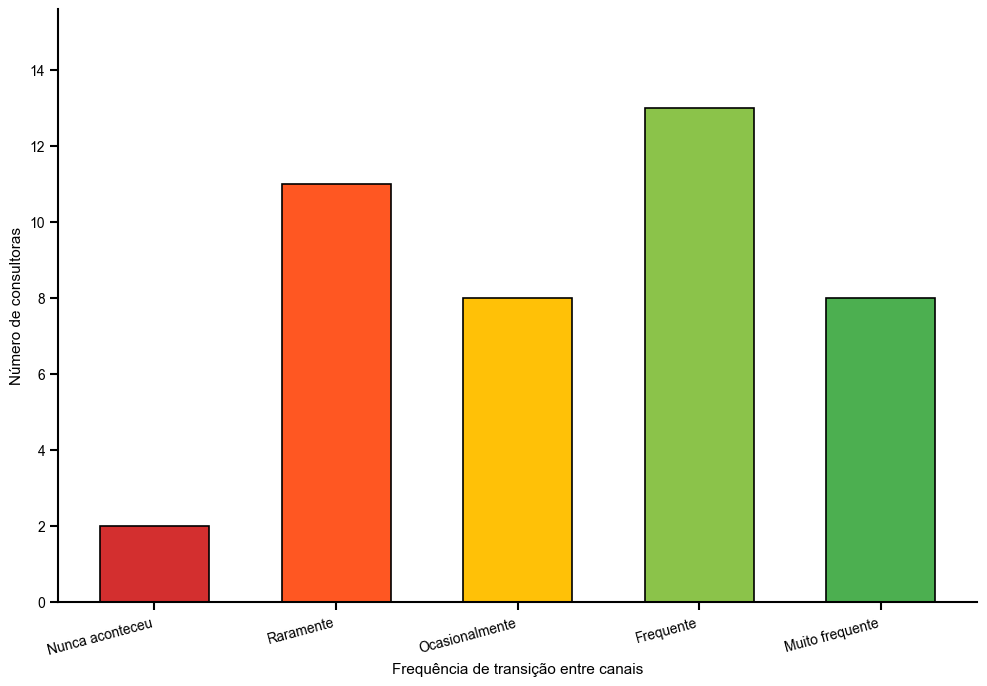


Opção 2: Gráfico de barras horizontais (ênfase em comparação)
Figura 35. Distribuição da frequência de transição entre canais (ordenação por intensidade)
Fonte: Elaboração própria (N=42 consultoras)
Nota: Cores indicam intensidade da frequência (vermelho = baixa, verde = alta).


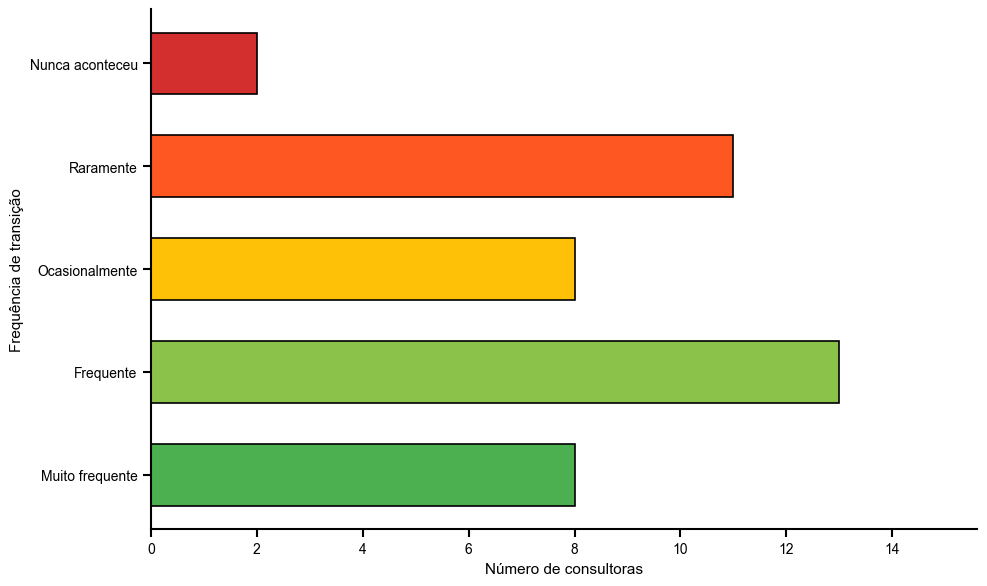


Opção 3: Gráfico de lollipop (visualização minimalista)
Figura 36. Frequência de transição de canais (visualização lollipop)
Fonte: Elaboração própria (N=42 consultoras)
Nota: Design minimalista destaca a progressão ordinal das frequências.


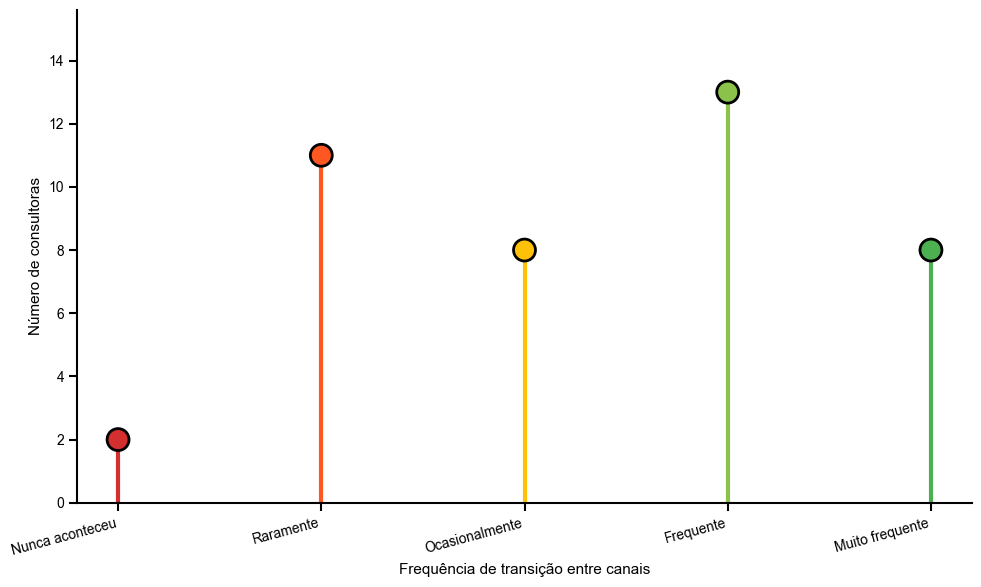


Opção 4: Gráfico combinado (barras + linha acumulada)
Figura 37. Análise de frequência de transição com distribuição acumulada
Fonte: Elaboração própria (N=42 consultoras)
Nota: Linha azul representa percentual acumulado; barras coloridas representam frequências absolutas.


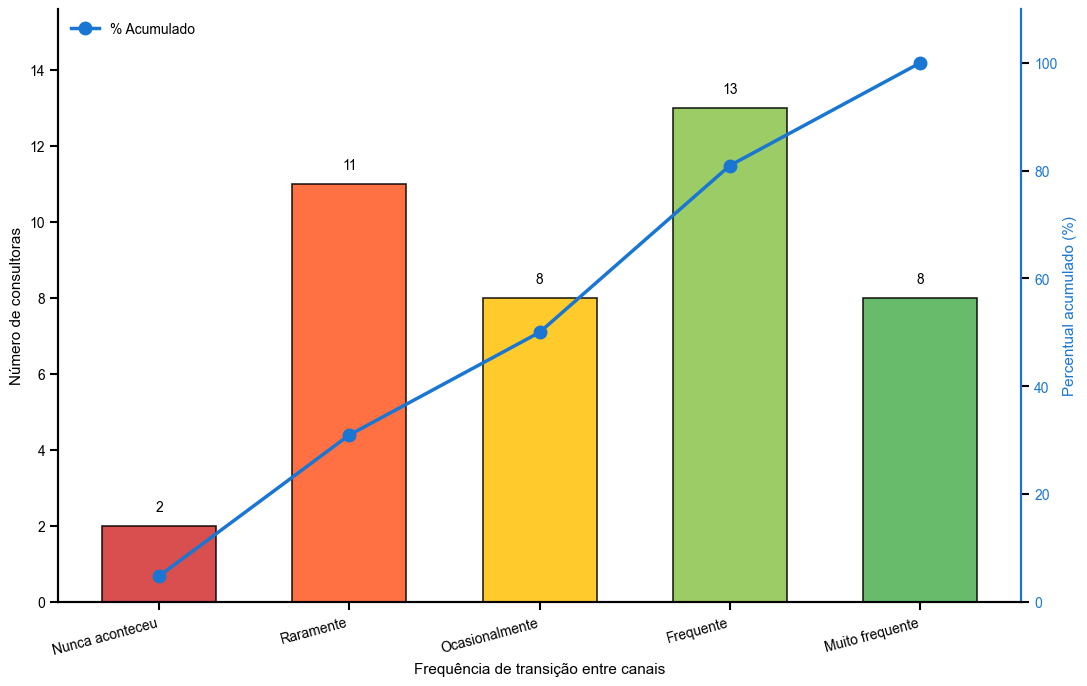


RESUMO ESTATÍSTICO

Frequência modal: Frequente (13 consultoras, 31.0%)
Consultoras com transição frequente/muito frequente: 21 (50.0%)
Consultoras com transição baixa/inexistente: 13 (31.0%)

Distribuição completa:
  Nunca aconteceu: 2 (4.8%)
  Raramente: 11 (26.2%)
  Ocasionalmente: 8 (19.0%)
  Frequente: 13 (31.0%)
  Muito frequente: 8 (19.0%)


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

freq_transicao = df_consultoras['frequencia_transicao'].value_counts()

#ordem lógica (ordinal: do menor para o maior)
ordem_frequencia = [
    'Nunca aconteceu',
    'Raramente',
    'Ocasionalmente',
    'Frequente',
    'Muito frequente'
]


categorias = [cat for cat in ordem_frequencia if cat in freq_transicao.index]
frequencias = [freq_transicao[cat] for cat in categorias]

n_total = len(df_consultoras)
percentuais = [(f / n_total * 100) for f in frequencias]

cores_frequencia = {
    'Nunca aconteceu': '#D32F2F',    # Vermelho escuro (baixa frequência)
    'Raramente': '#FF5722',          # Laranja-avermelhado
    'Ocasionalmente': '#FFC107',     # Amarelo-alaranjado (neutro)
    'Frequente': '#8BC34A',          # Verde claro
    'Muito frequente': '#4CAF50'     # Verde escuro (alta frequência)
}

cores = [cores_frequencia[cat] for cat in categorias]


print("="*80)
print("Opção 1: Gráfico de barras verticais (distribuição de frequência)")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(10, 7))

bars = ax1.bar(categorias, frequencias, color=cores, width=0.6,
               edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Frequência de transição entre canais', fontsize=11, color='black')
ax1.set_ylabel('Número de consultoras', fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

ax1.set_ylim(0, max(frequencias) * 1.2)

# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
#              f'{int(height)}\n({percentuais[i]:.1f}%)',
#              ha='center', va='bottom', fontsize=10, fontweight='bold')

# Rotacionar rótulos do eixo X para melhor legibilidade
ax1.set_xticklabels(categorias, rotation=15, ha='right', fontsize=10)

ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 34. Frequência de transição de canais na jornada de compra consultiva')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Pergunta "Com que frequência um cliente inicia a compra com você por um canal e finaliza por outro?"')

plt.savefig('figura34_frequencia_transicao_barras.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("Opção 2: Gráfico de barras horizontais (ênfase em comparação)")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 6))

bars2 = ax2.barh(categorias, frequencias, color=cores, height=0.6,
                 edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Número de consultoras', fontsize=11, color='black')
ax2.set_ylabel('Frequência de transição', fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

ax2.set_xlim(0, max(frequencias) * 1.2)

# Adicionar valores à direita das barras
# for i, bar in enumerate(bars2):
#     width = bar.get_width()
#     ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
#              f'{int(width)} ({percentuais[i]:.1f}%)',
#              ha='left', va='center', fontsize=10, fontweight='bold')

ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

# Inverter ordem para mostrar "Muito frequente" no topo
ax2.invert_yaxis()

plt.tight_layout()

print('Figura 35. Distribuição da frequência de transição entre canais (ordenação por intensidade)')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Cores indicam intensidade da frequência (vermelho = baixa, verde = alta).')

plt.savefig('figura35_frequencia_transicao_horizontal.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("Opção 3: Gráfico de lollipop (visualização minimalista)")
print("="*80)

fig3, ax3 = plt.subplots(figsize=(10, 6))

# Desenhar linhas verticais (hastes do lollipop)
for i, (cat, freq, cor) in enumerate(zip(categorias, frequencias, cores)):
    ax3.plot([i, i], [0, freq], color=cor, linewidth=3, zorder=1)

# Desenhar círculos no topo (cabeças do lollipop)
ax3.scatter(range(len(categorias)), frequencias, color=cores, s=250,
            edgecolor='black', linewidth=2, zorder=2)

ax3.set_xlabel('Frequência de transição entre canais', fontsize=11, color='black')
ax3.set_ylabel('Número de consultoras', fontsize=11, color='black')

ax3.grid(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax3.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_linewidth(1.5)

ax3.set_ylim(0, max(frequencias) * 1.2)

# # Adicionar valores acima dos círculos
# for i, (freq, pct) in enumerate(zip(frequencias, percentuais)):
#     ax3.text(i, freq + 1, f'{int(freq)}\n({pct:.1f}%)',
#              ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_xticks(range(len(categorias)))
ax3.set_xticklabels(categorias, rotation=15, ha='right', fontsize=10)

ax3.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print('Figura 36. Frequência de transição de canais (visualização lollipop)')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Design minimalista destaca a progressão ordinal das frequências.')

plt.savefig('figura36_frequencia_transicao_lollipop.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("Opção 4: Gráfico combinado (barras + linha acumulada)")
print("="*80)

fig4, ax4 = plt.subplots(figsize=(11, 7))

# Gráfico de barras
bars4 = ax4.bar(categorias, frequencias, color=cores, width=0.6,
                edgecolor='black', linewidth=1.2, alpha=0.85)

ax4.set_xlabel('Frequência de transição entre canais', fontsize=11, color='black')
ax4.set_ylabel('Número de consultoras', fontsize=11, color='black')

ax4.grid(False)
ax4.spines['top'].set_visible(False)

ax4.set_ylim(0, max(frequencias) * 1.2)

# Adicionar valores nas barras
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Eixo secundário: linha acumulada
ax4_2 = ax4.twinx()

percentuais_acum = np.cumsum(percentuais)
ax4_2.plot(range(len(categorias)), percentuais_acum,
           color='#1976D2', marker='o', linewidth=2.5, markersize=9,
           label='% Acumulado', zorder=3)

ax4_2.set_ylabel('Percentual acumulado (%)', fontsize=11, color='#1976D2')
ax4_2.tick_params(axis='y', labelcolor='#1976D2', labelsize=10,
                  width=1.5, length=6)
ax4_2.set_ylim(0, 110)
ax4_2.spines['top'].set_visible(False)
ax4_2.spines['right'].set_edgecolor('#1976D2')
ax4_2.spines['right'].set_linewidth(1.5)

# Adicionar valores na linha acumulada
# for i, (x, y) in enumerate(zip(range(len(percentuais_acum)), percentuais_acum)):
#     ax4_2.text(x, y + 3, f'{y:.1f}%', ha='center', va='bottom', fontsize=9,
#                color='#1976D2', fontweight='bold')

ax4.set_xticks(range(len(categorias)))
ax4.set_xticklabels(categorias, rotation=15, ha='right', fontsize=10)

for spine in ['bottom', 'left']:
    ax4.spines[spine].set_edgecolor('black')
    ax4.spines[spine].set_linewidth(1.5)

ax4.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

# Legendas
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_2.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
           frameon=False, fontsize=10)

plt.tight_layout()

print('Figura 37. Análise de frequência de transição com distribuição acumulada')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Linha azul representa percentual acumulado; barras coloridas representam frequências absolutas.')

plt.savefig('figura37_frequencia_transicao_combinado.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("RESUMO ESTATÍSTICO")
print("="*80)

cat_dominante = categorias[frequencias.index(max(frequencias))]
freq_dominante = max(frequencias)
pct_dominante = percentuais[frequencias.index(max(frequencias))]

print(f"\nFrequência modal: {cat_dominante} ({freq_dominante} consultoras, {pct_dominante:.1f}%)")

# Percentual de consultoras que relatam transição frequente ou muito frequente
transicao_alta = sum([freq for cat, freq in zip(categorias, frequencias)
                      if cat in ['Frequente', 'Muito frequente']])
pct_transicao_alta = (transicao_alta / n_total) * 100
print(f"Consultoras com transição frequente/muito frequente: {transicao_alta} ({pct_transicao_alta:.1f}%)")

# Percentual de consultoras que relatam transição baixa (nunca/raramente)
transicao_baixa = sum([freq for cat, freq in zip(categorias, frequencias)
                       if cat in ['Nunca aconteceu', 'Raramente']])
pct_transicao_baixa = (transicao_baixa / n_total) * 100
print(f"Consultoras com transição baixa/inexistente: {transicao_baixa} ({pct_transicao_baixa:.1f}%)")

print(f"\nDistribuição completa:")
for cat, freq, pct in zip(categorias, frequencias, percentuais):
    print(f"  {cat}: {freq} ({pct:.1f}%)")

print("="*80)


## Gráfico 4 - Comparação das informações mais importantes (múltipla escolha)

CONTAGEM REAL DOS DADOS
Total de elementos: 42

Frequente: 13
Raramente: 11
Ocasionalmente: 8
Muito frequente: 8
Nunca aconteceu: 2

Figura 50. Frequência de transição entre canais relatada por consultoras
Fonte: Elaboração própria (N=42 consultoras)
Nota: Transição = cliente inicia no canal da consultora e finaliza em outro canal.



/tmp/ipython-input-2678021164.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(categorias, rotation=15, ha='right', fontsize=10)


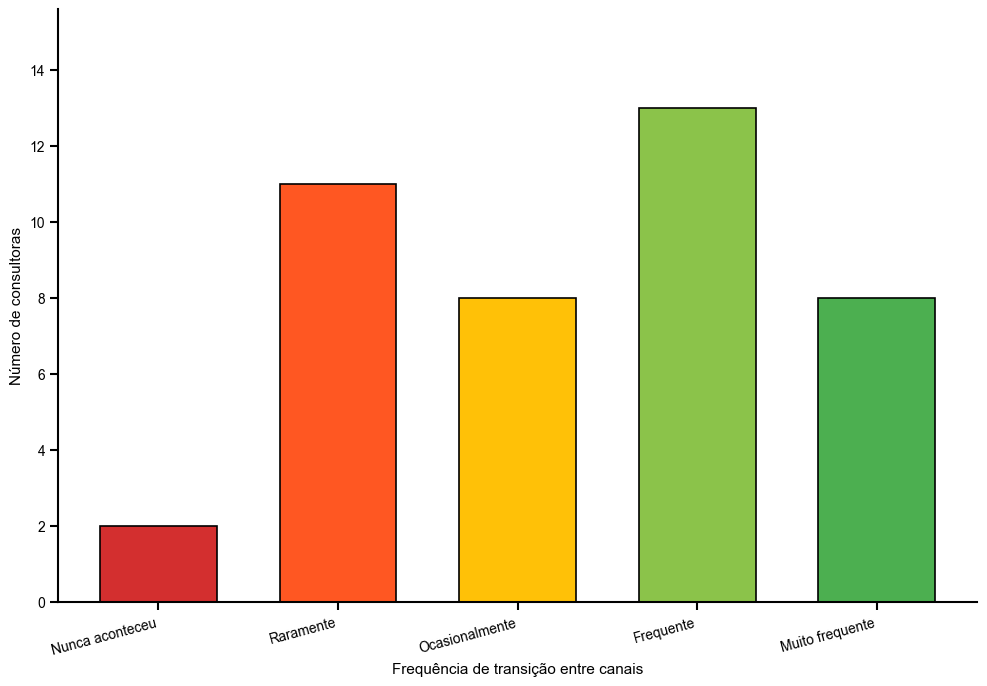

Figura 51. Frequência de transição entre canais (visualização horizontal)
Fonte: Elaboração própria (N=42 consultoras)
Nota: Cores indicam intensidade (vermelho = baixa, verde = alta).

Gerando Figura 52: Proporção agregada...
Figura 52. Proporção agregada da frequência de transição
Fonte: Elaboração própria (N=42 consultoras)
Nota: Categorias agrupadas para visualização simplificada.
  - Transição frequente: 21 (50.0%)
  - Transição ocasional: 8 (19.0%)
  - Transição baixa/inexistente: 13 (31.0%)



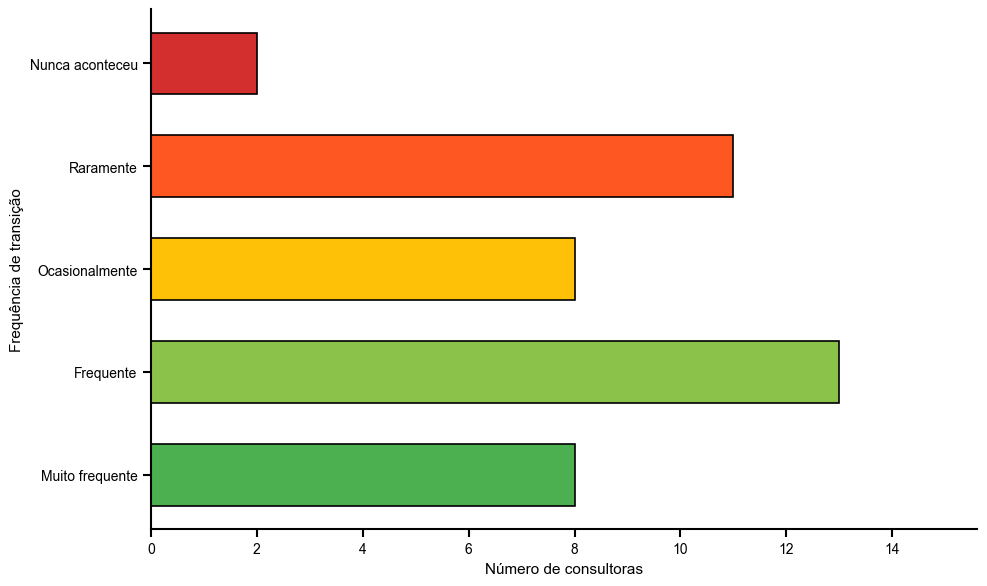

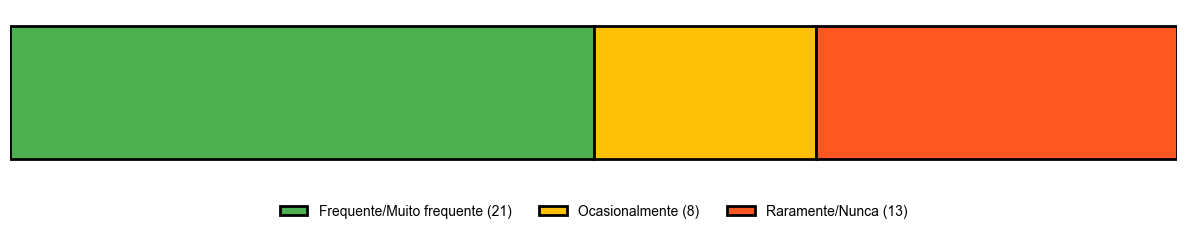

RESUMO ESTATÍSTICO

Distribuição completa (N=42):
  Nunca aconteceu     :  2 (  4.8%)
  Raramente           : 11 ( 26.2%)
  Ocasionalmente      :  8 ( 19.0%)
  Frequente           : 13 ( 31.0%)
  Muito frequente     :  8 ( 19.0%)

Categoria modal: Frequente (13 consultoras, 31.0%)
Transição frequente/muito frequente: 21 (50.0%)
Transição baixa/inexistente: 13 (31.0%)


In [ ]:
from collections import Counter

dados = [
    "Frequente", "Ocasionalmente", "Muito frequente", "Frequente", "Raramente",
    "Nunca aconteceu", "Raramente", "Raramente", "Raramente", "Nunca aconteceu",
    "Raramente", "Frequente", "Ocasionalmente", "Ocasionalmente", "Frequente",
    "Muito frequente", "Ocasionalmente", "Frequente", "Frequente", "Raramente",
    "Raramente", "Frequente", "Ocasionalmente", "Muito frequente", "Muito frequente",
    "Frequente", "Muito frequente", "Raramente", "Raramente", "Muito frequente",
    "Ocasionalmente", "Ocasionalmente", "Raramente", "Raramente", "Frequente",
    "Frequente", "Frequente", "Muito frequente", "Muito frequente", "Frequente",
    "Ocasionalmente", "Frequente"
]

contagem = Counter(dados)

print("="*80)
print("CONTAGEM REAL DOS DADOS")
print("="*80)
print(f"Total de elementos: {len(dados)}\n")
for categoria, freq in contagem.most_common():
    print(f"{categoria}: {freq}")
print("="*80 + "\n")

ordem_frequencia = [
    'Nunca aconteceu',
    'Raramente',
    'Ocasionalmente',
    'Frequente',
    'Muito frequente'
]

categorias = ordem_frequencia
valores = [contagem[cat] for cat in categorias]
n_total = sum(valores)
percentuais = [(v / n_total * 100) for v in valores]

cores_frequencia = {
    'Nunca aconteceu': '#D32F2F',    # Vermelho escuro
    'Raramente': '#FF5722',          # Laranja-avermelhado
    'Ocasionalmente': '#FFC107',     # Amarelo (neutro)
    'Frequente': '#8BC34A',          # Verde claro
    'Muito frequente': '#4CAF50'     # Verde escuro
}
cores = [cores_frequencia[cat] for cat in categorias]

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

fig1, ax1 = plt.subplots(figsize=(10, 7))

bars1 = ax1.bar(categorias, valores, color=cores, width=0.65,
                edgecolor='black', linewidth=1.2)

ax1.set_xlabel("Frequência de transição entre canais", fontsize=11, color='black')
ax1.set_ylabel("Número de consultoras", fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

ax1.set_ylim(0, max(valores) * 1.2)

# # Adicionar valores nas barras
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
#              f'{int(height)}\n({percentuais[i]:.1f}%)',
#              ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_xticklabels(categorias, rotation=15, ha='right', fontsize=10)
ax1.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print("Figura 50. Frequência de transição entre canais relatada por consultoras")
print(f"Fonte: Elaboração própria (N={n_total} consultoras)")
print("Nota: Transição = cliente inicia no canal da consultora e finaliza em outro canal.\n")

plt.savefig('figura50_frequencia_transicao_vertical.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


fig2, ax2 = plt.subplots(figsize=(10, 6))

# Inverter ordem para "Muito frequente" ficar no topo
bars2 = ax2.barh(categorias[::-1], valores[::-1], color=cores[::-1],
                 height=0.6, edgecolor='black', linewidth=1.2)

ax2.set_xlabel("Número de consultoras", fontsize=11, color='black')
ax2.set_ylabel("Frequência de transição", fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

ax2.set_xlim(0, max(valores) * 1.2)

# # Adicionar valores à direita das barras
# percentuais_inv = percentuais[::-1]
# for i, bar in enumerate(bars2):
#     width = bar.get_width()
#     ax2.text(width + 0.3, bar.get_y() + bar.get_height()/2.,
#              f'{int(width)} ({percentuais_inv[i]:.1f}%)',
#              ha='left', va='center', fontsize=10, fontweight='bold')

ax2.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print("Figura 51. Frequência de transição entre canais (visualização horizontal)")
print(f"Fonte: Elaboração própria (N={n_total} consultoras)")
print("Nota: Cores indicam intensidade (vermelho = baixa, verde = alta).\n")

plt.savefig('figura51_frequencia_transicao_horizontal.png', dpi=300,
            bbox_inches='tight', facecolor='white')

print("Gerando Figura 52: Proporção agregada...")


frequente_total = valores[3] + valores[4]  # Frequente + Muito frequente
ocasional_total = valores[2]               # Ocasionalmente
baixa_total = valores[0] + valores[1]      # Nunca + Raramente

fig3, ax3 = plt.subplots(figsize=(12, 2.5))

# Barra empilhada horizontal
p1 = ax3.barh(['Transição'], [frequente_total],
              color='#4CAF50', edgecolor='black', linewidth=2,
              label=f'Frequente/Muito frequente ({frequente_total})')

p2 = ax3.barh(['Transição'], [ocasional_total],
              left=[frequente_total],
              color='#FFC107', edgecolor='black', linewidth=2,
              label=f'Ocasionalmente ({ocasional_total})')

p3 = ax3.barh(['Transição'], [baixa_total],
              left=[frequente_total + ocasional_total],
              color='#FF5722', edgecolor='black', linewidth=2,
              label=f'Raramente/Nunca ({baixa_total})')

# # Adicionar percentuais dentro das barras
# ax3.text(frequente_total/2, 0,
#          f'{(frequente_total/n_total*100):.1f}%',
#          ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# ax3.text(frequente_total + ocasional_total/2, 0,
#          f'{(ocasional_total/n_total*100):.1f}%',
#          ha='center', va='center', fontsize=11, fontweight='bold', color='black')

# ax3.text(frequente_total + ocasional_total + baixa_total/2, 0,
#          f'{(baixa_total/n_total*100):.1f}%',
#          ha='center', va='center', fontsize=11, fontweight='bold', color='white')

ax3.set_xlim(0, n_total)
ax3.set_ylim(-0.5, 0.5)

# Remover eixos (apenas a barra)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_yticks([])
ax3.set_xticks([])

# Legenda
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=3, frameon=False, fontsize=10)

plt.tight_layout()

print("Figura 52. Proporção agregada da frequência de transição")
print(f"Fonte: Elaboração própria (N={n_total} consultoras)")
print("Nota: Categorias agrupadas para visualização simplificada.")
print(f"  - Transição frequente: {frequente_total} ({frequente_total/n_total*100:.1f}%)")
print(f"  - Transição ocasional: {ocasional_total} ({ocasional_total/n_total*100:.1f}%)")
print(f"  - Transição baixa/inexistente: {baixa_total} ({baixa_total/n_total*100:.1f}%)\n")

plt.savefig('figura52_frequencia_transicao_agregada.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("RESUMO ESTATÍSTICO")
print("="*80)

print(f"\nDistribuição completa (N={n_total}):")
for cat, val, pct in zip(categorias, valores, percentuais):
    print(f"  {cat:<20}: {val:>2} ({pct:>5.1f}%)")

cat_modal = categorias[valores.index(max(valores))]
freq_modal = max(valores)
pct_modal = percentuais[valores.index(max(valores))]

print(f"\nCategoria modal: {cat_modal} ({freq_modal} consultoras, {pct_modal:.1f}%)")

transicao_alta = frequente_total
pct_alta = (transicao_alta / n_total) * 100
print(f"Transição frequente/muito frequente: {transicao_alta} ({pct_alta:.1f}%)")

transicao_baixa = baixa_total
pct_baixa = (transicao_baixa / n_total) * 100
print(f"Transição baixa/inexistente: {transicao_baixa} ({pct_baixa:.1f}%)")

print("="*80)


## Gráfico 5 - Quais informações sobre o histórico de um cliente mais te ajudam a sugerir novos produtos e fechar uma venda? (Selecione as mais importantes)


Opção 1: Gráfico de Barras Horizontais (Frequência Absoluta 'n')

Figura. Informações mais relevantes para sugestão de produtos
Fonte: Elaboração própria (N=66 respondentes)
Nota: Pergunta de múltipla escolha, a soma das frequências é maior que N.



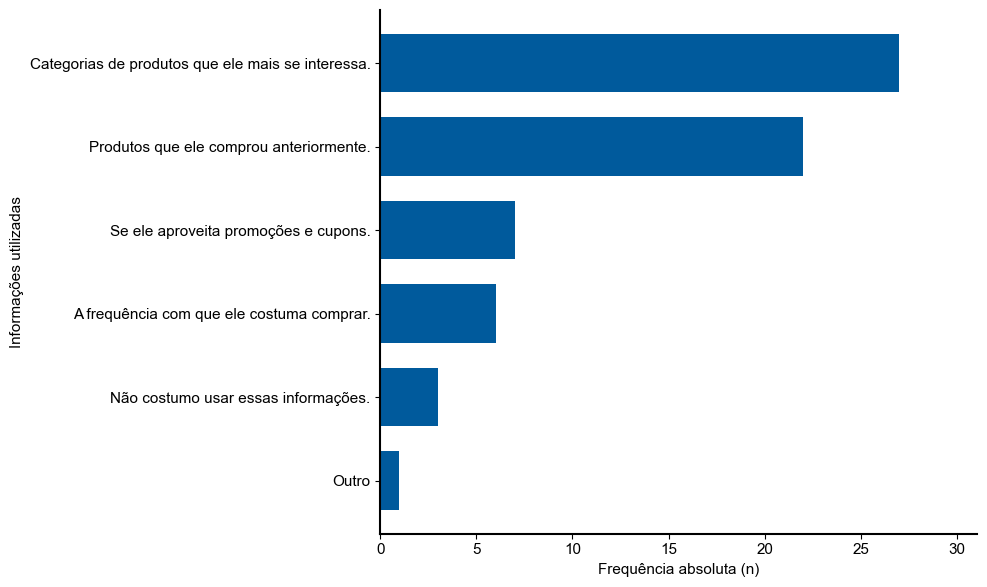


Opção 2: Gráfico de Barras Horizontais (Percentual de Respondentes 'N')

Figura. Penetração de cada informação para sugestão de produtos
Fonte: Elaboração própria (N=66 respondentes)
Nota: Pergunta de múltipla escolha, a soma dos percentuais ultrapassa 100%.



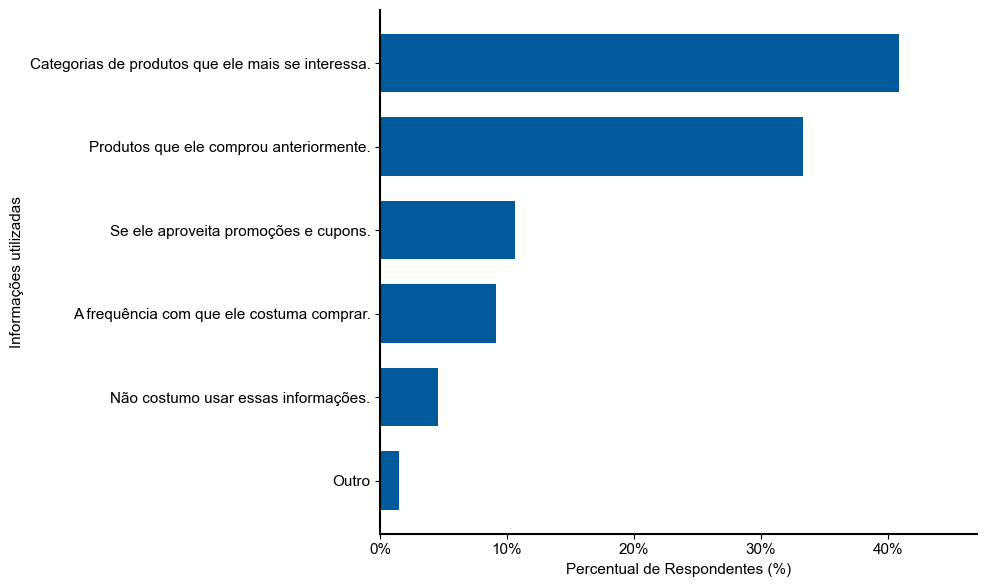

In [ ]:
responses = [
    "Categorias de produtos que ele mais se interessa.",
    "A frequência com que ele costuma comprar.",
    "Produtos que ele comprou anteriormente.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.", "Se ele aproveita promoções e cupons.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.", "A frequência com que ele costuma comprar.", "Se ele aproveita promoções e cupons.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.",
    "Não costumo usar essas informações.",
    "Produtos que ele comprou anteriormente.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.", "A frequência com que ele costuma comprar.",
    "Categorias de produtos que ele mais se interessa.",
    "Categorias de produtos que ele mais se interessa.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.", "Produtos que ele comprou anteriormente.", "Se ele aproveita promoções e cupons.",
    "Não costumo usar essas informações.",
    "Categorias de produtos que ele mais se interessa.", "Se ele aproveita promoções e cupons.",
    "Produtos que ele comprou anteriormente.",
    "Produtos que ele comprou anteriormente.", "A frequência com que ele costuma comprar.",
    "Categorias de produtos que ele mais se interessa.", "A frequência com que ele costuma comprar.",
    "Produtos que ele comprou anteriormente.",
    "Produtos que ele comprou anteriormente.",
    "Categorias de produtos que ele mais se interessa.",
    "Produtos que ele comprou anteriormente.",
    "Não costumo usar essas informações.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.",
    "Produtos que ele comprou anteriormente.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.", "Se ele aproveita promoções e cupons.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.",
    "Categorias de produtos que ele mais se interessa.", "Se ele aproveita promoções e cupons.",
    "Categorias de produtos que ele mais se interessa.",
    "Categorias de produtos que ele mais se interessa.",
    "Categorias de produtos que ele mais se interessa.",
    "Categorias de produtos que ele mais se interessa.",
    "Outro",
    "Categorias de produtos que ele mais se interessa.", "A frequência com que ele costuma comprar.", "Se ele aproveita promoções e cupons.",
    "Categorias de produtos que ele mais se interessa.",
    "Produtos que ele comprou anteriormente.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.",
    "Categorias de produtos que ele mais se interessa.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa.",
    "Categorias de produtos que ele mais se interessa.",
    "Produtos que ele comprou anteriormente.", "Categorias de produtos que ele mais se interessa."
]

n_total_respondentes = len(responses)

all_selections_flat = []
for resp_string in responses:
    cleaned_string = resp_string.replace('"', '')
    answers = cleaned_string.split(', ')
    all_selections_flat.extend(answers)

# frequência de cada resposta individual
df_counts = pd.Series(all_selections_flat).value_counts()

# percentual baseado no N de respondentes
df_percent = (df_counts / n_total_respondentes) * 100

# dados para plotagem (do menor para o maior, para o gráfico ficar do maior para o menor)
counts_sorted = df_counts.sort_values(ascending=True)
percent_sorted = df_percent.sort_values(ascending=True)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'


print("\n" + "="*80)
print("Opção 1: Gráfico de Barras Horizontais (Frequência Absoluta 'n')")
print("="*80)

bar_color = '#005A9C' # Azul escuro

fig1, ax1 = plt.subplots(figsize=(10, 6))

bars1 = ax1.barh(counts_sorted.index, counts_sorted.values,
                 color=bar_color, height=0.7)

ax1.set_xlabel('Frequência absoluta (n)', fontsize=11, color='black')
ax1.set_ylabel('Informações utilizadas', fontsize=11, color='black')

ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

ax1.set_xlim(0, max(counts_sorted.values) * 1.15)

# for bar in bars1:
#     width = bar.get_width()
#     ax1.text(width + 0.5, # Posição X (um pouco à frente da barra)
#              bar.get_y() + bar.get_height() / 2, # Posição Y (centro da barra)
#              f'{int(width)}', # O texto (valor)
#              ha='left', va='center', fontsize=10, color='black')

# Ajusta o layout para não cortar os labels
plt.tight_layout()

# Legenda, Fonte e Nota - COMENTADOS conforme solicitado
# plt.figtext(0.5, -0.10, 'Figura 15. Informações mais relevantes para sugestão de produtos',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.15, f'Fonte: Elaboração própria (N={n_total_respondentes} respondentes)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.20, 'Nota: Pergunta de múltipla escolha, a soma das frequências é maior que N.',
#             ha='center', fontsize=9, style='italic')

print("\nFigura. Informações mais relevantes para sugestão de produtos")
print(f'Fonte: Elaboração própria (N={n_total_respondentes} respondentes)')
print('Nota: Pergunta de múltipla escolha, a soma das frequências é maior que N.\n')


plt.savefig('figura_informacoes_historico_abs.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("Opção 2: Gráfico de Barras Horizontais (Percentual de Respondentes 'N')")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(10, 6))

bars2 = ax2.barh(percent_sorted.index, percent_sorted.values,
                 color=bar_color, height=0.7)

# Títulos dos eixos (Arial 11, preto)
ax2.set_xlabel('Percentual de Respondentes (%)', fontsize=11, color='black')
ax2.set_ylabel('Informações utilizadas', fontsize=11, color='black')

# Remove grades e bordas superiores/direitas
ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Configura eixos X e Y (Preto, 1.5pt)
for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

# Ajuste do limite X para dar espaço aos rótulos
ax2.set_xlim(0, max(percent_sorted.values) * 1.15)

# Formata eixo X para mostrar o %
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# for bar in bars2:
#     width = bar.get_width()
#     ax2.text(width + 1, # Posição X (um pouco à frente da barra)
#              bar.get_y() + bar.get_height() / 2, # Posição Y (centro da barra)
#              f'{width:.1f}%', # O texto (valor)
#              ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()

# plt.figtext(0.5, -0.10, 'Figura 16. Penetração de cada informação para sugestão de produtos',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.15, f'Fonte: Elaboração própria (N={n_total_respondentes} respondentes)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.20, 'Nota: Pergunta de múltipla escolha, a soma dos percentuais ultrapassa 100%.',
#             ha='center', fontsize=9, style='italic')

print("\nFigura. Penetração de cada informação para sugestão de produtos")
print(f'Fonte: Elaboração própria (N={n_total_respondentes} respondentes)')
print('Nota: Pergunta de múltipla escolha, a soma dos percentuais ultrapassa 100%.\n')

plt.savefig('figura_informacoes_historico_perc.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

## Gráfico 6 - Proporção (em %) das respostas "Sim" e "Não"

Opção 1: Gráfico de pizza
Proporção de consultoras com canais integrados
Nota: Integração = Cliente inicia no WhatsApp da consultora e finaliza no site com rastreamento de atribuição.


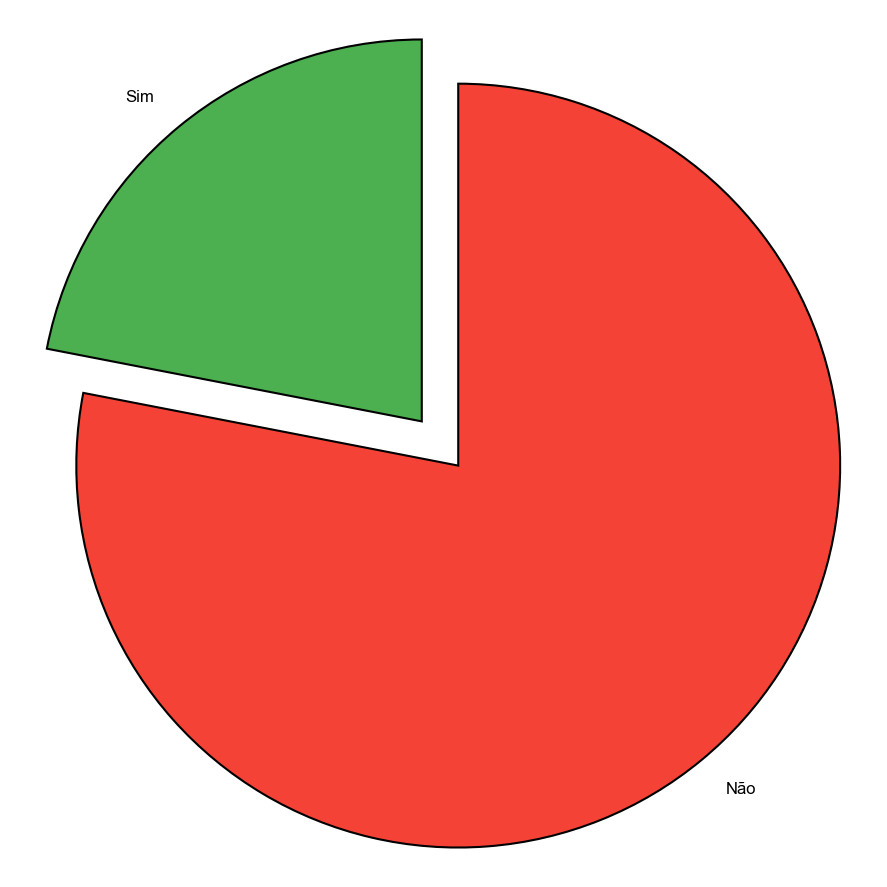

Opção 2: Gráfico de colunas verticais
Distribuição de consultoras por status de integração de canais
Fonte: Elaboração própria (N=42 consultoras)


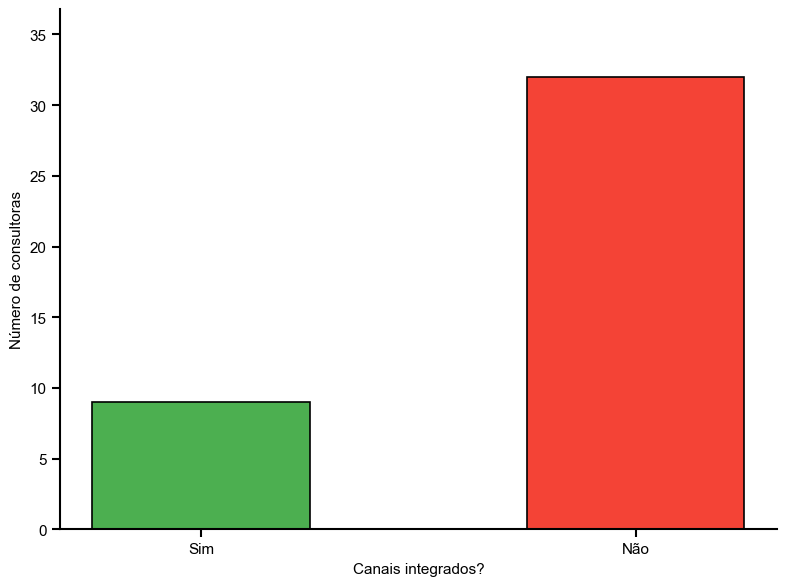

Opção 3: Gráfico de waffle (visualização intuitiva)
Representação proporcional de consultoras com canais integrados (waffle chart)
Fonte: Elaboração própria (N=42 consultoras)
Nota: Cada quadrado = 1% das consultoras. 79 de 100 trabalham sem integração.


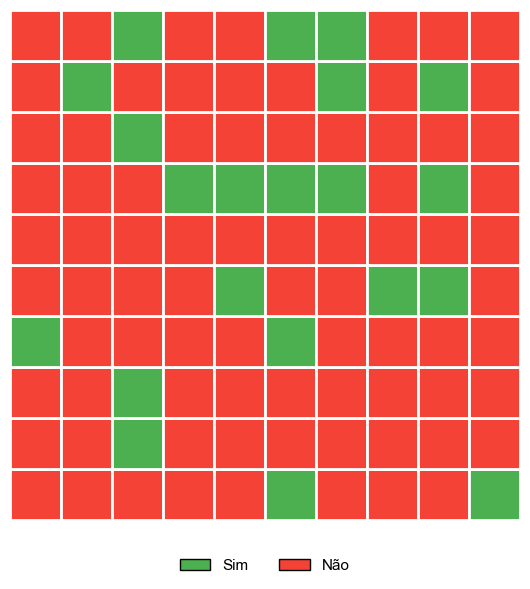

Opção 4: Gráfico comparativo (gap de rastreamento)
Gap entre comportamento real, percepção e rastreamento de transição omnichannel
Fonte: Elaboração própria (Clientes N=92; Consultoras N=42)
Nota: Gap total de 50,3% entre transições reais e rastreadas = Perda de atribuição e comissão.


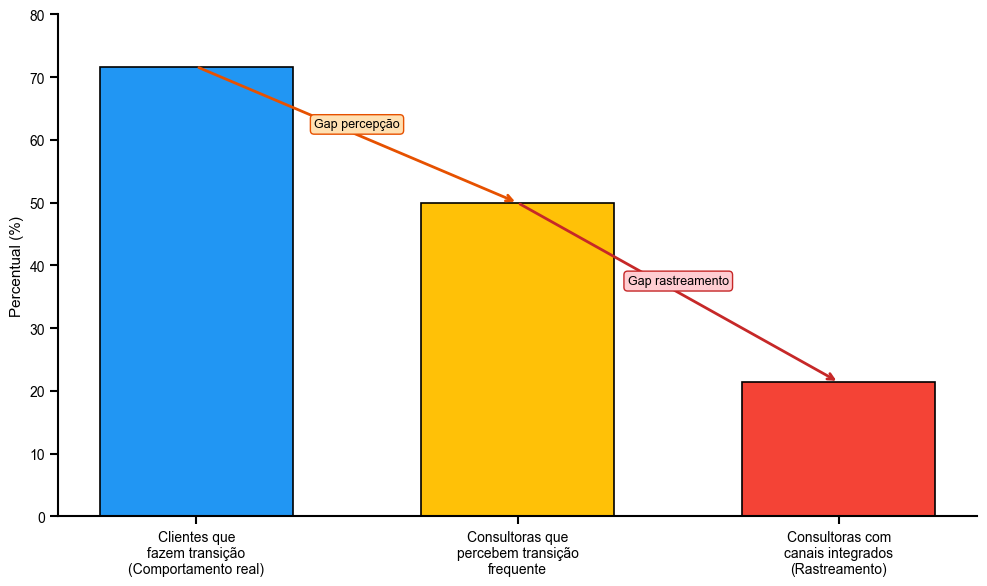


Resumo estatistico

Status de integração:
  Sim (integrados): 9 (21.4%)
  Não: 32 (76.2%)
  Razão Não/Sim: 3.56x


In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

# Preparar dados
dist_integrados = df_consultoras['canais_integrados'].value_counts()
n_total = len(df_consultoras)

# Ordenar: Sim, Não
respostas = ['Sim', 'Não']
contagens = [
    dist_integrados.get('Sim', 0),
    dist_integrados.get('Não', 0)
]
percentuais = [(c / n_total * 100) for c in contagens]

print("="*80)
print("Opção 1: Gráfico de pizza")
print("="*80)

fig1, ax1 = plt.subplots(figsize=(9, 9))

# Cores: Verde (Sim - integrado) e Vermelho (Não - problema)
cores = ['#4CAF50', '#F44336']

# Explodir fatia "Não" para evidenciar problema crítico
explode = (0, 0.15)

wedges, texts = ax1.pie(
    contagens,
    explode=explode,
    labels=respostas,
    colors=cores,
    autopct=None,
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# for i, autotext in enumerate(autotexts):
#     autotext.set_color('white')
#     autotext.set_fontsize(14)
#     autotext.set_weight('bold')

ax1.axis('equal')

plt.tight_layout()

print('Proporção de consultoras com canais integrados')
print('Nota: Integração = Cliente inicia no WhatsApp da consultora e finaliza no site com rastreamento de atribuição.')

# plt.figtext(0.5, -0.02, 'Figura 46. Proporção de consultoras com canais integrados',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.07, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.10, 'Nota: Integração = Cliente inicia no WhatsApp da consultora e finaliza no site com rastreamento de atribuição.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura46_integracao_canais_pizza.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("="*80)
print("Opção 2: Gráfico de colunas verticais")
print("="*80)

fig2, ax2 = plt.subplots(figsize=(8, 6))

bars = ax2.bar(respostas, contagens, color=cores, width=0.5,
               edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Canais integrados?', fontsize=11, color='black')
ax2.set_ylabel('Número de consultoras', fontsize=11, color='black')

ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax2.spines[spine].set_edgecolor('black')
    ax2.spines[spine].set_linewidth(1.5)

ax2.set_ylim(0, max(contagens) * 1.15)

# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     pct = percentuais[i]
#     ax2.text(bar.get_x() + bar.get_width()/2., height,
#              f'{int(height)}\n({pct:.1f}%)',
#              ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.tick_params(axis='both', which='major', labelsize=11,
                width=1.5, length=6, color='black')

plt.tight_layout()

print("Distribuição de consultoras por status de integração de canais")
print(f"Fonte: Elaboração própria (N={n_total} consultoras)")

# plt.figtext(0.5, -0.05, 'Figura 47. Distribuição de consultoras por status de integração de canais',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.10, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')

plt.savefig('figura47_integracao_canais_colunas.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 3: Gráfico de waffle (visualização intuitiva)")
print("="*80)

fig3 = plt.figure(figsize=(10, 6))
ax3 = fig3.add_subplot(111)

# Total de 100 quadrados (10x10)
total_quadrados = 100
quadrados_sim = int(round(percentuais[0]))  # 21
quadrados_nao = total_quadrados - quadrados_sim  # 79

rows = 10
cols = 10
waffle_data = np.array(['Não'] * quadrados_nao + ['Sim'] * quadrados_sim)
np.random.shuffle(waffle_data)  # Misturar
waffle_matrix = waffle_data.reshape(rows, cols)

color_map = {'Sim': cores[0], 'Não': cores[1]}

for i in range(rows):
    for j in range(cols):
        cor = color_map[waffle_matrix[i, j]]
        ax3.add_patch(plt.Rectangle((j, i), 1, 1,
                                    facecolor=cor,
                                    edgecolor='white',
                                    linewidth=2))

ax3.set_xlim(0, cols)
ax3.set_ylim(0, rows)
ax3.set_aspect('equal')
ax3.axis('off')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cores[0], edgecolor='black', label=f'Sim'),
    Patch(facecolor=cores[1], edgecolor='black', label=f'Não')
]
ax3.legend(handles=legend_elements, loc='upper center',
           bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False, fontsize=11)

plt.tight_layout()

print('Representação proporcional de consultoras com canais integrados (waffle chart)')
print(f'Fonte: Elaboração própria (N={n_total} consultoras)')
print('Nota: Cada quadrado = 1% das consultoras. 79 de 100 trabalham sem integração.')

# plt.figtext(0.5, 0.02, 'Figura 48. Representação proporcional de consultoras com canais integrados (waffle chart)',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.03, f'Fonte: Elaboração própria (N={n_total} consultoras)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.06, 'Nota: Cada quadrado = 1% das consultoras. 79 de 100 trabalham sem integração.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura48_integracao_canais_waffle.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()

print("="*80)
print("Opção 4: Gráfico comparativo (gap de rastreamento)")
print("="*80)

fig4, ax4 = plt.subplots(figsize=(10, 6))

metricas = ['Clientes que\nfazem transição\n(Comportamento real)',
            'Consultoras que\npercebem transição\nfrequente',
            'Consultoras com\ncanais integrados\n(Rastreamento)']

valores = [71.7, 50.0, 21.4]  # Percentuais

cores_gap = ['#2196F3', '#FFC107', '#F44336']

bars = ax4.bar(range(len(metricas)), valores, color=cores_gap, width=0.6,
               edgecolor='black', linewidth=1.2)

ax4.set_ylabel('Percentual (%)', fontsize=11, color='black')

ax4.grid(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

for spine in ['bottom', 'left']:
    ax4.spines[spine].set_edgecolor('black')
    ax4.spines[spine].set_linewidth(1.5)

ax4.set_ylim(0, 80)

# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     ax4.text(bar.get_x() + bar.get_width()/2., height,
#              f'{height:.1f}%',
#              ha='center', va='bottom', fontsize=11, fontweight='bold')

# setas mostrando gap
# Gap 1: Clientes (71.7%) → Percepção (50%)
ax4.annotate('', xy=(1, 50), xytext=(0, 71.7),
             arrowprops=dict(arrowstyle='->', lw=2, color='#E65100'))
ax4.text(0.5, 62, 'Gap percepção', ha='center', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#FFE0B2', edgecolor='#E65100'))

# Gap 2: Percepção (50%) → Integração (21.4%)
ax4.annotate('', xy=(2, 21.4), xytext=(1, 50),
             arrowprops=dict(arrowstyle='->', lw=2, color='#C62828'))
ax4.text(1.5, 37, 'Gap rastreamento', ha='center', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#FFCDD2', edgecolor='#C62828'))

ax4.set_xticks(range(len(metricas)))
ax4.set_xticklabels(metricas, fontsize=9)

ax4.tick_params(axis='both', which='major', labelsize=10,
                width=1.5, length=6, color='black')

plt.tight_layout()

print("Gap entre comportamento real, percepção e rastreamento de transição omnichannel")
print('Fonte: Elaboração própria (Clientes N=92; Consultoras N=42)')
print('Nota: Gap total de 50,3% entre transições reais e rastreadas = Perda de atribuição e comissão.')

# plt.figtext(0.5, -0.10, 'Figura 49. Gap entre comportamento real, percepção e rastreamento de transição omnichannel',
#             ha='center', fontsize=11, weight='bold')
# plt.figtext(0.5, -0.15, 'Fonte: Elaboração própria (Clientes N=92; Consultoras N=42)',
#             ha='center', fontsize=10, style='italic')
# plt.figtext(0.5, -0.18, 'Nota: Gap total de 50,3% entre transições reais e rastreadas = Perda de atribuição e comissão.',
#             ha='center', fontsize=9, style='italic')

plt.savefig('figura49_gap_rastreamento_transicao.png', dpi=300,
            bbox_inches='tight', facecolor='white')
plt.show()


print("\n" + "="*80)
print("Resumo estatistico")
print("="*80)
print(f"\nStatus de integração:")
print(f"  Sim (integrados): {contagens[0]} ({percentuais[0]:.1f}%)")
print(f"  Não: {contagens[1]} ({percentuais[1]:.1f}%)")
print(f"  Razão Não/Sim: {contagens[1]/contagens[0]:.2f}x")
